# Dataset loading

In [29]:
df_1 = pd.read_csv('birth_sex.csv')
mask = ['2023' in opd for opd in df_1['생년월일'].values]
df_1[mask]
#df_o[df_o['hid']==81043479]

hid 성별        생년월일
90848  81042027  M  2023-01-30
90849  81043479  F  2023-01-31

In [200]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv

df0 = pd.read_csv('tube.csv')
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['age'] <= 10]
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']
df = df.loc[~df['airway_tube_size'].isnull()]
df.dropna(subset=['age', 'sex'], inplace=True)
df['sex'] = (df['sex'] == 'M')

INPUT_VARS = ['age','sex','weight','height']
TARGET_VAR = 'airway_tube_size'

OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 

## Adding age(month)

In [202]:
import pandas as pd

df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))


df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

### validation

In [203]:
df2 = df.loc[df['age_cal'] < 1/12]
df2['age(days)'] = df2['age_cal'] * 12 * 30
df2[['opid','sex','weight','height','airway_tube_size','age(days)']]

/tmp/ipykernel_942143/1082037650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['age(days)'] = df2['age_cal'] * 12 * 30


opid    sex  weight  height  airway_tube_size  age(days)
26      50825110  False    2.10    43.5               3.0   1.971293
107     50902079   True    3.40     NaN               3.5  24.641163
155     50906101   True    4.10     NaN               2.5  10.842112
206     50910004   True    2.05    46.0               2.5   3.942586
234     50913081  False    3.10    50.0               3.0  26.612456
...          ...    ...     ...     ...               ...        ...
61866  221109149   True    4.82    55.0               4.0   0.985647
61884  221117134   True    3.90    53.0               3.0  15.770344
61891  221121129  False    3.23    51.0               3.5  12.813405
61894  221121132   True    2.01    43.5               3.5   2.956940
61937  221129129  False    2.85    47.0               3.0  18.727284

[2009 rows x 6 columns]

In [206]:
df = df.loc[df['age_cal'] <= 10]
df = df.loc[df['age_cal'] > 0]

In [84]:
np.max(age_lis), np.min(age_lis), np.mean(age_lis)

(9.99883638952203, 0.002737907006988508, 3.5769446424896336)

(array([15348.,  8686.,  6206.,  5042.,  4899.,  4888.,  4361.,  3335.,
         3182.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <BarContainer object of 9 artists>)

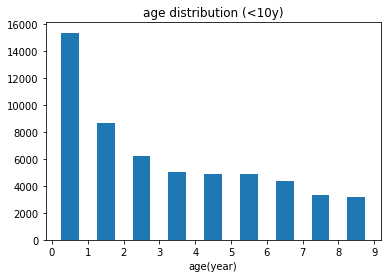

In [106]:
import matplotlib.pyplot as plt

age_lis = df['age_cal'].values
plt.title('age distribution (<10y)')
plt.xlabel('age(year)')
plt.xticks(np.arange(0,10,1))
plt.hist(age_lis, bins=np.arange(0,10,1), rwidth=0.5)

## Dataset

In [91]:
random.seed(0)
df = shuffle(df)
y = df[[TARGET_VAR]].values.flatten().astype(float)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]


# encoding : 2 -> 0, 2.5 -> 1, ... 8.5 -> 14 로 tube size x 2 - 4
df['label'] = df[TARGET_VAR].apply(lambda x: x*2-4)

for i in range(14):
    df[f'{i}'] = df['label'].apply(lambda x: 1 if x==i else 0)
    
y_label = df[[f'{i}' for i in range(14)]].values
yl_test = y_label[-ntest:]
yl_train = y_label[:ntrain]

### ETT size

In [93]:
print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.720
mean_squared_errors: 0.293
r2_score: 0.701
acc: 0.368
acc(+-0.5mm): 0.879


### ETT fixed depth

In [227]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

# age, sex, airway tube size 값이 없는 경우는 제외
df.dropna(subset=['age', 'airway_tube_size'], inplace=True)
df['sex'] = (df['sex'] == 'M')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

# inclusion criteria : 소아 10세 미만
df = df.loc[df['age_cal'] < 10-0.01]
df = df.loc[df['age_cal'] > 0]


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

perc = np.mean(df['cuffed'].values)
print(f'소아 10세 미만에서 cuffed ETT 사용 비율: {perc:.3f}')
print(f'소아 10세 미만 최종 opid수: {len(df)}')

# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)


# fixed depth를 output
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed', 'airway_tube_size']
TARGET_VAR = 'fixed'


random.seed(98)
#seed_everything(SEED)
df.dropna(subset=['fixed'], inplace=True)
df = df.loc[df['fixed']>=12]
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

중복되는 hid는 첫번째 수술 외 제외: 34042
소아 10세 미만에서 cuffed ETT 사용 비율: 0.287
소아 10세 미만 최종 opid수: 34042
x_train: (18270, 6), x_test: (4567, 6)


## 결측치 채우기 (multi-imputer)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

# ETT Size

## 1. XGBoost model

In [95]:
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [4, 5, 7],#[3,4,5],
                'n_estimators': [100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = RandomizedSearchCV(n_iter=100,
                        estimator=xgb.sklearn.XGBRegressor(),
                        n_jobs=-1,
                        verbose=5,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2

print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')


xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        cvals.append(sum((y_pred == x) & (y_test == y)))
        cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals_old, label='4+AGE/4')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.savefig('old.png')
plt.close()

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='blue', alpha=0.5, s=cvals, label='GBRT')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.savefig('new.png')
plt.close()

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')


# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'regression model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/painstudy/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



========= found hyperparameter =========
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'colsample_bytree': 0.8}
0.8067772022468374
--------------
old model = age/4+4
--------------
explained_variance_score: 0.720
mean_squared_errors: 0.293
r2_score: 0.701
acc: 0.368
acc(+-0.5mm): 0.879
--------------
new model
--------------
explained_variance_score: 0.792
mean_squared_errors: 0.204
r2_score: 0.792
acc: 0.454
acc(+-0.5mm): 0.927


# ETT fixed depth

In [21]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv, math


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

# age, sex, airway tube size 값이 없는 경우는 제외
df.dropna(subset=['age', 'airway_tube_size'], inplace=True)
df['sex'] = (df['sex'] == 'M')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

# inclusion criteria : 소아 10세 미만
df = df.loc[df['age_cal'] < 10-0.01]
df = df.loc[df['age_cal'] > 0]
df['age'] = df['age_cal'].apply(lambda x: math.floor(x))


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

perc = np.mean(df['cuffed'].values)
print(f'소아 10세 미만에서 cuffed ETT 사용 비율: {perc:.3f}')
print(f'소아 10세 미만 최종 opid수: {len(df)}')

# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)


# fixed depth를 output
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed', 'airway_tube_size']
TARGET_VAR = 'fixed'


random.seed(98)
#seed_everything(SEED)
df.dropna(subset=['fixed'], inplace=True)
df = df.loc[df['fixed']>=12]
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)
c = df['opid'].values.flatten().astype(int)

# 저장하기
pickle.dump(df, open(f'dataset/ETT_depth_12','wb'))
np.savez(f'dataset/ETT_depth_12.npz', x=x, y=y, c=c)


# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

중복되는 hid는 첫번째 수술 외 제외: 34042
소아 10세 미만에서 cuffed ETT 사용 비율: 0.287
소아 10세 미만 최종 opid수: 34042
x_train: (18270, 6), x_test: (4567, 6)


In [5]:
dat = np.load(f'dataset/ETT_depth_12.npz')
x, y = dat['x'], dat['y']
x = x[:,0:5]


nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (18270, 5), x_test: (4567, 5)


## PALS guideline

In [25]:
OLD_VAR = 'old_depth1'
df[OLD_VAR] = 3 * df['old_tube_size']
#df[OLD_VAR] = df['airway_tube_size'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
#df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

print('--------------')
print('old model = 3 * age-based ETT size')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')

--------------
old model = 3 * age-based ETT size
--------------
explained_variance_score: 0.410
mean_squared_errors: 2.727
mean_absolute_errors: 1.266
r2_score: 0.318


In [24]:
OLD_VAR = 'old_depth1'
# OLD_VAR = 'old_tube_size'
df[OLD_VAR] = 3 * df['airway_tube_size']
#df[OLD_VAR] = df['airway_tube_size'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
#df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

print('--------------')
print('old model = 3 * ETT size')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')

--------------
old model = 3 * ETT size
--------------
explained_variance_score: 0.300
mean_squared_errors: 3.038
mean_absolute_errors: 1.341
r2_score: 0.241


In [26]:
OLD_VAR = 'old_depth1'
# OLD_VAR = 'old_tube_size'
df[OLD_VAR] = df['age'] / 2 + 12
#df[OLD_VAR] = df['airway_tube_size'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
#df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

print('--------------')
print('old model = age / 2 + 12')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')

--------------
old model = age / 2 + 12
--------------
explained_variance_score: 0.656
mean_squared_errors: 2.179
mean_absolute_errors: 1.107
r2_score: 0.455


In [6]:
# depth 제한 없을 때
OLD_VAR = 'old_depth1'
df[OLD_VAR] = 3 * df['airway_tube_size']
#df[OLD_VAR] = df['airway_tube_size'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
#df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

print('--------------')
print('old model = 3 * age-based ETT size')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')

--------------
old model = 3 * age-based ETT size
--------------
explained_variance_score: 0.616
mean_squared_errors: 3.273
mean_absolute_errors: 1.354
r2_score: 0.581


In [238]:
plt.figure(figsize=(8, 8))
plt.xlim(10, 25)
plt.ylim(10, 25)
plt.scatter(y_test_old, y_test, c='red', alpha=0.5, label='3*ETT size')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([10,25], [10,25], 'k-', alpha=0.1)
plt.savefig('old_depth.png')
plt.close()

## XGBR

### Input 6 (age, sex, height, weight, cuffed, size of tube)

In [36]:
# 길이 제한 없는 경우
from sklearn.metrics import mean_absolute_error

# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                    n_jobs=-1,
                    verbose=5,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mse:.3f}')
print(f'mean_absolute_errors: {mae:.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc3 = np.mean((y_pred >= y_test-1) & (y_pred <= y_test+1))
print(f'acc(+-1cm): {acc3:.3f}')

Fitting 10 folds for each of 120 candidates, totalling 1200 fits

========= found hyperparameter =========
{'colsample_bytree': 0.8, 'max_depth': 4, 'n_estimators': 25, 'subsample': 1}
0.7031280409918352
--------------
new model
--------------
explained_variance_score: 0.717
mean_squared_errors: 1.133
mean_absolute_errors: 0.795
r2_score: 0.717
acc(+-1cm): 0.713


In [37]:
# save model
odir_f = f'mae-{mae:.3f}_mse-{mse:.3f}_XGBR_{nfold}fold'
odir = f'result/depth/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')
pickle.dump(gs, open(f'{odir}/gridSearch','wb'))

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

[CV 10/10] END bootstrap=False, max_depth=7, max_features=log2, max_leaf_nodes=5, n_estimators=300;, score=0.675 total time=   2.5s
[CV 1/5] END colsample_bytree=0.5, max_depth=4, n_estimators=300, subsample=0.8;, score=0.692 total time=   2.6s
[CV 2/5] END colsample_bytree=0.5, max_depth=7, n_estimators=200, subsample=0.5;, score=0.633 total time=   3.0s
[CV 1/5] END colsample_bytree=0.8, max_depth=5, n_estimators=100, subsample=0.5;, score=0.693 total time=   1.3s
[CV 1/5] END colsample_bytree=0.8, max_depth=5, n_estimators=300, subsample=0.5;, score=0.664 total time=   3.9s
[CV 5/5] END colsample_bytree=0.5, max_depth=3, n_estimators=25, subsample=1;, score=0.688 total time=   0.2s
[CV 4/5] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=1;, score=0.684 total time=   0.6s
[CV 4/5] END colsample_bytree=0.5, max_depth=4, n_estimators=25, subsample=0.5;, score=0.682 total time=   0.3s
[CV 1/5] END colsample_bytree=0.5, max_depth=4, n_estimators=50, subsample=0.5;, sc

### Inputs 5 (age, sex, height, weight, cuffed)

In [6]:
# 길이 제한 없는 경우
from sklearn.metrics import mean_absolute_error

# age (일단위)
param_dict = {
                'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                    n_jobs=-1,
                    verbose=3,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mse:.3f}')
print(f'mean_absolute_errors: {mae:.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc3 = np.mean((y_pred >= y_test-1) & (y_pred <= y_test+1))
print(f'acc(+-1cm): {acc3:.3f}')

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
[CV 3/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, n_estimators=25, subsample=0.8;, score=-3.475 total time=   1.2s
[CV 7/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8;, score=0.698 total time=   0.7s
[CV 9/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1;, score=0.677 total time=   1.1s
[CV 1/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=4, n_estimators=25, subsample=0.5;, score=-3.243 total time=   0.2s
[CV 1/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=4, n_estimators=25, subsample=0.8;, score=-3.238 total time=   0.2s
[CV 1/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=4, n_estimators=25, subsample=1;, score=-3.244 total time=   0.2s
[CV 1/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=4, n_estimators=50, subsample=0.5;, score=0.413 total time=   0.4s
[C

In [ ]:
# save model
odir_f = f'mae-{mae:.3f}_mse-{mse:.3f}_XGBR-5inputs_{nfold}fold'
odir = f'result/depth/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')
pickle.dump(gs, open(f'{odir}/gridSearch','wb'))

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

## RF

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

print(f'x_train shape: {x_train_imputed.shape}, x_test shape: {x_test_imputed.shape}')

x_train shape: (18270, 5), x_test shape: (4567, 5)


In [29]:
from sklearn.ensemble import RandomForestRegressor

SEED = 98
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 5, 7],#[3,4,5],
                'max_leaf_nodes': [3, 5, 7],
                'n_estimators': [50, 100, 200, 300],
                'max_features': ['auto', 'sqrt', 'log2'],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                #'min_samples_split': [2,3,5],
                #'min_samples_leaf': [1,2,3],
               'bootstrap': [True, False]
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=RandomForestRegressor(random_state = SEED),
                    n_jobs=-1,
                    verbose=5,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")


y_pred = gs.predict(x_test_imputed).flatten()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mse:.3f}')
print(f'mean_absolute_errors: {mae:.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc3 = np.mean((y_pred >= y_test-1) & (y_pred <= y_test+1))
print(f'acc(+-1cm): {acc3:.3f}')

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV 3/5] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.8;, score=0.726 total time=   1.6s
[CV 5/5] END colsample_bytree=0.5, max_depth=4, n_estimators=100, subsample=0.8;, score=0.684 total time=   1.2s
[CV 1/5] END colsample_bytree=0.5, max_depth=5, n_estimators=100, subsample=0.8;, score=0.699 total time=   1.2s
[CV 3/5] END colsample_bytree=0.5, max_depth=7, n_estimators=25, subsample=0.8;, score=0.723 total time=   0.4s
[CV 3/5] END colsample_bytree=0.5, max_depth=7, n_estimators=50, subsample=0.8;, score=0.713 total time=   0.7s
[CV 2/5] END colsample_bytree=0.5, max_depth=7, n_estimators=200, subsample=0.8;, score=0.652 total time=   3.5s
[CV 2/5] END colsample_bytree=0.8, max_depth=4, n_estimators=100, subsample=0.8;, score=0.691 total time=   1.0s
[CV 5/5] END colsample_bytree=0.8, max_depth=4, n_estimators=300, subsample=0.5;, score=0.652 total time=   3.1s
[CV 1/5] END colsample_bytree=0.8

In [8]:
# save model
odir_f = f'mae-{mae:.3f}_mse-{mse:.3f}_RF-6inputs_{nfold}fold'
odir = f'result/depth/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
#model.save_model(f'{odir}/model.model')
pickle.dump(gs, open(f'{odir}/gridSearch','wb'))

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

### 5 Inputs

In [10]:
from sklearn.ensemble import RandomForestRegressor

SEED = 98
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 5, 7],#[3,4,5],
                'max_leaf_nodes': [3, 5, 7],
                'n_estimators': [50, 100, 200, 300],
                'max_features': ['auto', 'sqrt', 'log2'],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                #'min_samples_split': [2,3,5],
                #'min_samples_leaf': [1,2,3],
               'bootstrap': [True, False]
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=RandomForestRegressor(random_state = SEED),
                    n_jobs=-1,
                    verbose=5,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")


y_pred = gs.predict(x_test_imputed).flatten()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mse:.3f}')
print(f'mean_absolute_errors: {mae:.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc3 = np.mean((y_pred >= y_test-1) & (y_pred <= y_test+1))
print(f'acc(+-1cm): {acc3:.3f}')

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV 4/10] END bootstrap=True, max_depth=3, max_features=auto, max_leaf_nodes=3, n_estimators=200;, score=0.633 total time=   2.4s
[CV 4/10] END bootstrap=True, max_depth=3, max_features=auto, max_leaf_nodes=5, n_estimators=300;, score=0.671 total time=   4.2s
[CV 8/10] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=3, n_estimators=300;, score=0.604 total time=   2.2s
[CV 1/10] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=7, n_estimators=300;, score=0.691 total time=   2.4s
[CV 1/10] END bootstrap=True, max_depth=3, max_features=log2, max_leaf_nodes=5, n_estimators=200;, score=0.681 total time=   1.6s
[CV 1/10] END bootstrap=True, max_depth=3, max_features=log2, max_leaf_nodes=7, n_estimators=300;, score=0.691 total time=   2.4s
[CV 1/10] END bootstrap=True, max_depth=5, max_features=auto, max_leaf_nodes=5, n_estimators=100;, score=0.665 total time=   1.5s
[CV 1/10] END bootstrap=T

In [11]:
# save model
odir_f = f'mae-{mae:.3f}_mse-{mse:.3f}_RF-5inputs_{nfold}fold'
odir = f'result/depth/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
#model.save_model(f'{odir}/model.model')
pickle.dump(gs, open(f'{odir}/gridSearch','wb'))

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

[CV 8/10] END bootstrap=True, max_depth=3, max_features=auto, max_leaf_nodes=3, n_estimators=100;, score=0.589 total time=   1.2s
[CV 4/10] END bootstrap=True, max_depth=3, max_features=auto, max_leaf_nodes=5, n_estimators=200;, score=0.671 total time=   2.8s
[CV 5/10] END bootstrap=True, max_depth=3, max_features=auto, max_leaf_nodes=7, n_estimators=300;, score=0.697 total time=   4.2s
[CV 5/10] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=7, n_estimators=50;, score=0.705 total time=   0.4s
[CV 5/10] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=7, n_estimators=100;, score=0.705 total time=   0.8s
[CV 5/10] END bootstrap=True, max_depth=3, max_features=log2, max_leaf_nodes=3, n_estimators=50;, score=0.643 total time=   0.4s
[CV 5/10] END bootstrap=True, max_depth=3, max_features=log2, max_leaf_nodes=3, n_estimators=100;, score=0.648 total time=   0.7s
[CV 5/10] END bootstrap=True, max_depth=3, max_features=log2, max_leaf_nodes=5, n_estimators

In [14]:
np.mean(dat['c'])

124465769.01952972

## DNN

In [38]:
from keras import losses, metrics
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, interp
import os, sys, pickle, shutil
import pandas as pd
import numpy as np
import random, datetime, time
from sklearn.model_selection import KFold


# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 98):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [39]:
from sklearn.preprocessing import StandardScaler

# normalization
sc = StandardScaler()
x_train = sc.fit_transform(pd.DataFrame(x_train))
x_test = sc.transform(pd.DataFrame(x_test))


# fill missing value
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [40]:
# folder
nfold = 10  # 각각의 hyperparameter에 대해 k-fold 를 시행하고 평균을 구한다.
ntest = 500
rootdir = f"result/size/DNN_depth_both"

if not os.path.exists(rootdir):
    os.mkdir(rootdir)

# 모델에 대한 정보 txt로 저장
f = open(f'{rootdir}/README.txt', 'w')
f.write(f'model: DNN 2 layers, regression')
f.write(f'input: age, sex, height, weight, cuffed 유무, tube size  output: depth')
f.close()
    

# test_settings
layer_settings, test_settings = [], []


# hyperparamters pool
dropout_opts  = [0, 0.1, 0.2, 0.3, 0.4, 0.5] # dropout rate
dense_opts = [16, 32, 64, 128, 256, 512]
BATCH_SIZE = [32, 64, 128, 256, 512]
lr_opts = [0.001, 0.002, 0.0005]

print('start making test settings...', end='', flush=True)
# test settings
dnodes, dropouts = [], []
for i in range(2):
    dnodes.append(0)
    dropouts.append(0)


for dnode1 in dense_opts:
    for dropout1 in dropout_opts:
        for dnode2 in dense_opts:
            for dropout2 in dropout_opts:
                for batch_size in BATCH_SIZE:
                    for learning_rate in lr_opts:
                        test_settings.append([dnode1, dropout1, dnode2, dropout2, batch_size, learning_rate])                                   

                        
print('done')
print(datetime.datetime.now())

start making test settings...done
2023-02-18 00:33:48.682537


In [ ]:
from keras import metrics

seed_everything(SEED)

# random search for hyperparameter
ntrial = ntest
train_errs, val_errs = [] ,[]
test_acc, test_roc, test_prc = [], [], []
#test_rmse, test_mae, test_auc = [], [], []
random_settings = []


for itrial in range(ntrial):
    # grid search
    # test_setting = test_settings[itrial]

    # random search
    print('random search {}/{}'.format(itrial, ntrial))
    
    # total conv layers of the model
    nlayer = random.choice([1,2]) 
    # test settings
    dnodes[0], dropouts[0], dnodes[1], dropouts[1], batch_size, learning_rate = random.choice(test_settings)
    

    # 이번 옵션에 대한 결과 디렉토리
    odir_f = f'batch{batch_size},'
    for i in range(nlayer):
        odir_f += f'dnodes{dnodes[i]}_dropout{dropouts[i]},'
    odir_f += f'lr{learning_rate}'
    random_settings.append(odir_f)
    
    odir = rootdir + '/' + odir_f
    if not os.path.exists(odir):
        os.mkdir(odir)


    # build a model
    inp = Input(shape=(x_train.shape[1],))
    out = inp

    
    for i in range(nlayer):      
        out = Dense(dnodes[i], activation='relu')(out)
        out = Dropout(dropouts[i])(out)
    
    out = Dense(1)(out)


    model = Model(inputs=[inp], outputs=[out])
    model.save_weights(f'{odir}/initial_weights.hdf5')
        

    # 4-fold cv
    kfold = KFold(nfold)
    acc1s, acc3s, maes, mses = [], [], [], []

    switch = 0
    for fold, (train_mask, test_mask) in enumerate(kfold.split(y_train)):
        X_train = x_train_imputed[train_mask]
        X_test = x_train_imputed[test_mask] 
        
        Y_train = y_train[train_mask]
        Y_test = y_train[test_mask]


        # model 학습
        try:
            weightcache = f"{odir}/weights_{fold}.hdf5"
            model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=[])
            hist = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

            model.load_weights(weightcache)
            y_pred = model.predict(X_test).flatten()
            
            mae = mean_absolute_error(Y_test, y_pred)    
            mse = mean_squared_error(Y_test, y_pred)
            
            maes.append(mae)
            mses.append(mse)

            print(f' ###{fold} fold : val mae {mae:.3f}, mse {mse:.3f}###')
            tf.keras.backend.clear_session()
            model.load_weights(f'{odir}/initial_weights.hdf5')

        except Exception as e:
            print(e)
            switch = 1
            shutil.rmtree(odir)
            itrial -= 1
            break

    if switch:
        switch = 0
        continue
    

    print(f'mae{np.mean(mses):.3f}_mse{np.mean(acc3):.3f}')
    open(odir+"/model.json", "wt").write(model.to_json())

    os.rename(odir, rootdir+f'/mae{np.mean(maes):.3f}_mse{np.mean(mses):.3f}_{odir_f}')
    tf.keras.backend.clear_session()

random search 0/500


2023-02-18 00:36:01.158285: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 00:36:03.627603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30708 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2023-02-18 00:36:03.628322: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 142 MB memory:  -> device: 1, name: Tesla V100-DGXS-32GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2023-02-18 00:36:03.628981: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:G

Epoch 1/100
410/412 [============================>.] - ETA: 0s - loss: 9.1673
Epoch 00001: val_loss improved from inf to 1.94784, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
412/412 [==============================] - 3s 4ms/step - loss: 9.1493 - val_loss: 1.9478
Epoch 2/100
401/412 [============================>.] - ETA: 0s - loss: 2.3918
Epoch 00002: val_loss improved from 1.94784 to 1.68317, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 2.3872 - val_loss: 1.6832
Epoch 3/100
408/412 [============================>.] - ETA: 0s - loss: 2.2415
Epoch 00003: val_loss improved from 1.68317 to 1.48620, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 2.2355 - val_

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


401/412 [============================>.] - ETA: 0s - loss: 11.6960
Epoch 00001: val_loss improved from inf to 1.72322, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 11.4657 - val_loss: 1.7232
Epoch 2/100
399/412 [============================>.] - ETA: 0s - loss: 3.6826
Epoch 00002: val_loss improved from 1.72322 to 1.47926, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 3.6457 - val_loss: 1.4793
Epoch 3/100
408/412 [============================>.] - ETA: 0s - loss: 2.8048
Epoch 00003: val_loss improved from 1.47926 to 1.34114, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 2.7967 - val_loss: 1.34

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


403/412 [============================>.] - ETA: 0s - loss: 11.5998
Epoch 00001: val_loss improved from inf to 1.68793, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 11.4134 - val_loss: 1.6879
Epoch 2/100
411/412 [============================>.] - ETA: 0s - loss: 3.5694
Epoch 00002: val_loss improved from 1.68793 to 1.44972, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 3.5689 - val_loss: 1.4497
Epoch 3/100
410/412 [============================>.] - ETA: 0s - loss: 2.7322
Epoch 00003: val_loss improved from 1.44972 to 1.36899, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 2.7293 - val_loss: 1.36

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


410/412 [============================>.] - ETA: 0s - loss: 11.5554
Epoch 00001: val_loss improved from inf to 1.77258, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 11.5316 - val_loss: 1.7726
Epoch 2/100
400/412 [============================>.] - ETA: 0s - loss: 3.6318
Epoch 00002: val_loss improved from 1.77258 to 1.55057, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 3.5984 - val_loss: 1.5506
Epoch 3/100
410/412 [============================>.] - ETA: 0s - loss: 2.7556
Epoch 00003: val_loss improved from 1.55057 to 1.36954, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 2.7517 - val_loss: 1.36

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


402/412 [============================>.] - ETA: 0s - loss: 11.8066
Epoch 00001: val_loss improved from inf to 1.75443, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 11.5945 - val_loss: 1.7544
Epoch 2/100
409/412 [============================>.] - ETA: 0s - loss: 3.6596
Epoch 00002: val_loss improved from 1.75443 to 1.55941, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 3.6519 - val_loss: 1.5594
Epoch 3/100
408/412 [============================>.] - ETA: 0s - loss: 2.7690
Epoch 00003: val_loss improved from 1.55941 to 1.36016, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 2.7641 - val_loss: 1.36

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


410/412 [============================>.] - ETA: 0s - loss: 11.5351
Epoch 00001: val_loss improved from inf to 1.78186, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
412/412 [==============================] - 2s 5ms/step - loss: 11.5115 - val_loss: 1.7819
Epoch 2/100
398/412 [===========================>..] - ETA: 0s - loss: 3.7098
Epoch 00002: val_loss improved from 1.78186 to 1.52903, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 3.6724 - val_loss: 1.5290
Epoch 3/100
402/412 [============================>.] - ETA: 0s - loss: 2.8034
Epoch 00003: val_loss improved from 1.52903 to 1.39585, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 2.7939 - val_loss: 1.39

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


403/412 [============================>.] - ETA: 0s - loss: 11.4363
Epoch 00001: val_loss improved from inf to 1.84829, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 11.2525 - val_loss: 1.8483
Epoch 2/100
406/412 [============================>.] - ETA: 0s - loss: 3.5649
Epoch 00002: val_loss improved from 1.84829 to 1.43999, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 3.5493 - val_loss: 1.4400
Epoch 3/100
408/412 [============================>.] - ETA: 0s - loss: 2.7623
Epoch 00003: val_loss improved from 1.43999 to 1.42635, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 2.7592 - val_loss: 1.42

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


399/412 [============================>.] - ETA: 0s - loss: 11.5280
Epoch 00001: val_loss improved from inf to 1.69994, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 11.2601 - val_loss: 1.6999
Epoch 2/100
409/412 [============================>.] - ETA: 0s - loss: 3.5433
Epoch 00002: val_loss improved from 1.69994 to 1.42405, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 3.5369 - val_loss: 1.4240
Epoch 3/100
407/412 [============================>.] - ETA: 0s - loss: 2.7583
Epoch 00003: val_loss improved from 1.42405 to 1.34722, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 2.7571 - val_loss: 1.34

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


408/412 [============================>.] - ETA: 0s - loss: 11.2160
Epoch 00001: val_loss improved from inf to 1.64737, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 11.1495 - val_loss: 1.6474
Epoch 2/100
399/412 [============================>.] - ETA: 0s - loss: 3.5029
Epoch 00002: val_loss improved from 1.64737 to 1.44438, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 3.4640 - val_loss: 1.4444
Epoch 3/100
399/412 [============================>.] - ETA: 0s - loss: 2.7389
Epoch 00003: val_loss improved from 1.44438 to 1.37935, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 2.7221 - val_loss: 1.37

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


404/412 [============================>.] - ETA: 0s - loss: 11.3054
Epoch 00001: val_loss improved from inf to 1.58773, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 11.1495 - val_loss: 1.5877
Epoch 2/100
400/412 [============================>.] - ETA: 0s - loss: 3.4989
Epoch 00002: val_loss improved from 1.58773 to 1.47743, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 3.4640 - val_loss: 1.4774
Epoch 3/100
412/412 [==============================] - ETA: 0s - loss: 2.7221
Epoch 00003: val_loss improved from 1.47743 to 1.41933, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 2.7221 - val_loss: 1.41

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


46/52 [=========================>....] - ETA: 0s - loss: 215.6327
Epoch 00001: val_loss improved from inf to 198.49387, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 214.1319 - val_loss: 198.4939
Epoch 2/100
47/52 [==========================>...] - ETA: 0s - loss: 186.4706
Epoch 00002: val_loss improved from 198.49387 to 168.78352, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 185.1893 - val_loss: 168.7835
Epoch 3/100
47/52 [==========================>...] - ETA: 0s - loss: 155.5182
Epoch 00003: val_loss improved from 168.78352 to 136.22087, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 154.0583 - val_loss: 136.2209
Epoch 4/100
44/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 216.3775
Epoch 00001: val_loss improved from inf to 198.50757, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 213.8587 - val_loss: 198.5076
Epoch 2/100
42/52 [=======================>......] - ETA: 0s - loss: 187.6369
Epoch 00002: val_loss improved from 198.50757 to 168.81210, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 184.9789 - val_loss: 168.8121
Epoch 3/100
41/52 [======================>.......] - ETA: 0s - loss: 157.3056
Epoch 00003: val_loss improved from 168.81210 to 136.29985, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 153.9070 - val_loss: 136.2999
Epoch 4/100
41/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


40/52 [======================>.......] - ETA: 0s - loss: 217.0469
Epoch 00001: val_loss improved from inf to 198.56480, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 213.8110 - val_loss: 198.5648
Epoch 2/100
42/52 [=======================>......] - ETA: 0s - loss: 187.8518
Epoch 00002: val_loss improved from 198.56480 to 168.94078, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 185.0148 - val_loss: 168.9408
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 156.8987
Epoch 00003: val_loss improved from 168.94078 to 136.53387, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 154.1524 - val_loss: 136.5339
Epoch 4/100
42/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


42/52 [=======================>......] - ETA: 0s - loss: 216.3861
Epoch 00001: val_loss improved from inf to 198.57758, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 213.6767 - val_loss: 198.5776
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 187.5945
Epoch 00002: val_loss improved from 198.57758 to 168.92633, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 184.9111 - val_loss: 168.9263
Epoch 3/100
44/52 [========================>.....] - ETA: 0s - loss: 156.5397
Epoch 00003: val_loss improved from 168.92633 to 136.44498, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 154.0400 - val_loss: 136.4450
Epoch 4/100
42/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 215.6676
Epoch 00001: val_loss improved from inf to 198.58923, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 213.5671 - val_loss: 198.5892
Epoch 2/100
45/52 [========================>.....] - ETA: 0s - loss: 186.7127
Epoch 00002: val_loss improved from 198.58923 to 168.89754, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 184.7745 - val_loss: 168.8975
Epoch 3/100
44/52 [========================>.....] - ETA: 0s - loss: 156.2113
Epoch 00003: val_loss improved from 168.89754 to 136.41634, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 153.8677 - val_loss: 136.4163
Epoch 4/100
45/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


47/52 [==========================>...] - ETA: 0s - loss: 214.8779
Epoch 00001: val_loss improved from inf to 198.58789, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 213.6665 - val_loss: 198.5879
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 187.1570
Epoch 00002: val_loss improved from 198.58789 to 168.94170, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 184.8953 - val_loss: 168.9417
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 156.4655
Epoch 00003: val_loss improved from 168.94170 to 136.45944, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 153.9563 - val_loss: 136.4594
Epoch 4/100
41/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 216.0917
Epoch 00001: val_loss improved from inf to 198.57658, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 213.7191 - val_loss: 198.5766
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 187.5032
Epoch 00002: val_loss improved from 198.57658 to 168.89996, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 184.9386 - val_loss: 168.9000
Epoch 3/100
42/52 [=======================>......] - ETA: 0s - loss: 156.9031
Epoch 00003: val_loss improved from 168.89996 to 136.42451, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 154.0504 - val_loss: 136.4245
Epoch 4/100
42/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 216.0541
Epoch 00001: val_loss improved from inf to 198.57932, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 213.9888 - val_loss: 198.5793
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 187.6599
Epoch 00002: val_loss improved from 198.57932 to 168.90744, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 185.0413 - val_loss: 168.9074
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 156.5285
Epoch 00003: val_loss improved from 168.90744 to 136.41078, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 153.9962 - val_loss: 136.4108
Epoch 4/100
45/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


47/52 [==========================>...] - ETA: 0s - loss: 214.8916
Epoch 00001: val_loss improved from inf to 198.22043, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 213.8770 - val_loss: 198.2204
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 187.4736
Epoch 00002: val_loss improved from 198.22043 to 168.95033, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 184.9472 - val_loss: 168.9503
Epoch 3/100
45/52 [========================>.....] - ETA: 0s - loss: 155.7435
Epoch 00003: val_loss improved from 168.95033 to 136.88864, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 153.9225 - val_loss: 136.8886
Epoch 4/100
43/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


45/52 [========================>.....] - ETA: 0s - loss: 215.5067
Epoch 00001: val_loss improved from inf to 198.71324, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 213.8770 - val_loss: 198.7132
Epoch 2/100
46/52 [=========================>....] - ETA: 0s - loss: 186.7126
Epoch 00002: val_loss improved from 198.71324 to 169.34277, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 184.9472 - val_loss: 169.3428
Epoch 3/100
48/52 [==========================>...] - ETA: 0s - loss: 154.9739
Epoch 00003: val_loss improved from 169.34277 to 137.14964, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 153.9225 - val_loss: 137.1496
Epoch 4/100
48/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


193/206 [===========================>..] - ETA: 0s - loss: 45.1081
Epoch 00001: val_loss improved from inf to 3.46156, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 42.9358 - val_loss: 3.4616
Epoch 2/100
203/206 [============================>.] - ETA: 0s - loss: 7.1665
Epoch 00002: val_loss improved from 3.46156 to 2.68025, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.1283 - val_loss: 2.6803
Epoch 3/100
202/206 [============================>.] - ETA: 0s - loss: 3.2942
Epoch 00003: val_loss improved from 2.68025 to 1.82188, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.2822 - val_loss: 1.8219


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


202/206 [============================>.] - ETA: 0s - loss: 44.1429
Epoch 00001: val_loss improved from inf to 3.34596, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 43.5375 - val_loss: 3.3460
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 8.1593
Epoch 00002: val_loss improved from 3.34596 to 2.54583, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 8.0504 - val_loss: 2.5458
Epoch 3/100
206/206 [==============================] - ETA: 0s - loss: 4.3922
Epoch 00003: val_loss improved from 2.54583 to 1.78563, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.3922 - val_loss: 1.7856


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 45.1599
Epoch 00001: val_loss improved from inf to 3.34736, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 43.6826 - val_loss: 3.3474
Epoch 2/100
204/206 [============================>.] - ETA: 0s - loss: 8.0525
Epoch 00002: val_loss improved from 3.34736 to 2.59562, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 8.0249 - val_loss: 2.5956
Epoch 3/100
191/206 [==========================>...] - ETA: 0s - loss: 4.5224
Epoch 00003: val_loss improved from 2.59562 to 1.83551, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.3971 - val_loss: 1.8355


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


203/206 [============================>.] - ETA: 0s - loss: 44.1805
Epoch 00001: val_loss improved from inf to 3.39893, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 43.7673 - val_loss: 3.3989
Epoch 2/100
194/206 [===========================>..] - ETA: 0s - loss: 8.1050
Epoch 00002: val_loss improved from 3.39893 to 2.47627, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.9660 - val_loss: 2.4763
Epoch 3/100
195/206 [===========================>..] - ETA: 0s - loss: 4.5591
Epoch 00003: val_loss improved from 2.47627 to 1.83971, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.4788 - val_loss: 1.8397


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 44.0280
Epoch 00001: val_loss improved from inf to 3.35149, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 43.9470 - val_loss: 3.3515
Epoch 2/100
204/206 [============================>.] - ETA: 0s - loss: 8.0979
Epoch 00002: val_loss improved from 3.35149 to 2.61428, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 8.0673 - val_loss: 2.6143
Epoch 3/100
203/206 [============================>.] - ETA: 0s - loss: 4.5360
Epoch 00003: val_loss improved from 2.61428 to 1.76820, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.5180 - val_loss: 1.7682


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


192/206 [==========================>...] - ETA: 0s - loss: 45.8946
Epoch 00001: val_loss improved from inf to 3.33879, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 43.6156 - val_loss: 3.3388
Epoch 2/100
193/206 [===========================>..] - ETA: 0s - loss: 8.1890
Epoch 00002: val_loss improved from 3.33879 to 2.40901, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 8.0224 - val_loss: 2.4090
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 4.5874
Epoch 00003: val_loss improved from 2.40901 to 1.72277, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.5299 - val_loss: 1.7228


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


195/206 [===========================>..] - ETA: 0s - loss: 45.2368
Epoch 00001: val_loss improved from inf to 3.31617, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 43.4684 - val_loss: 3.3162
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 8.1246
Epoch 00002: val_loss improved from 3.31617 to 2.34389, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 8.0003 - val_loss: 2.3439
Epoch 3/100
198/206 [===========================>..] - ETA: 0s - loss: 4.4588
Epoch 00003: val_loss improved from 2.34389 to 1.69512, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.4197 - val_loss: 1.6951


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


200/206 [============================>.] - ETA: 0s - loss: 44.2233
Epoch 00001: val_loss improved from inf to 3.27021, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 43.3337 - val_loss: 3.2702
Epoch 2/100
199/206 [===========================>..] - ETA: 0s - loss: 8.0700
Epoch 00002: val_loss improved from 3.27021 to 2.47575, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.9747 - val_loss: 2.4758
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 4.5171
Epoch 00003: val_loss improved from 2.47575 to 1.72637, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.4670 - val_loss: 1.7264


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


203/206 [============================>.] - ETA: 0s - loss: 43.6122
Epoch 00001: val_loss improved from inf to 3.15315, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 43.2090 - val_loss: 3.1531
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 8.1133
Epoch 00002: val_loss improved from 3.15315 to 2.44389, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.9856 - val_loss: 2.4439
Epoch 3/100
190/206 [==========================>...] - ETA: 0s - loss: 4.5224
Epoch 00003: val_loss improved from 2.44389 to 1.77697, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.4401 - val_loss: 1.7770


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


206/206 [==============================] - ETA: 0s - loss: 43.2090
Epoch 00001: val_loss improved from inf to 2.79762, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 43.2090 - val_loss: 2.7976
Epoch 2/100
200/206 [============================>.] - ETA: 0s - loss: 8.0692
Epoch 00002: val_loss improved from 2.79762 to 2.36615, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.9856 - val_loss: 2.3661
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 4.4899
Epoch 00003: val_loss improved from 2.36615 to 1.78993, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.4401 - val_loss: 1.7899


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/26 [======================>.......] - ETA: 0s - loss: 202.7585 
Epoch 00001: val_loss improved from inf to 178.15126, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 198.6819 - val_loss: 178.1513
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 162.7567
Epoch 00002: val_loss improved from 178.15126 to 128.33775, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 157.4326 - val_loss: 128.3378
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 112.2655
Epoch 00003: val_loss improved from 128.33775 to 72.44862, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 105.3346 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/26 [======================>.......] - ETA: 0s - loss: 202.7876
Epoch 00001: val_loss improved from inf to 178.13315, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 198.4621 - val_loss: 178.1331
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 162.3382
Epoch 00002: val_loss improved from 178.13315 to 128.33502, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 157.1132 - val_loss: 128.3350
Epoch 3/100
20/26 [======================>.......] - ETA: 0s - loss: 111.2502
Epoch 00003: val_loss improved from 128.33502 to 72.68642, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 105.5491 - val_lo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 203.4546
Epoch 00001: val_loss improved from inf to 178.15776, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 198.3427 - val_loss: 178.1578
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 163.1988
Epoch 00002: val_loss improved from 178.15776 to 128.36456, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 157.0692 - val_loss: 128.3646
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 112.4530
Epoch 00003: val_loss improved from 128.36456 to 72.70745, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 105.4539 - val_lo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/26 [======================>.......] - ETA: 0s - loss: 202.5041
Epoch 00001: val_loss improved from inf to 178.22786, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 198.2197 - val_loss: 178.2279
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 162.3240
Epoch 00002: val_loss improved from 178.22786 to 128.51782, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 157.0494 - val_loss: 128.5178
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 112.5135
Epoch 00003: val_loss improved from 128.51782 to 72.82125, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 105.5450 - val_lo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
20/26 [======================>.......] - ETA: 0s - loss: 202.3622
Epoch 00001: val_loss improved from inf to 178.26070, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 198.0861 - val_loss: 178.2607
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 162.2313
Epoch 00002: val_loss improved from 178.26070 to 128.63145, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 157.0309 - val_loss: 128.6315
Epoch 3/100
20/26 [======================>.......] - ETA: 0s - loss: 111.5554
Epoch 00003: val_loss improved from 128.63145 to 72.77956, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 105.7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 203.5133
Epoch 00001: val_loss improved from inf to 178.22261, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 198.2016 - val_loss: 178.2226
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 162.9997
Epoch 00002: val_loss improved from 178.22261 to 128.43106, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 156.9679 - val_loss: 128.4311
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 112.1611
Epoch 00003: val_loss improved from 128.43106 to 72.44419, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 105.3794 - val_lo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/26 [======================>.......] - ETA: 0s - loss: 202.6679
Epoch 00001: val_loss improved from inf to 178.21065, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 198.3911 - val_loss: 178.2106
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 163.0610
Epoch 00002: val_loss improved from 178.21065 to 128.34119, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 156.9786 - val_loss: 128.3412
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 112.0720
Epoch 00003: val_loss improved from 128.34119 to 72.30939, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 105.2796 - val_lo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 203.4903
Epoch 00001: val_loss improved from inf to 178.20071, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 198.5945 - val_loss: 178.2007
Epoch 2/100
18/26 [===================>..........] - ETA: 0s - loss: 163.9177
Epoch 00002: val_loss improved from 178.20071 to 128.28433, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 156.8090 - val_loss: 128.2843
Epoch 3/100
20/26 [======================>.......] - ETA: 0s - loss: 110.7899
Epoch 00003: val_loss improved from 128.28433 to 72.37117, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 105.0559 - val_lo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 203.3526
Epoch 00001: val_loss improved from inf to 178.02573, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 198.5153 - val_loss: 178.0257
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 162.0908
Epoch 00002: val_loss improved from 178.02573 to 128.63745, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 156.7366 - val_loss: 128.6375
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 111.7634
Epoch 00003: val_loss improved from 128.63745 to 72.99620, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 105.0604 - val_lo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/26 [======================>.......] - ETA: 0s - loss: 202.5386
Epoch 00001: val_loss improved from inf to 178.45897, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 198.5153 - val_loss: 178.4590
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 162.0908
Epoch 00002: val_loss improved from 178.45897 to 128.83472, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 156.7366 - val_loss: 128.8347
Epoch 3/100
20/26 [======================>.......] - ETA: 0s - loss: 110.8371
Epoch 00003: val_loss improved from 128.83472 to 72.82268, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 105.0604 - val_lo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


46/52 [=========================>....] - ETA: 0s - loss: 200.6501
Epoch 00001: val_loss improved from inf to 166.16782, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_0.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 197.5846 - val_loss: 166.1678
Epoch 2/100
49/52 [===========================>..] - ETA: 0s - loss: 136.1489
Epoch 00002: val_loss improved from 166.16782 to 99.23656, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_0.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 134.6215 - val_loss: 99.2366
Epoch 3/100
47/52 [==========================>...] - ETA: 0s - loss: 73.5961
Epoch 00003: val_loss improved from 99.23656 to 47.59321, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_0.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 71.5858 - val_loss: 47.5932
Epoch 4/100
45/52 [========================>.....] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 201.7815
Epoch 00001: val_loss improved from inf to 166.17247, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_1.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 197.3504 - val_loss: 166.1725
Epoch 2/100
45/52 [========================>.....] - ETA: 0s - loss: 138.4867
Epoch 00002: val_loss improved from 166.17247 to 99.33669, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 134.4767 - val_loss: 99.3367
Epoch 3/100
44/52 [========================>.....] - ETA: 0s - loss: 75.1883
Epoch 00003: val_loss improved from 99.33669 to 47.81095, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 71.8454 - val_loss: 47.8110
Epoch 4/100
43/52 [=======================>......] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 202.2703
Epoch 00001: val_loss improved from inf to 166.27409, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_2.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 197.3278 - val_loss: 166.2741
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 139.5011
Epoch 00002: val_loss improved from 166.27409 to 99.44176, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 134.6075 - val_loss: 99.4418
Epoch 3/100
42/52 [=======================>......] - ETA: 0s - loss: 76.4130
Epoch 00003: val_loss improved from 99.44176 to 47.85260, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 71.9160 - val_loss: 47.8526
Epoch 4/100
41/52 [======================>.......] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


42/52 [=======================>......] - ETA: 0s - loss: 202.6847
Epoch 00001: val_loss improved from inf to 166.32503, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_3.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 197.2559 - val_loss: 166.3250
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 139.5702
Epoch 00002: val_loss improved from 166.32503 to 99.54243, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 134.6659 - val_loss: 99.5424
Epoch 3/100
44/52 [========================>.....] - ETA: 0s - loss: 75.4573
Epoch 00003: val_loss improved from 99.54243 to 47.85572, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 72.0417 - val_loss: 47.8557
Epoch 4/100
44/52 [========================>.....] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


41/52 [======================>.......] - ETA: 0s - loss: 203.0826
Epoch 00001: val_loss improved from inf to 166.32405, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_4.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 197.1456 - val_loss: 166.3241
Epoch 2/100
41/52 [======================>.......] - ETA: 0s - loss: 141.2939
Epoch 00002: val_loss improved from 166.32405 to 99.48018, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_4.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 134.5356 - val_loss: 99.4802
Epoch 3/100
40/52 [======================>.......] - ETA: 0s - loss: 77.3795
Epoch 00003: val_loss improved from 99.48018 to 47.81862, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_4.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 71.9250 - val_loss: 47.8186
Epoch 4/100
41/52 [======================>.......] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


46/52 [=========================>....] - ETA: 0s - loss: 200.2192
Epoch 00001: val_loss improved from inf to 166.29907, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_5.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 197.2054 - val_loss: 166.2991
Epoch 2/100
46/52 [=========================>....] - ETA: 0s - loss: 137.8460
Epoch 00002: val_loss improved from 166.29907 to 99.47203, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_5.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 134.4890 - val_loss: 99.4720
Epoch 3/100
46/52 [=========================>....] - ETA: 0s - loss: 74.3005
Epoch 00003: val_loss improved from 99.47203 to 47.83912, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_5.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 71.7937 - val_loss: 47.8391
Epoch 4/100
49/52 [===========================>..] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


48/52 [==========================>...] - ETA: 0s - loss: 199.1250
Epoch 00001: val_loss improved from inf to 166.24139, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_6.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 197.2767 - val_loss: 166.2414
Epoch 2/100
45/52 [========================>.....] - ETA: 0s - loss: 138.8557
Epoch 00002: val_loss improved from 166.24139 to 99.36194, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 134.5442 - val_loss: 99.3619
Epoch 3/100
46/52 [=========================>....] - ETA: 0s - loss: 74.3095
Epoch 00003: val_loss improved from 99.36194 to 47.74665, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 71.8448 - val_loss: 47.7466
Epoch 4/100
46/52 [=========================>....] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


48/52 [==========================>...] - ETA: 0s - loss: 199.2113
Epoch 00001: val_loss improved from inf to 166.24342, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_7.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 197.4350 - val_loss: 166.2434
Epoch 2/100
51/52 [============================>.] - ETA: 0s - loss: 134.6404
Epoch 00002: val_loss improved from 166.24342 to 99.40478, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_7.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 134.4007 - val_loss: 99.4048
Epoch 3/100
50/52 [===========================>..] - ETA: 0s - loss: 72.2215
Epoch 00003: val_loss improved from 99.40478 to 47.92595, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_7.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 71.6290 - val_loss: 47.9260
Epoch 4/100
52/52 [==============================] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
46/52 [=========================>....] - ETA: 0s - loss: 200.0857
Epoch 00001: val_loss improved from inf to 166.23473, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_8.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 197.3007 - val_loss: 166.2347
Epoch 2/100
48/52 [==========================>...] - ETA: 0s - loss: 136.5865
Epoch 00002: val_loss improved from 166.23473 to 100.12291, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_8.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 134.2798 - val_loss: 100.1229
Epoch 3/100
47/52 [==========================>...] - ETA: 0s - loss: 73.5654
Epoch 00003: val_loss improved from 100.12291 to 48.84045, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_8.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 71.5628 - val_loss: 48.8405
Epoch 4/100
47/52 [===================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 201.4527
Epoch 00001: val_loss improved from inf to 166.58487, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_9.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 197.3007 - val_loss: 166.5849
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 139.9898
Epoch 00002: val_loss improved from 166.58487 to 100.13747, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_9.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 134.2798 - val_loss: 100.1375
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 75.6004
Epoch 00003: val_loss improved from 100.13747 to 48.50637, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0,lr0.0005/weights_9.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 71.5628 - val_loss: 48.5064
Epoch 4/100
42/52 [=======================>......]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 85/103 [=======================>......] - ETA: 0s - loss: 192.3698
Epoch 00001: val_loss improved from inf to 137.76700, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_0.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 184.6227 - val_loss: 137.7670
Epoch 2/100
 86/103 [========================>.....] - ETA: 0s - loss: 99.5333 
Epoch 00002: val_loss improved from 137.76700 to 54.35758, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 93.1297 - val_loss: 54.3576
Epoch 3/100
 87/103 [========================>.....] - ETA: 0s - loss: 38.2449
Epoch 00003: val_loss improved from 54.35758 to 26.18936, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 36.6060 - val_loss: 26.1894
Epoch 4/100
100/103 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 86/103 [========================>.....] - ETA: 0s - loss: 191.9368
Epoch 00001: val_loss improved from inf to 137.78217, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_1.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 184.3818 - val_loss: 137.7822
Epoch 2/100
 87/103 [========================>.....] - ETA: 0s - loss: 99.0129 
Epoch 00002: val_loss improved from 137.78217 to 54.55595, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 93.1550 - val_loss: 54.5560
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 37.1547
Epoch 00003: val_loss improved from 54.55595 to 26.34705, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 37.1547 - val_loss: 26.3471
Epoch 4/100
 97/103 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 95/103 [==========================>...] - ETA: 0s - loss: 187.8928
Epoch 00001: val_loss improved from inf to 138.05933, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_2.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 184.4095 - val_loss: 138.0593
Epoch 2/100
 93/103 [==========================>...] - ETA: 0s - loss: 97.0459 
Epoch 00002: val_loss improved from 138.05933 to 54.81585, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 93.4914 - val_loss: 54.8158
Epoch 3/100
 95/103 [==========================>...] - ETA: 0s - loss: 37.9131
Epoch 00003: val_loss improved from 54.81585 to 26.25366, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 37.1146 - val_loss: 26.2537
Epoch 4/100
 89/103 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 88/103 [========================>.....] - ETA: 0s - loss: 190.9866
Epoch 00001: val_loss improved from inf to 138.09732, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_3.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 184.3696 - val_loss: 138.0973
Epoch 2/100
 86/103 [========================>.....] - ETA: 0s - loss: 99.9777 
Epoch 00002: val_loss improved from 138.09732 to 54.75190, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 93.5500 - val_loss: 54.7519
Epoch 3/100
100/103 [============================>.] - ETA: 0s - loss: 37.4381
Epoch 00003: val_loss improved from 54.75190 to 26.13805, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 37.1230 - val_loss: 26.1381
Epoch 4/100
 93/103 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 86/103 [========================>.....] - ETA: 0s - loss: 191.7192
Epoch 00001: val_loss improved from inf to 138.06032, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_4.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 184.2540 - val_loss: 138.0603
Epoch 2/100
 90/103 [=========================>....] - ETA: 0s - loss: 98.2094 
Epoch 00002: val_loss improved from 138.06032 to 54.74143, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 93.4038 - val_loss: 54.7414
Epoch 3/100
 99/103 [===========================>..] - ETA: 0s - loss: 37.4721
Epoch 00003: val_loss improved from 54.74143 to 26.24600, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 37.1098 - val_loss: 26.2460
Epoch 4/100
101/103 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 87/103 [========================>.....] - ETA: 0s - loss: 191.3932
Epoch 00001: val_loss improved from inf to 138.13692, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 184.3481 - val_loss: 138.1369
Epoch 2/100
 86/103 [========================>.....] - ETA: 0s - loss: 99.9342 
Epoch 00002: val_loss improved from 138.13692 to 54.85705, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 93.4667 - val_loss: 54.8571
Epoch 3/100
 85/103 [=======================>......] - ETA: 0s - loss: 38.9645
Epoch 00003: val_loss improved from 54.85705 to 26.24641, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 37.0023 - val_loss: 26.2464
Epoch 4/100
 96/103 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 87/103 [========================>.....] - ETA: 0s - loss: 191.3022
Epoch 00001: val_loss improved from inf to 137.90994, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 184.3555 - val_loss: 137.9099
Epoch 2/100
 93/103 [==========================>...] - ETA: 0s - loss: 97.0564 
Epoch 00002: val_loss improved from 137.90994 to 54.66971, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 93.3801 - val_loss: 54.6697
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 37.9748
Epoch 00003: val_loss improved from 54.66971 to 26.19620, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 37.0164 - val_loss: 26.1962
Epoch 4/100
100/103 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 186.8817
Epoch 00001: val_loss improved from inf to 137.89221, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 184.4448 - val_loss: 137.8922
Epoch 2/100
 94/103 [==========================>...] - ETA: 0s - loss: 96.4727 
Epoch 00002: val_loss improved from 137.89221 to 54.78434, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 93.0972 - val_loss: 54.7843
Epoch 3/100
 93/103 [==========================>...] - ETA: 0s - loss: 38.0014
Epoch 00003: val_loss improved from 54.78434 to 26.36889, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 36.9278 - val_loss: 26.3689
Epoch 4/100
 89/103 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 87/103 [========================>.....] - ETA: 0s - loss: 191.1766
Epoch 00001: val_loss improved from inf to 138.27713, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 184.2984 - val_loss: 138.2771
Epoch 2/100
 85/103 [=======================>......] - ETA: 0s - loss: 100.1064
Epoch 00002: val_loss improved from 138.27713 to 55.82450, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 93.0515 - val_loss: 55.8245
Epoch 3/100
 98/103 [===========================>..] - ETA: 0s - loss: 37.3414
Epoch 00003: val_loss improved from 55.82450 to 26.88629, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 36.9151 - val_loss: 26.8863
Epoch 4/100
 89/103 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 87/103 [========================>.....] - ETA: 0s - loss: 191.1766
Epoch 00001: val_loss improved from inf to 138.52977, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 184.2984 - val_loss: 138.5298
Epoch 2/100
 86/103 [========================>.....] - ETA: 0s - loss: 99.6876 
Epoch 00002: val_loss improved from 138.52977 to 55.59774, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 93.0515 - val_loss: 55.5977
Epoch 3/100
 97/103 [===========================>..] - ETA: 0s - loss: 37.4592
Epoch 00003: val_loss improved from 55.59774 to 26.51334, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 36.9151 - val_loss: 26.5133
Epoch 4/100
 82/103 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 195.6889
Epoch 00001: val_loss improved from inf to 164.75992, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 195.4296 - val_loss: 164.7599
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 132.2939
Epoch 00002: val_loss improved from 164.75992 to 96.83639, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 132.2939 - val_loss: 96.8364
Epoch 3/100
100/103 [============================>.] - ETA: 0s - loss: 70.7340
Epoch 00003: val_loss improved from 96.83639 to 46.91981, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 70.0880 - val_loss: 46.9198
Epoch 4/100
 91/103 [==============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 92/103 [=========================>....] - ETA: 0s - loss: 198.1933
Epoch 00001: val_loss improved from inf to 164.72878, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 195.0936 - val_loss: 164.7288
Epoch 2/100
 92/103 [=========================>....] - ETA: 0s - loss: 135.3558
Epoch 00002: val_loss improved from 164.72878 to 96.87817, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 131.9915 - val_loss: 96.8782
Epoch 3/100
 91/103 [=========================>....] - ETA: 0s - loss: 72.9570
Epoch 00003: val_loss improved from 96.87817 to 47.29247, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 70.3667 - val_loss: 47.2925
Epoch 4/100
 89/103 [==============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 86/103 [========================>.....] - ETA: 0s - loss: 200.0353
Epoch 00001: val_loss improved from inf to 164.87787, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 195.1176 - val_loss: 164.8779
Epoch 2/100
102/103 [============================>.] - ETA: 0s - loss: 132.3758
Epoch 00002: val_loss improved from 164.87787 to 96.98169, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 132.1027 - val_loss: 96.9817
Epoch 3/100
 85/103 [=======================>......] - ETA: 0s - loss: 74.2514
Epoch 00003: val_loss improved from 96.98169 to 47.38769, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 70.3995 - val_loss: 47.3877
Epoch 4/100
 96/103 [==============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 196.7140
Epoch 00001: val_loss improved from inf to 164.85623, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 195.0293 - val_loss: 164.8562
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 133.8506
Epoch 00002: val_loss improved from 164.85623 to 96.81229, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 132.0172 - val_loss: 96.8123
Epoch 3/100
 91/103 [=========================>....] - ETA: 0s - loss: 72.8853
Epoch 00003: val_loss improved from 96.81229 to 47.03875, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 70.2867 - val_loss: 47.0387
Epoch 4/100
 88/103 [==============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 196.5072
Epoch 00001: val_loss improved from inf to 164.75111, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 194.8312 - val_loss: 164.7511
Epoch 2/100
 85/103 [=======================>......] - ETA: 0s - loss: 137.5380
Epoch 00002: val_loss improved from 164.75111 to 96.74091, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 131.6836 - val_loss: 96.7409
Epoch 3/100
 95/103 [==========================>...] - ETA: 0s - loss: 71.7824
Epoch 00003: val_loss improved from 96.74091 to 47.12541, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 70.2365 - val_loss: 47.1254
Epoch 4/100
 92/103 [==============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 90/103 [=========================>....] - ETA: 0s - loss: 198.6022
Epoch 00001: val_loss improved from inf to 164.83240, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 194.9614 - val_loss: 164.8324
Epoch 2/100
 91/103 [=========================>....] - ETA: 0s - loss: 135.6065
Epoch 00002: val_loss improved from 164.83240 to 96.90653, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 131.8242 - val_loss: 96.9065
Epoch 3/100
 86/103 [========================>.....] - ETA: 0s - loss: 73.8644
Epoch 00003: val_loss improved from 96.90653 to 47.14500, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 70.2705 - val_loss: 47.1450
Epoch 4/100
 99/103 [==============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


103/103 [==============================] - ETA: 0s - loss: 195.0636
Epoch 00001: val_loss improved from inf to 164.72354, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 195.0636 - val_loss: 164.7235
Epoch 2/100
 86/103 [========================>.....] - ETA: 0s - loss: 137.4234
Epoch 00002: val_loss improved from 164.72354 to 96.61036, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 131.7739 - val_loss: 96.6104
Epoch 3/100
101/103 [============================>.] - ETA: 0s - loss: 70.6246
Epoch 00003: val_loss improved from 96.61036 to 47.01989, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 70.2692 - val_loss: 47.0199
Epoch 4/100
100/103 [==============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 195.4722
Epoch 00001: val_loss improved from inf to 164.66393, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 195.2458 - val_loss: 164.6639
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 131.3974
Epoch 00002: val_loss improved from 164.66393 to 96.24850, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 131.3974 - val_loss: 96.2485
Epoch 3/100
 85/103 [=======================>......] - ETA: 0s - loss: 73.7120
Epoch 00003: val_loss improved from 96.24850 to 47.08286, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 69.7635 - val_loss: 47.0829
Epoch 4/100
 85/103 [==============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 85/103 [=======================>......] - ETA: 0s - loss: 200.0907
Epoch 00001: val_loss improved from inf to 164.41867, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 195.1253 - val_loss: 164.4187
Epoch 2/100
 85/103 [=======================>......] - ETA: 0s - loss: 137.4351
Epoch 00002: val_loss improved from 164.41867 to 96.76572, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 131.3054 - val_loss: 96.7657
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 69.7137
Epoch 00003: val_loss improved from 96.76572 to 47.81182, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 69.7137 - val_loss: 47.8118
Epoch 4/100
 93/103 [==============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 195.3532
Epoch 00001: val_loss improved from inf to 164.69852, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 195.1253 - val_loss: 164.6985
Epoch 2/100
 85/103 [=======================>......] - ETA: 0s - loss: 137.4351
Epoch 00002: val_loss improved from 164.69852 to 96.73363, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 131.3054 - val_loss: 96.7336
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 69.7137
Epoch 00003: val_loss improved from 96.73363 to 47.51367, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 69.7137 - val_loss: 47.5137
Epoch 4/100
101/103 [==============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


196/206 [===========================>..] - ETA: 0s - loss: 147.0921
Epoch 00001: val_loss improved from inf to 65.14265, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 143.4358 - val_loss: 65.1427
Epoch 2/100
205/206 [============================>.] - ETA: 0s - loss: 36.5372
Epoch 00002: val_loss improved from 65.14265 to 23.25964, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 36.5039 - val_loss: 23.2596
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 15.1011
Epoch 00003: val_loss improved from 23.25964 to 8.58154, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 14.8323 - val_loss: 8.5815
Epoch 4/100
198/206 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


204/206 [============================>.] - ETA: 0s - loss: 143.6052
Epoch 00001: val_loss improved from inf to 65.00185, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 142.9600 - val_loss: 65.0019
Epoch 2/100
193/206 [===========================>..] - ETA: 0s - loss: 37.5645
Epoch 00002: val_loss improved from 65.00185 to 23.46829, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 36.8184 - val_loss: 23.4683
Epoch 3/100
193/206 [===========================>..] - ETA: 0s - loss: 15.7141
Epoch 00003: val_loss improved from 23.46829 to 8.77494, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 15.3153 - val_loss: 8.7749
Epoch 4/100
205/206 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


187/206 [==========================>...] - ETA: 0s - loss: 150.8991
Epoch 00001: val_loss improved from inf to 70.97150, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 143.9848 - val_loss: 70.9715
Epoch 2/100
189/206 [==========================>...] - ETA: 0s - loss: 40.7643
Epoch 00002: val_loss improved from 70.97150 to 20.80906, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 39.3121 - val_loss: 20.8091
Epoch 3/100
201/206 [============================>.] - ETA: 0s - loss: 13.1772
Epoch 00003: val_loss improved from 20.80906 to 7.45640, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 13.0314 - val_loss: 7.4564
Epoch 4/100
201/206 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


193/206 [===========================>..] - ETA: 0s - loss: 148.8309
Epoch 00001: val_loss improved from inf to 71.17734, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 144.2188 - val_loss: 71.1773
Epoch 2/100
185/206 [=========================>....] - ETA: 0s - loss: 41.4223
Epoch 00002: val_loss improved from 71.17734 to 20.68571, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 39.5324 - val_loss: 20.6857
Epoch 3/100
202/206 [============================>.] - ETA: 0s - loss: 13.0779
Epoch 00003: val_loss improved from 20.68571 to 7.30797, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 12.9572 - val_loss: 7.3080
Epoch 4/100
201/206 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


185/206 [=========================>....] - ETA: 0s - loss: 151.6789
Epoch 00001: val_loss improved from inf to 71.14598, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 144.0661 - val_loss: 71.1460
Epoch 2/100
186/206 [==========================>...] - ETA: 0s - loss: 41.3705
Epoch 00002: val_loss improved from 71.14598 to 20.95569, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 2ms/step - loss: 39.6334 - val_loss: 20.9557
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 13.3996
Epoch 00003: val_loss improved from 20.95569 to 7.50667, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 13.1475 - val_loss: 7.5067
Epoch 4/100
192/206 [==========================>...] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


206/206 [==============================] - ETA: 0s - loss: 143.9040
Epoch 00001: val_loss improved from inf to 71.03991, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 143.9040 - val_loss: 71.0399
Epoch 2/100
187/206 [==========================>...] - ETA: 0s - loss: 41.3177
Epoch 00002: val_loss improved from 71.03991 to 21.09916, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 39.6237 - val_loss: 21.0992
Epoch 3/100
200/206 [============================>.] - ETA: 0s - loss: 13.4625
Epoch 00003: val_loss improved from 21.09916 to 7.56397, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 13.2968 - val_loss: 7.5640
Epoch 4/100
198/206 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


201/206 [============================>.] - ETA: 0s - loss: 145.4643
Epoch 00001: val_loss improved from inf to 71.04652, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 143.7634 - val_loss: 71.0465
Epoch 2/100
196/206 [===========================>..] - ETA: 0s - loss: 40.4741
Epoch 00002: val_loss improved from 71.04652 to 21.05818, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 39.6488 - val_loss: 21.0582
Epoch 3/100
186/206 [==========================>...] - ETA: 0s - loss: 13.7947
Epoch 00003: val_loss improved from 21.05818 to 7.55228, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 13.2262 - val_loss: 7.5523
Epoch 4/100
202/206 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


188/206 [==========================>...] - ETA: 0s - loss: 150.0179
Epoch 00001: val_loss improved from inf to 71.30508, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 143.6288 - val_loss: 71.3051
Epoch 2/100
193/206 [===========================>..] - ETA: 0s - loss: 40.9211
Epoch 00002: val_loss improved from 71.30508 to 21.20658, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 39.7959 - val_loss: 21.2066
Epoch 3/100
196/206 [===========================>..] - ETA: 0s - loss: 13.5467
Epoch 00003: val_loss improved from 21.20658 to 7.52969, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 13.2775 - val_loss: 7.5297
Epoch 4/100
201/206 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


193/206 [===========================>..] - ETA: 0s - loss: 148.2980
Epoch 00001: val_loss improved from inf to 72.41381, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 143.6370 - val_loss: 72.4138
Epoch 2/100
203/206 [============================>.] - ETA: 0s - loss: 39.7368
Epoch 00002: val_loss improved from 72.41381 to 21.28000, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 39.5150 - val_loss: 21.2800
Epoch 3/100
195/206 [===========================>..] - ETA: 0s - loss: 13.3578
Epoch 00003: val_loss improved from 21.28000 to 7.56144, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 13.0709 - val_loss: 7.5614
Epoch 4/100
192/206 [==========================>...] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


198/206 [===========================>..] - ETA: 0s - loss: 146.4283
Epoch 00001: val_loss improved from inf to 71.85806, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 143.6370 - val_loss: 71.8581
Epoch 2/100
195/206 [===========================>..] - ETA: 0s - loss: 40.4169
Epoch 00002: val_loss improved from 71.85806 to 20.92924, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 39.5150 - val_loss: 20.9292
Epoch 3/100
201/206 [============================>.] - ETA: 0s - loss: 13.2033
Epoch 00003: val_loss improved from 20.92924 to 7.55191, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 13.0709 - val_loss: 7.5519
Epoch 4/100
187/206 [==========================>...] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 99/103 [===========================>..] - ETA: 0s - loss: 89.4337 
Epoch 00001: val_loss improved from inf to 11.22248, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_0.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 86.7504 - val_loss: 11.2225
Epoch 2/100
 93/103 [==========================>...] - ETA: 0s - loss: 12.8974
Epoch 00002: val_loss improved from 11.22248 to 3.71051, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.7568 - val_loss: 3.7105
Epoch 3/100
100/103 [============================>.] - ETA: 0s - loss: 9.6623
Epoch 00003: val_loss improved from 3.71051 to 2.82505, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 9.6203 - val_loss: 2.82

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/103 [============================>.] - ETA: 0s - loss: 90.3227 
Epoch 00001: val_loss improved from inf to 12.10744, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_1.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 88.3584 - val_loss: 12.1074
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 14.7034
Epoch 00002: val_loss improved from 12.10744 to 3.87630, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.5752 - val_loss: 3.8763
Epoch 3/100
 87/103 [========================>.....] - ETA: 0s - loss: 11.7774
Epoch 00003: val_loss improved from 3.87630 to 2.60765, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 11.3451 - val_loss: 2.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 92/103 [=========================>....] - ETA: 0s - loss: 96.3344 
Epoch 00001: val_loss improved from inf to 12.07624, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_2.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 88.2936 - val_loss: 12.0762
Epoch 2/100
 92/103 [=========================>....] - ETA: 0s - loss: 14.7600
Epoch 00002: val_loss improved from 12.07624 to 3.91574, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.4853 - val_loss: 3.9157
Epoch 3/100
 91/103 [=========================>....] - ETA: 0s - loss: 11.6950
Epoch 00003: val_loss improved from 3.91574 to 2.66544, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 11.4215 - val_loss: 2.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 90/103 [=========================>....] - ETA: 0s - loss: 98.1563 
Epoch 00001: val_loss improved from inf to 11.99540, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_3.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 88.3888 - val_loss: 11.9954
Epoch 2/100
 92/103 [=========================>....] - ETA: 0s - loss: 14.7407
Epoch 00002: val_loss improved from 11.99540 to 3.86612, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.4263 - val_loss: 3.8661
Epoch 3/100
 96/103 [==========================>...] - ETA: 0s - loss: 11.5103
Epoch 00003: val_loss improved from 3.86612 to 2.70671, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 11.3807 - val_loss: 2.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 92.6266 
Epoch 00001: val_loss improved from inf to 11.97632, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_4.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 88.4841 - val_loss: 11.9763
Epoch 2/100
 84/103 [=======================>......] - ETA: 0s - loss: 15.0770
Epoch 00002: val_loss improved from 11.97632 to 3.91577, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_4.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 14.4267 - val_loss: 3.9158
Epoch 3/100
 96/103 [==========================>...] - ETA: 0s - loss: 11.4765
Epoch 00003: val_loss improved from 3.91577 to 2.68889, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 11.3525 - val_loss: 2.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 92.6283 
Epoch 00001: val_loss improved from inf to 12.06536, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_5.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 88.4987 - val_loss: 12.0654
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 14.6867
Epoch 00002: val_loss improved from 12.06536 to 3.96160, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.5275 - val_loss: 3.9616
Epoch 3/100
 90/103 [=========================>....] - ETA: 0s - loss: 11.6249
Epoch 00003: val_loss improved from 3.96160 to 2.74120, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 11.3813 - val_loss: 2.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/103 [============================>.] - ETA: 0s - loss: 90.3940 
Epoch 00001: val_loss improved from inf to 12.11382, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_6.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 88.4763 - val_loss: 12.1138
Epoch 2/100
 98/103 [===========================>..] - ETA: 0s - loss: 14.4721
Epoch 00002: val_loss improved from 12.11382 to 3.99961, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.3262 - val_loss: 3.9996
Epoch 3/100
 89/103 [========================>.....] - ETA: 0s - loss: 11.5060
Epoch 00003: val_loss improved from 3.99961 to 2.78626, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 11.2518 - val_loss: 2.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 98/103 [===========================>..] - ETA: 0s - loss: 91.7806 
Epoch 00001: val_loss improved from inf to 12.13947, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_7.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 88.4430 - val_loss: 12.1395
Epoch 2/100
 98/103 [===========================>..] - ETA: 0s - loss: 14.5629
Epoch 00002: val_loss improved from 12.13947 to 3.99713, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.3762 - val_loss: 3.9971
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 11.3598
Epoch 00003: val_loss improved from 3.99713 to 2.70344, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 11.2004 - val_loss: 2.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 91/103 [=========================>....] - ETA: 0s - loss: 97.2060 
Epoch 00001: val_loss improved from inf to 12.01223, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_8.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 88.3025 - val_loss: 12.0122
Epoch 2/100
 94/103 [==========================>...] - ETA: 0s - loss: 14.6864
Epoch 00002: val_loss improved from 12.01223 to 3.86649, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.3806 - val_loss: 3.8665
Epoch 3/100
102/103 [============================>.] - ETA: 0s - loss: 11.2026
Epoch 00003: val_loss improved from 3.86649 to 2.59482, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 11.1840 - val_loss: 2.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 92/103 [=========================>....] - ETA: 0s - loss: 96.3328 
Epoch 00001: val_loss improved from inf to 11.52693, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_9.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 88.3025 - val_loss: 11.5269
Epoch 2/100
 89/103 [========================>.....] - ETA: 0s - loss: 14.9191
Epoch 00002: val_loss improved from 11.52693 to 3.58093, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.3806 - val_loss: 3.5809
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 11.1840
Epoch 00003: val_loss improved from 3.58093 to 2.37519, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 11.1840 - val_loss: 2.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 175.0860 
Epoch 00001: val_loss improved from inf to 64.56299, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 153.7766 - val_loss: 64.5630
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 42.1738
Epoch 00002: val_loss improved from 64.56299 to 22.25275, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 39.7409 - val_loss: 22.2527
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 24.9401
Epoch 00003: val_loss improved from 22.25275 to 13.29421, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 23.8298 - val_loss: 13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


18/26 [===================>..........] - ETA: 0s - loss: 178.0907 
Epoch 00001: val_loss improved from inf to 64.56782, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 153.6075 - val_loss: 64.5678
Epoch 2/100
18/26 [===================>..........] - ETA: 0s - loss: 42.2251
Epoch 00002: val_loss improved from 64.56782 to 22.08849, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 41.3262 - val_loss: 22.0885
Epoch 3/100
18/26 [===================>..........] - ETA: 0s - loss: 27.1029
Epoch 00003: val_loss improved from 22.08849 to 13.39220, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 25.3087 - val_loss: 13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


18/26 [===================>..........] - ETA: 0s - loss: 177.8136
Epoch 00001: val_loss improved from inf to 64.60131, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 153.3948 - val_loss: 64.6013
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 41.8202
Epoch 00002: val_loss improved from 64.60131 to 22.19175, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 41.0694 - val_loss: 22.1917
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 27.2863
Epoch 00003: val_loss improved from 22.19175 to 13.44117, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 25.4747 - val_loss: 13.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 174.7538
Epoch 00001: val_loss improved from inf to 64.58055, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 153.4203 - val_loss: 64.5806
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 42.5703
Epoch 00002: val_loss improved from 64.58055 to 22.09505, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 41.5056 - val_loss: 22.0950
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 27.3474
Epoch 00003: val_loss improved from 22.09505 to 13.38828, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 25.5265 - val_loss: 13.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 174.6595
Epoch 00001: val_loss improved from inf to 64.59680, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 153.4019 - val_loss: 64.5968
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 42.5594
Epoch 00002: val_loss improved from 64.59680 to 22.04621, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 41.5153 - val_loss: 22.0462
Epoch 3/100
18/26 [===================>..........] - ETA: 0s - loss: 27.2646
Epoch 00003: val_loss improved from 22.04621 to 13.41353, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 25.2701 - val_loss: 13.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 174.6508 
Epoch 00001: val_loss improved from inf to 64.55456, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 153.2975 - val_loss: 64.5546
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 43.0208
Epoch 00002: val_loss improved from 64.55456 to 22.18554, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 41.6798 - val_loss: 22.1855
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 27.2294
Epoch 00003: val_loss improved from 22.18554 to 13.51641, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 25.4682 - val_loss: 13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 174.4848
Epoch 00001: val_loss improved from inf to 64.50154, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 153.3548 - val_loss: 64.5015
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 42.5780
Epoch 00002: val_loss improved from 64.50154 to 22.20772, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 41.4919 - val_loss: 22.2077
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 27.2031
Epoch 00003: val_loss improved from 22.20772 to 13.55600, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 25.3691 - val_loss: 13.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 174.4533
Epoch 00001: val_loss improved from inf to 64.56055, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 153.4593 - val_loss: 64.5605
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 42.7980
Epoch 00002: val_loss improved from 64.56055 to 22.29581, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 41.8404 - val_loss: 22.2958
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 27.4808
Epoch 00003: val_loss improved from 22.29581 to 13.59223, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 25.6565 - val_loss: 13.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 174.2703
Epoch 00001: val_loss improved from inf to 65.08655, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 153.3062 - val_loss: 65.0865
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 42.8920
Epoch 00002: val_loss improved from 65.08655 to 22.44596, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 41.9084 - val_loss: 22.4460
Epoch 3/100
18/26 [===================>..........] - ETA: 0s - loss: 27.6520
Epoch 00003: val_loss improved from 22.44596 to 13.73260, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 25.6441 - val_loss: 13.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


18/26 [===================>..........] - ETA: 0s - loss: 177.2361
Epoch 00001: val_loss improved from inf to 64.32690, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 153.3062 - val_loss: 64.3269
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 42.8920
Epoch 00002: val_loss improved from 64.32690 to 21.42082, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 41.9084 - val_loss: 21.4208
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 27.4203
Epoch 00003: val_loss improved from 21.42082 to 13.29664, saving model to result/size/DNN_depth_both/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 25.6441 - val_loss: 13.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 135.0913
Epoch 00001: val_loss improved from inf to 35.07158, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_0.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 134.3855 - val_loss: 35.0716
Epoch 2/100
 91/103 [=========================>....] - ETA: 0s - loss: 30.8387
Epoch 00002: val_loss improved from 35.07158 to 13.03061, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 30.2186 - val_loss: 13.0306
Epoch 3/100
 88/103 [========================>.....] - ETA: 0s - loss: 19.8504
Epoch 00003: val_loss improved from 13.03061 to 6.32197, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 19.4074 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


103/103 [==============================] - ETA: 0s - loss: 134.5244
Epoch 00001: val_loss improved from inf to 35.42336, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_1.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 134.5244 - val_loss: 35.4234
Epoch 2/100
100/103 [============================>.] - ETA: 0s - loss: 31.4617
Epoch 00002: val_loss improved from 35.42336 to 13.56764, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 31.2758 - val_loss: 13.5676
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 20.9443
Epoch 00003: val_loss improved from 13.56764 to 6.81181, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.6620 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 88/103 [========================>.....] - ETA: 0s - loss: 148.5822
Epoch 00001: val_loss improved from inf to 35.33908, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_2.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 134.4746 - val_loss: 35.3391
Epoch 2/100
101/103 [============================>.] - ETA: 0s - loss: 31.2308
Epoch 00002: val_loss improved from 35.33908 to 13.54790, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 31.1124 - val_loss: 13.5479
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 20.9147
Epoch 00003: val_loss improved from 13.54790 to 6.92890, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.6296 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 135.1803
Epoch 00001: val_loss improved from inf to 35.48258, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_3.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 134.4809 - val_loss: 35.4826
Epoch 2/100
 90/103 [=========================>....] - ETA: 0s - loss: 32.1384
Epoch 00002: val_loss improved from 35.48258 to 13.46469, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 31.2188 - val_loss: 13.4647
Epoch 3/100
 90/103 [=========================>....] - ETA: 0s - loss: 20.9702
Epoch 00003: val_loss improved from 13.46469 to 6.92820, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.5612 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 91/103 [=========================>....] - ETA: 0s - loss: 145.4992
Epoch 00001: val_loss improved from inf to 35.47570, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_4.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 134.5404 - val_loss: 35.4757
Epoch 2/100
 94/103 [==========================>...] - ETA: 0s - loss: 31.6878
Epoch 00002: val_loss improved from 35.47570 to 13.46282, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 31.2443 - val_loss: 13.4628
Epoch 3/100
 89/103 [========================>.....] - ETA: 0s - loss: 20.7819
Epoch 00003: val_loss improved from 13.46282 to 6.92936, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.4799 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 92/103 [=========================>....] - ETA: 0s - loss: 144.3951
Epoch 00001: val_loss improved from inf to 35.48035, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_5.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 134.4436 - val_loss: 35.4804
Epoch 2/100
 90/103 [=========================>....] - ETA: 0s - loss: 31.8740
Epoch 00002: val_loss improved from 35.48035 to 13.51606, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 31.0793 - val_loss: 13.5161
Epoch 3/100
 98/103 [===========================>..] - ETA: 0s - loss: 20.6092
Epoch 00003: val_loss improved from 13.51606 to 6.93002, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.5020 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 92/103 [=========================>....] - ETA: 0s - loss: 144.3276
Epoch 00001: val_loss improved from inf to 35.47142, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_6.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 134.4957 - val_loss: 35.4714
Epoch 2/100
101/103 [============================>.] - ETA: 0s - loss: 30.8799
Epoch 00002: val_loss improved from 35.47142 to 13.43760, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 30.8714 - val_loss: 13.4376
Epoch 3/100
102/103 [============================>.] - ETA: 0s - loss: 20.6393
Epoch 00003: val_loss improved from 13.43760 to 6.96502, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.6037 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 135.2196
Epoch 00001: val_loss improved from inf to 35.53032, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_7.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 134.5151 - val_loss: 35.5303
Epoch 2/100
101/103 [============================>.] - ETA: 0s - loss: 30.8694
Epoch 00002: val_loss improved from 35.53032 to 13.64531, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 30.8523 - val_loss: 13.6453
Epoch 3/100
 99/103 [===========================>..] - ETA: 0s - loss: 20.8147
Epoch 00003: val_loss improved from 13.64531 to 7.04363, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.7456 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 90/103 [=========================>....] - ETA: 0s - loss: 146.2589
Epoch 00001: val_loss improved from inf to 36.09066, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_8.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 134.3451 - val_loss: 36.0907
Epoch 2/100
 89/103 [========================>.....] - ETA: 0s - loss: 31.7711
Epoch 00002: val_loss improved from 36.09066 to 13.71684, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 30.7748 - val_loss: 13.7168
Epoch 3/100
101/103 [============================>.] - ETA: 0s - loss: 20.8022
Epoch 00003: val_loss improved from 13.71684 to 7.07705, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.7252 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 96/103 [==========================>...] - ETA: 0s - loss: 140.3174
Epoch 00001: val_loss improved from inf to 35.18636, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_9.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 134.3451 - val_loss: 35.1864
Epoch 2/100
100/103 [============================>.] - ETA: 0s - loss: 30.8382
Epoch 00002: val_loss improved from 35.18636 to 12.89844, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 30.7748 - val_loss: 12.8984
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 20.8779
Epoch 00003: val_loss improved from 12.89844 to 6.57618, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.7252 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


412/412 [==============================] - ETA: 0s - loss: 26.2347
Epoch 00001: val_loss improved from inf to 1.60757, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_0.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 26.2347 - val_loss: 1.6076
Epoch 2/100
405/412 [============================>.] - ETA: 0s - loss: 1.3297
Epoch 00002: val_loss improved from 1.60757 to 1.37004, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_0.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.3294 - val_loss: 1.3700
Epoch 3/100
392/412 [===========================>..] - ETA: 0s - loss: 1.2595
Epoch 00003: val_loss improved from 1.37004 to 1.32160, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_0.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.2555 - val_loss: 1.3216
Epoch 4/100
411/412 [============================>.] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


398/412 [===========================>..] - ETA: 0s - loss: 27.7541
Epoch 00001: val_loss improved from inf to 1.57424, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_1.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 26.9088 - val_loss: 1.5742
Epoch 2/100
401/412 [============================>.] - ETA: 0s - loss: 1.5988
Epoch 00002: val_loss improved from 1.57424 to 1.35752, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.5889 - val_loss: 1.3575
Epoch 3/100
405/412 [============================>.] - ETA: 0s - loss: 1.3317
Epoch 00003: val_loss improved from 1.35752 to 1.29332, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.3256 - val_loss: 1.2933
Epoch 4/100
398/412 [===========================>..] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


408/412 [============================>.] - ETA: 0s - loss: 27.2559
Epoch 00001: val_loss improved from inf to 1.58084, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_2.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 27.0601 - val_loss: 1.5808
Epoch 2/100
401/412 [============================>.] - ETA: 0s - loss: 1.5868
Epoch 00002: val_loss improved from 1.58084 to 1.34811, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_2.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.5785 - val_loss: 1.3481
Epoch 3/100
395/412 [===========================>..] - ETA: 0s - loss: 1.3387
Epoch 00003: val_loss improved from 1.34811 to 1.33099, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_2.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.3286 - val_loss: 1.3310
Epoch 4/100
399/412 [============================>.] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


395/412 [===========================>..] - ETA: 0s - loss: 28.2589
Epoch 00001: val_loss improved from inf to 1.57291, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_3.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 27.2007 - val_loss: 1.5729
Epoch 2/100
401/412 [============================>.] - ETA: 0s - loss: 1.6030
Epoch 00002: val_loss improved from 1.57291 to 1.34491, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_3.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.5948 - val_loss: 1.3449
Epoch 3/100
405/412 [============================>.] - ETA: 0s - loss: 1.3343
Epoch 00003: val_loss improved from 1.34491 to 1.33749, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_3.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.3300 - val_loss: 1.3375
Epoch 4/100
399/412 [============================>.] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


397/412 [===========================>..] - ETA: 0s - loss: 28.2290
Epoch 00001: val_loss improved from inf to 1.58602, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_4.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 27.3060 - val_loss: 1.5860
Epoch 2/100
394/412 [===========================>..] - ETA: 0s - loss: 1.6190
Epoch 00002: val_loss improved from 1.58602 to 1.35408, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_4.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6084 - val_loss: 1.3541
Epoch 3/100
409/412 [============================>.] - ETA: 0s - loss: 1.3384
Epoch 00003: val_loss improved from 1.35408 to 1.33885, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_4.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.3384 - val_loss: 1.3388
Epoch 4/100
398/412 [===========================>..] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


398/412 [===========================>..] - ETA: 0s - loss: 28.1227
Epoch 00001: val_loss improved from inf to 1.59203, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_5.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 27.2710 - val_loss: 1.5920
Epoch 2/100
395/412 [===========================>..] - ETA: 0s - loss: 1.6400
Epoch 00002: val_loss improved from 1.59203 to 1.34924, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_5.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6254 - val_loss: 1.3492
Epoch 3/100
397/412 [===========================>..] - ETA: 0s - loss: 1.3507
Epoch 00003: val_loss improved from 1.34924 to 1.32558, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_5.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.3507 - val_loss: 1.3256
Epoch 4/100
403/412 [============================>.] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


397/412 [===========================>..] - ETA: 0s - loss: 27.9922
Epoch 00001: val_loss improved from inf to 1.58495, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_6.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 27.0801 - val_loss: 1.5850
Epoch 2/100
403/412 [============================>.] - ETA: 0s - loss: 1.5679
Epoch 00002: val_loss improved from 1.58495 to 1.34495, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_6.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.5654 - val_loss: 1.3449
Epoch 3/100
398/412 [===========================>..] - ETA: 0s - loss: 1.3151
Epoch 00003: val_loss improved from 1.34495 to 1.31585, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_6.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.3147 - val_loss: 1.3158
Epoch 4/100
398/412 [===========================>..] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


412/412 [==============================] - ETA: 0s - loss: 27.0549
Epoch 00001: val_loss improved from inf to 1.56023, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_7.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 27.0549 - val_loss: 1.5602
Epoch 2/100
409/412 [============================>.] - ETA: 0s - loss: 1.5414
Epoch 00002: val_loss improved from 1.56023 to 1.35837, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_7.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.5404 - val_loss: 1.3584
Epoch 3/100
404/412 [============================>.] - ETA: 0s - loss: 1.3019
Epoch 00003: val_loss improved from 1.35837 to 1.33821, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_7.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.2997 - val_loss: 1.3382
Epoch 4/100
406/412 [============================>.] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


406/412 [============================>.] - ETA: 0s - loss: 27.3129
Epoch 00001: val_loss improved from inf to 1.59737, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_8.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 26.9928 - val_loss: 1.5974
Epoch 2/100
404/412 [============================>.] - ETA: 0s - loss: 1.5289
Epoch 00002: val_loss improved from 1.59737 to 1.40490, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_8.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.5241 - val_loss: 1.4049
Epoch 3/100
396/412 [===========================>..] - ETA: 0s - loss: 1.2874
Epoch 00003: val_loss improved from 1.40490 to 1.38179, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_8.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.2829 - val_loss: 1.3818
Epoch 4/100
402/412 [============================>.] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


407/412 [============================>.] - ETA: 0s - loss: 27.2488
Epoch 00001: val_loss improved from inf to 1.59697, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_9.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 26.9928 - val_loss: 1.5970
Epoch 2/100
410/412 [============================>.] - ETA: 0s - loss: 1.5233
Epoch 00002: val_loss improved from 1.59697 to 1.45689, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_9.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.5241 - val_loss: 1.4569
Epoch 3/100
399/412 [============================>.] - ETA: 0s - loss: 1.2885
Epoch 00003: val_loss improved from 1.45689 to 1.43273, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0,lr0.002/weights_9.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.2829 - val_loss: 1.4327
Epoch 4/100
410/412 [============================>.] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 36.0889
Epoch 00001: val_loss improved from inf to 2.03114, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 36.0030 - val_loss: 2.0311
Epoch 2/100
195/206 [===========================>..] - ETA: 0s - loss: 2.4065
Epoch 00002: val_loss improved from 2.03114 to 1.47215, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.4037 - val_loss: 1.4721
Epoch 3/100
203/206 [============================>.] - ETA: 0s - loss: 2.1390
Epoch 00003: val_loss improved from 1.47215 to 1.42427, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.1328 - val_loss: 1.4243
Epoch 4/100
203/206 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


196/206 [===========================>..] - ETA: 0s - loss: 38.4139
Epoch 00001: val_loss improved from inf to 2.04900, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 36.7551 - val_loss: 2.0490
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 2.8434
Epoch 00002: val_loss improved from 2.04900 to 1.45209, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.8237 - val_loss: 1.4521
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 2.3404
Epoch 00003: val_loss improved from 1.45209 to 1.35955, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.3263 - val_loss: 1.3596
Epoch 4/100
200/206 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


199/206 [===========================>..] - ETA: 0s - loss: 37.9905
Epoch 00001: val_loss improved from inf to 2.08075, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 36.8591 - val_loss: 2.0808
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 2.8453
Epoch 00002: val_loss improved from 2.08075 to 1.46688, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.8215 - val_loss: 1.4669
Epoch 3/100
206/206 [==============================] - ETA: 0s - loss: 2.3348
Epoch 00003: val_loss improved from 1.46688 to 1.38717, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.3348 - val_loss: 1.3872
Epoch 4/100
202/206 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


189/206 [==========================>...] - ETA: 0s - loss: 39.8808
Epoch 00001: val_loss improved from inf to 2.06096, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 36.8932 - val_loss: 2.0610
Epoch 2/100
193/206 [===========================>..] - ETA: 0s - loss: 2.8904
Epoch 00002: val_loss improved from 2.06096 to 1.46549, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.8563 - val_loss: 1.4655
Epoch 3/100
194/206 [===========================>..] - ETA: 0s - loss: 2.3630
Epoch 00003: val_loss improved from 1.46549 to 1.39879, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.3475 - val_loss: 1.3988
Epoch 4/100
199/206 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


199/206 [===========================>..] - ETA: 0s - loss: 38.1713
Epoch 00001: val_loss improved from inf to 2.10434, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 37.0383 - val_loss: 2.1043
Epoch 2/100
191/206 [==========================>...] - ETA: 0s - loss: 2.8957
Epoch 00002: val_loss improved from 2.10434 to 1.46684, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.8779 - val_loss: 1.4668
Epoch 3/100
198/206 [===========================>..] - ETA: 0s - loss: 2.3436
Epoch 00003: val_loss improved from 1.46684 to 1.38760, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.3398 - val_loss: 1.3876
Epoch 4/100
188/206 [==========================>...] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


195/206 [===========================>..] - ETA: 0s - loss: 39.0218
Epoch 00001: val_loss improved from inf to 2.10801, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 37.1593 - val_loss: 2.1080
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 2.9244
Epoch 00002: val_loss improved from 2.10801 to 1.48694, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.8908 - val_loss: 1.4869
Epoch 3/100
190/206 [==========================>...] - ETA: 0s - loss: 2.3871
Epoch 00003: val_loss improved from 1.48694 to 1.37795, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.3699 - val_loss: 1.3780
Epoch 4/100
189/206 [==========================>...] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


194/206 [===========================>..] - ETA: 0s - loss: 39.0021
Epoch 00001: val_loss improved from inf to 2.10581, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 36.9652 - val_loss: 2.1058
Epoch 2/100
205/206 [============================>.] - ETA: 0s - loss: 2.8309
Epoch 00002: val_loss improved from 2.10581 to 1.48129, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.8278 - val_loss: 1.4813
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 2.3288
Epoch 00003: val_loss improved from 1.48129 to 1.36456, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.3273 - val_loss: 1.3646
Epoch 4/100
202/206 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


206/206 [==============================] - ETA: 0s - loss: 37.0114
Epoch 00001: val_loss improved from inf to 2.08301, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 37.0114 - val_loss: 2.0830
Epoch 2/100
200/206 [============================>.] - ETA: 0s - loss: 2.8030
Epoch 00002: val_loss improved from 2.08301 to 1.47972, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.7836 - val_loss: 1.4797
Epoch 3/100
203/206 [============================>.] - ETA: 0s - loss: 2.3252
Epoch 00003: val_loss improved from 1.47972 to 1.35781, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.3239 - val_loss: 1.3578
Epoch 4/100
200/206 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


189/206 [==========================>...] - ETA: 0s - loss: 39.9350
Epoch 00001: val_loss improved from inf to 2.10588, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 36.9488 - val_loss: 2.1059
Epoch 2/100
200/206 [============================>.] - ETA: 0s - loss: 2.8028
Epoch 00002: val_loss improved from 2.10588 to 1.49999, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.7852 - val_loss: 1.5000
Epoch 3/100
191/206 [==========================>...] - ETA: 0s - loss: 2.3115
Epoch 00003: val_loss improved from 1.49999 to 1.39224, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.3016 - val_loss: 1.3922
Epoch 4/100
190/206 [==========================>...] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


195/206 [===========================>..] - ETA: 0s - loss: 38.7937
Epoch 00001: val_loss improved from inf to 2.09178, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 36.9488 - val_loss: 2.0918
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 2.8202
Epoch 00002: val_loss improved from 2.09178 to 1.49951, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.7852 - val_loss: 1.4995
Epoch 3/100
194/206 [===========================>..] - ETA: 0s - loss: 2.3003
Epoch 00003: val_loss improved from 1.49951 to 1.43312, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.4,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.3016 - val_loss: 1.4331
Epoch 4/100
200/206 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 210.2186
Epoch 00001: val_loss improved from inf to 186.86247, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_0.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 207.3433 - val_loss: 186.8625
Epoch 2/100
47/52 [==========================>...] - ETA: 0s - loss: 168.9954
Epoch 00002: val_loss improved from 186.86247 to 142.74112, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_0.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 167.0497 - val_loss: 142.7411
Epoch 3/100
42/52 [=======================>......] - ETA: 0s - loss: 124.8312
Epoch 00003: val_loss improved from 142.74112 to 95.13564, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_0.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 120.7657 - val_loss: 95.1356
Epoch 4/100
42/52 [=======================>.....

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


47/52 [==========================>...] - ETA: 0s - loss: 208.7483
Epoch 00001: val_loss improved from inf to 186.87259, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_1.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 207.1873 - val_loss: 186.8726
Epoch 2/100
47/52 [==========================>...] - ETA: 0s - loss: 168.7152
Epoch 00002: val_loss improved from 186.87259 to 142.64713, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_1.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 166.8425 - val_loss: 142.6471
Epoch 3/100
45/52 [========================>.....] - ETA: 0s - loss: 123.4436
Epoch 00003: val_loss improved from 142.64713 to 94.89545, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 120.5626 - val_loss: 94.8954
Epoch 4/100
46/52 [=========================>...

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 210.3084
Epoch 00001: val_loss improved from inf to 186.90672, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_2.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 207.1707 - val_loss: 186.9067
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 170.8507
Epoch 00002: val_loss improved from 186.90672 to 142.77902, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 167.0235 - val_loss: 142.7790
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 124.4134
Epoch 00003: val_loss improved from 142.77902 to 95.16041, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 120.6809 - val_loss: 95.1604
Epoch 4/100
44/52 [========================>....

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 209.8560
Epoch 00001: val_loss improved from inf to 186.90660, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_3.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 207.0779 - val_loss: 186.9066
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 170.2778
Epoch 00002: val_loss improved from 186.90660 to 142.75345, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 166.9214 - val_loss: 142.7534
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 124.4086
Epoch 00003: val_loss improved from 142.75345 to 95.11694, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 120.7557 - val_loss: 95.1169
Epoch 4/100
43/52 [=======================>.....

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 209.6874
Epoch 00001: val_loss improved from inf to 186.92456, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_4.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 206.9692 - val_loss: 186.9246
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 170.5447
Epoch 00002: val_loss improved from 186.92456 to 142.80887, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_4.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 166.8778 - val_loss: 142.8089
Epoch 3/100
42/52 [=======================>......] - ETA: 0s - loss: 124.6638
Epoch 00003: val_loss improved from 142.80887 to 95.06387, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_4.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 120.5573 - val_loss: 95.0639
Epoch 4/100
41/52 [======================>......

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 209.8217
Epoch 00001: val_loss improved from inf to 186.92860, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_5.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 206.9690 - val_loss: 186.9286
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 170.2156
Epoch 00002: val_loss improved from 186.92860 to 142.89211, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_5.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 166.9553 - val_loss: 142.8921
Epoch 3/100
42/52 [=======================>......] - ETA: 0s - loss: 124.6522
Epoch 00003: val_loss improved from 142.89211 to 95.20372, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_5.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 120.6197 - val_loss: 95.2037
Epoch 4/100
46/52 [=========================>...

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


47/52 [==========================>...] - ETA: 0s - loss: 208.5888
Epoch 00001: val_loss improved from inf to 186.89832, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_6.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 207.1042 - val_loss: 186.8983
Epoch 2/100
48/52 [==========================>...] - ETA: 0s - loss: 168.4502
Epoch 00002: val_loss improved from 186.89832 to 142.75664, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_6.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 166.9680 - val_loss: 142.7566
Epoch 3/100
49/52 [===========================>..] - ETA: 0s - loss: 121.5907
Epoch 00003: val_loss improved from 142.75664 to 94.98054, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_6.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 120.5854 - val_loss: 94.9805
Epoch 4/100
50/52 [===========================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


49/52 [===========================>..] - ETA: 0s - loss: 207.9529
Epoch 00001: val_loss improved from inf to 186.84409, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_7.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 207.2121 - val_loss: 186.8441
Epoch 2/100
47/52 [==========================>...] - ETA: 0s - loss: 168.8043
Epoch 00002: val_loss improved from 186.84409 to 142.64584, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 166.7381 - val_loss: 142.6458
Epoch 3/100
45/52 [========================>.....] - ETA: 0s - loss: 122.9917
Epoch 00003: val_loss improved from 142.64584 to 95.00515, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 120.2184 - val_loss: 95.0051
Epoch 4/100
46/52 [=========================>...

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


47/52 [==========================>...] - ETA: 0s - loss: 208.5127
Epoch 00001: val_loss improved from inf to 186.90404, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_8.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 207.1007 - val_loss: 186.9040
Epoch 2/100
49/52 [===========================>..] - ETA: 0s - loss: 167.7715
Epoch 00002: val_loss improved from 186.90404 to 143.42365, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_8.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 166.5928 - val_loss: 143.4236
Epoch 3/100
48/52 [==========================>...] - ETA: 0s - loss: 121.5505
Epoch 00003: val_loss improved from 143.42365 to 96.40727, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_8.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 120.0941 - val_loss: 96.4073
Epoch 4/100
47/52 [==========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


46/52 [=========================>....] - ETA: 0s - loss: 208.8055
Epoch 00001: val_loss improved from inf to 187.38211, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_9.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 207.1007 - val_loss: 187.3821
Epoch 2/100
46/52 [=========================>....] - ETA: 0s - loss: 169.1471
Epoch 00002: val_loss improved from 187.38211 to 143.66606, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_9.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 166.5928 - val_loss: 143.6661
Epoch 3/100
48/52 [==========================>...] - ETA: 0s - loss: 121.5505
Epoch 00003: val_loss improved from 143.66606 to 96.30430, saving model to result/size/DNN_depth_both/batch256,dnodes64_dropout0.4,lr0.001/weights_9.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 120.0941 - val_loss: 96.3043
Epoch 4/100
49/52 [===========================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


394/412 [===========================>..] - ETA: 0s - loss: 52.0066
Epoch 00001: val_loss improved from inf to 3.38757, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_0.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 49.9711 - val_loss: 3.3876
Epoch 2/100
412/412 [==============================] - ETA: 0s - loss: 1.9884
Epoch 00002: val_loss improved from 3.38757 to 1.59701, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_0.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.9884 - val_loss: 1.5970
Epoch 3/100
409/412 [============================>.] - ETA: 0s - loss: 1.3720
Epoch 00003: val_loss improved from 1.59701 to 1.42920, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_0.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.3709 - val_loss: 1.4292
Epoch 4/100
391/412 [===========================>..] - ETA: 0s - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


400/412 [============================>.] - ETA: 0s - loss: 51.9131
Epoch 00001: val_loss improved from inf to 3.56552, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 50.6007 - val_loss: 3.5655
Epoch 2/100
393/412 [===========================>..] - ETA: 0s - loss: 2.5902
Epoch 00002: val_loss improved from 3.56552 to 1.57354, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.5480 - val_loss: 1.5735
Epoch 3/100
404/412 [============================>.] - ETA: 0s - loss: 1.6177
Epoch 00003: val_loss improved from 1.57354 to 1.37635, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6065 - val_loss: 1.3763
Epoch 4/100
398/412 [===========================>..] - ETA: 0s - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


409/412 [============================>.] - ETA: 0s - loss: 51.0015
Epoch 00001: val_loss improved from inf to 3.63853, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_2.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 50.7570 - val_loss: 3.6385
Epoch 2/100
403/412 [============================>.] - ETA: 0s - loss: 2.5797
Epoch 00002: val_loss improved from 3.63853 to 1.57056, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_2.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.5572 - val_loss: 1.5706
Epoch 3/100
400/412 [============================>.] - ETA: 0s - loss: 1.6287
Epoch 00003: val_loss improved from 1.57056 to 1.39253, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_2.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6116 - val_loss: 1.3925
Epoch 4/100
402/412 [============================>.] - ETA: 0s - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


398/412 [===========================>..] - ETA: 0s - loss: 52.4468
Epoch 00001: val_loss improved from inf to 3.59814, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_3.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 50.8803 - val_loss: 3.5981
Epoch 2/100
403/412 [============================>.] - ETA: 0s - loss: 2.5691
Epoch 00002: val_loss improved from 3.59814 to 1.55970, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_3.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.5475 - val_loss: 1.5597
Epoch 3/100
412/412 [==============================] - ETA: 0s - loss: 1.6040
Epoch 00003: val_loss improved from 1.55970 to 1.39301, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_3.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6040 - val_loss: 1.3930
Epoch 4/100
395/412 [===========================>..] - ETA: 0s - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


397/412 [===========================>..] - ETA: 0s - loss: 52.6993
Epoch 00001: val_loss improved from inf to 3.67077, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_4.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 51.0112 - val_loss: 3.6708
Epoch 2/100
405/412 [============================>.] - ETA: 0s - loss: 2.5899
Epoch 00002: val_loss improved from 3.67077 to 1.55998, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_4.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.5729 - val_loss: 1.5600
Epoch 3/100
397/412 [===========================>..] - ETA: 0s - loss: 1.6215
Epoch 00003: val_loss improved from 1.55998 to 1.38786, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_4.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6218 - val_loss: 1.3879
Epoch 4/100
410/412 [============================>.] - ETA: 0s - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


398/412 [===========================>..] - ETA: 0s - loss: 52.5597
Epoch 00001: val_loss improved from inf to 3.67126, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_5.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 50.9966 - val_loss: 3.6713
Epoch 2/100
410/412 [============================>.] - ETA: 0s - loss: 2.6936
Epoch 00002: val_loss improved from 3.67126 to 1.57506, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_5.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.6902 - val_loss: 1.5751
Epoch 3/100
404/412 [============================>.] - ETA: 0s - loss: 1.6944
Epoch 00003: val_loss improved from 1.57506 to 1.38423, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_5.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6849 - val_loss: 1.3842
Epoch 4/100
404/412 [============================>.] - ETA: 0s - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


408/412 [============================>.] - ETA: 0s - loss: 51.2054
Epoch 00001: val_loss improved from inf to 3.62422, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_6.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 50.8444 - val_loss: 3.6242
Epoch 2/100
403/412 [============================>.] - ETA: 0s - loss: 2.6404
Epoch 00002: val_loss improved from 3.62422 to 1.58308, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_6.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.6176 - val_loss: 1.5831
Epoch 3/100
408/412 [============================>.] - ETA: 0s - loss: 1.6520
Epoch 00003: val_loss improved from 1.58308 to 1.37976, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_6.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6483 - val_loss: 1.3798
Epoch 4/100
412/412 [==============================] - ETA: 0s - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


402/412 [============================>.] - ETA: 0s - loss: 51.9067
Epoch 00001: val_loss improved from inf to 3.72416, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_7.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 50.8426 - val_loss: 3.7242
Epoch 2/100
406/412 [============================>.] - ETA: 0s - loss: 2.6029
Epoch 00002: val_loss improved from 3.72416 to 1.59580, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_7.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.5853 - val_loss: 1.5958
Epoch 3/100
396/412 [===========================>..] - ETA: 0s - loss: 1.6268
Epoch 00003: val_loss improved from 1.59580 to 1.38665, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_7.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6218 - val_loss: 1.3866
Epoch 4/100
407/412 [============================>.] - ETA: 0s - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


401/412 [============================>.] - ETA: 0s - loss: 51.9484
Epoch 00001: val_loss improved from inf to 3.76570, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_8.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 50.7655 - val_loss: 3.7657
Epoch 2/100
402/412 [============================>.] - ETA: 0s - loss: 2.6270
Epoch 00002: val_loss improved from 3.76570 to 1.64161, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_8.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.6014 - val_loss: 1.6416
Epoch 3/100
399/412 [============================>.] - ETA: 0s - loss: 1.6401
Epoch 00003: val_loss improved from 1.64161 to 1.44309, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_8.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6262 - val_loss: 1.4431
Epoch 4/100
399/412 [============================>.] - ETA: 0s - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


395/412 [===========================>..] - ETA: 0s - loss: 52.6784
Epoch 00001: val_loss improved from inf to 3.72529, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_9.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 50.7655 - val_loss: 3.7253
Epoch 2/100
401/412 [============================>.] - ETA: 0s - loss: 2.6299
Epoch 00002: val_loss improved from 3.72529 to 1.63753, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_9.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.6014 - val_loss: 1.6375
Epoch 3/100
406/412 [============================>.] - ETA: 0s - loss: 1.6304
Epoch 00003: val_loss improved from 1.63753 to 1.47527, saving model to result/size/DNN_depth_both/batch32,dnodes64_dropout0,lr0.002/weights_9.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6262 - val_loss: 1.4753
Epoch 4/100
401/412 [============================>.] - ETA: 0s - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 47.9504
Epoch 00001: val_loss improved from inf to 2.74757, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 46.0595 - val_loss: 2.7476
Epoch 2/100
195/206 [===========================>..] - ETA: 0s - loss: 1.7410
Epoch 00002: val_loss improved from 2.74757 to 1.52380, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.7304 - val_loss: 1.5238
Epoch 3/100
202/206 [============================>.] - ETA: 0s - loss: 1.3242
Epoch 00003: val_loss improved from 1.52380 to 1.41696, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.3195 - val_loss: 1.4170
Epoch 4/100
188/206 [==========================>...] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 48.7292
Epoch 00001: val_loss improved from inf to 2.85947, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 46.8090 - val_loss: 2.8595
Epoch 2/100
187/206 [==========================>...] - ETA: 0s - loss: 2.2545
Epoch 00002: val_loss improved from 2.85947 to 1.47971, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.1928 - val_loss: 1.4797
Epoch 3/100
198/206 [===========================>..] - ETA: 0s - loss: 1.5057
Epoch 00003: val_loss improved from 1.47971 to 1.35121, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.4973 - val_loss: 1.3512
Epoch 4/100
193/206 [===========================>..] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


202/206 [============================>.] - ETA: 0s - loss: 47.7844
Epoch 00001: val_loss improved from inf to 2.96600, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 46.9981 - val_loss: 2.9660
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 2.2549
Epoch 00002: val_loss improved from 2.96600 to 1.48363, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.2291 - val_loss: 1.4836
Epoch 3/100
191/206 [==========================>...] - ETA: 0s - loss: 1.5224
Epoch 00003: val_loss improved from 1.48363 to 1.36048, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.4961 - val_loss: 1.3605
Epoch 4/100
194/206 [===========================>..] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


190/206 [==========================>...] - ETA: 0s - loss: 50.5600
Epoch 00001: val_loss improved from inf to 2.89554, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 46.9664 - val_loss: 2.8955
Epoch 2/100
195/206 [===========================>..] - ETA: 0s - loss: 2.2695
Epoch 00002: val_loss improved from 2.89554 to 1.47995, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.2272 - val_loss: 1.4799
Epoch 3/100
204/206 [============================>.] - ETA: 0s - loss: 1.4943
Epoch 00003: val_loss improved from 1.47995 to 1.36551, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.4919 - val_loss: 1.3655
Epoch 4/100
197/206 [===========================>..] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


194/206 [===========================>..] - ETA: 0s - loss: 49.6236
Epoch 00001: val_loss improved from inf to 2.97334, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 47.0086 - val_loss: 2.9733
Epoch 2/100
205/206 [============================>.] - ETA: 0s - loss: 2.2763
Epoch 00002: val_loss improved from 2.97334 to 1.48545, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.2736 - val_loss: 1.4854
Epoch 3/100
204/206 [============================>.] - ETA: 0s - loss: 1.5207
Epoch 00003: val_loss improved from 1.48545 to 1.36453, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.5183 - val_loss: 1.3645
Epoch 4/100
196/206 [===========================>..] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


189/206 [==========================>...] - ETA: 0s - loss: 51.0710
Epoch 00001: val_loss improved from inf to 3.03121, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 47.2214 - val_loss: 3.0312
Epoch 2/100
190/206 [==========================>...] - ETA: 0s - loss: 2.3893
Epoch 00002: val_loss improved from 3.03121 to 1.49816, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.3191 - val_loss: 1.4982
Epoch 3/100
202/206 [============================>.] - ETA: 0s - loss: 1.5380
Epoch 00003: val_loss improved from 1.49816 to 1.36974, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.5304 - val_loss: 1.3697
Epoch 4/100
195/206 [===========================>..] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


193/206 [===========================>..] - ETA: 0s - loss: 49.9062
Epoch 00001: val_loss improved from inf to 2.99660, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 47.0484 - val_loss: 2.9966
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 2.2514
Epoch 00002: val_loss improved from 2.99660 to 1.49366, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.2370 - val_loss: 1.4937
Epoch 3/100
201/206 [============================>.] - ETA: 0s - loss: 1.4896
Epoch 00003: val_loss improved from 1.49366 to 1.36600, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.4854 - val_loss: 1.3660
Epoch 4/100
202/206 [============================>.] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


201/206 [============================>.] - ETA: 0s - loss: 48.0642
Epoch 00001: val_loss improved from inf to 2.98722, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 47.0701 - val_loss: 2.9872
Epoch 2/100
194/206 [===========================>..] - ETA: 0s - loss: 2.2650
Epoch 00002: val_loss improved from 2.98722 to 1.50693, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.2161 - val_loss: 1.5069
Epoch 3/100
189/206 [==========================>...] - ETA: 0s - loss: 1.4746
Epoch 00003: val_loss improved from 1.50693 to 1.36564, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.4722 - val_loss: 1.3656
Epoch 4/100
192/206 [==========================>...] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


191/206 [==========================>...] - ETA: 0s - loss: 50.3626
Epoch 00001: val_loss improved from inf to 2.97443, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 47.0155 - val_loss: 2.9744
Epoch 2/100
190/206 [==========================>...] - ETA: 0s - loss: 2.2669
Epoch 00002: val_loss improved from 2.97443 to 1.53369, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.2031 - val_loss: 1.5337
Epoch 3/100
200/206 [============================>.] - ETA: 0s - loss: 1.4715
Epoch 00003: val_loss improved from 1.53369 to 1.41276, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.4609 - val_loss: 1.4128
Epoch 4/100
195/206 [===========================>..] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


200/206 [============================>.] - ETA: 0s - loss: 48.2339
Epoch 00001: val_loss improved from inf to 2.92459, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 47.0155 - val_loss: 2.9246
Epoch 2/100
191/206 [==========================>...] - ETA: 0s - loss: 2.2616
Epoch 00002: val_loss improved from 2.92459 to 1.53356, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.2031 - val_loss: 1.5336
Epoch 3/100
192/206 [==========================>...] - ETA: 0s - loss: 1.4638
Epoch 00003: val_loss improved from 1.53356 to 1.44482, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.4609 - val_loss: 1.4448
Epoch 4/100
193/206 [===========================>..] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


402/412 [============================>.] - ETA: 0s - loss: 19.2846
Epoch 00001: val_loss improved from inf to 1.50964, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_0.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 18.8904 - val_loss: 1.5096
Epoch 2/100
408/412 [============================>.] - ETA: 0s - loss: 1.4451
Epoch 00002: val_loss improved from 1.50964 to 1.34320, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_0.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.4447 - val_loss: 1.3432
Epoch 3/100
399/412 [============================>.] - ETA: 0s - loss: 1.4197
Epoch 00003: val_loss improved from 1.34320 to 1.28698, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_0.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.4122 - val_loss: 1.2870
Epoch 4/100
407/412 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


406/412 [============================>.] - ETA: 0s - loss: 19.8816
Epoch 00001: val_loss improved from inf to 1.46082, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_1.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 19.6513 - val_loss: 1.4608
Epoch 2/100
404/412 [============================>.] - ETA: 0s - loss: 1.6775
Epoch 00002: val_loss improved from 1.46082 to 1.31458, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6746 - val_loss: 1.3146
Epoch 3/100
407/412 [============================>.] - ETA: 0s - loss: 1.4492
Epoch 00003: val_loss improved from 1.31458 to 1.26348, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_1.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 1.4450 - val_loss: 1.2635
Epoch 4/100
402/412 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


401/412 [============================>.] - ETA: 0s - loss: 20.2209
Epoch 00001: val_loss improved from inf to 1.46475, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_2.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 19.7538 - val_loss: 1.4648
Epoch 2/100
398/412 [===========================>..] - ETA: 0s - loss: 1.6557
Epoch 00002: val_loss improved from 1.46475 to 1.31349, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_2.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6503 - val_loss: 1.3135
Epoch 3/100
396/412 [===========================>..] - ETA: 0s - loss: 1.4510
Epoch 00003: val_loss improved from 1.31349 to 1.29525, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_2.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.4410 - val_loss: 1.2953
Epoch 4/100
400/412 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


412/412 [==============================] - ETA: 0s - loss: 19.8301
Epoch 00001: val_loss improved from inf to 1.46796, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_3.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 19.8301 - val_loss: 1.4680
Epoch 2/100
399/412 [============================>.] - ETA: 0s - loss: 1.6603
Epoch 00002: val_loss improved from 1.46796 to 1.31079, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_3.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6530 - val_loss: 1.3108
Epoch 3/100
409/412 [============================>.] - ETA: 0s - loss: 1.4426
Epoch 00003: val_loss did not improve from 1.31079
412/412 [==============================] - 1s 3ms/step - loss: 1.4423 - val_loss: 1.3215
Epoch 4/100
408/412 [============================>.] - ETA: 0s - loss: 1.3897
Epoch 00004: val_loss improved from 1.31079 to 1.27682, saving model to result/siz

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


407/412 [============================>.] - ETA: 0s - loss: 20.1171
Epoch 00001: val_loss improved from inf to 1.45732, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_4.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 19.9304 - val_loss: 1.4573
Epoch 2/100
398/412 [===========================>..] - ETA: 0s - loss: 1.6624
Epoch 00002: val_loss improved from 1.45732 to 1.32447, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_4.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 1.6559 - val_loss: 1.3245
Epoch 3/100
404/412 [============================>.] - ETA: 0s - loss: 1.4526
Epoch 00003: val_loss improved from 1.32447 to 1.30640, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_4.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 1.4515 - val_loss: 1.3064
Epoch 4/100
411/412 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


397/412 [===========================>..] - ETA: 0s - loss: 20.5985
Epoch 00001: val_loss improved from inf to 1.47159, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_5.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 19.9405 - val_loss: 1.4716
Epoch 2/100
399/412 [============================>.] - ETA: 0s - loss: 1.6750
Epoch 00002: val_loss improved from 1.47159 to 1.30585, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_5.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.6653 - val_loss: 1.3059
Epoch 3/100
399/412 [============================>.] - ETA: 0s - loss: 1.4725
Epoch 00003: val_loss did not improve from 1.30585
412/412 [==============================] - 1s 3ms/step - loss: 1.4707 - val_loss: 1.3132
Epoch 4/100
411/412 [============================>.] - ETA: 0s - loss: 1.4268
Epoch 00004: val_loss improved from 1.30585 to 1.29593, saving model to result/siz

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


404/412 [============================>.] - ETA: 0s - loss: 20.0705
Epoch 00001: val_loss improved from inf to 1.45161, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_6.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 19.7481 - val_loss: 1.4516
Epoch 2/100
405/412 [============================>.] - ETA: 0s - loss: 1.5979
Epoch 00002: val_loss improved from 1.45161 to 1.30766, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_6.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.5941 - val_loss: 1.3077
Epoch 3/100
400/412 [============================>.] - ETA: 0s - loss: 1.4343
Epoch 00003: val_loss did not improve from 1.30766
412/412 [==============================] - 1s 3ms/step - loss: 1.4329 - val_loss: 1.3095
Epoch 4/100
408/412 [============================>.] - ETA: 0s - loss: 1.3974
Epoch 00004: val_loss improved from 1.30766 to 1.30711, saving model to result/siz

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


407/412 [============================>.] - ETA: 0s - loss: 19.8798
Epoch 00001: val_loss improved from inf to 1.44058, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_7.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 19.6974 - val_loss: 1.4406
Epoch 2/100
399/412 [============================>.] - ETA: 0s - loss: 1.5896
Epoch 00002: val_loss improved from 1.44058 to 1.32065, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_7.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 1.5798 - val_loss: 1.3206
Epoch 3/100
402/412 [============================>.] - ETA: 0s - loss: 1.4152
Epoch 00003: val_loss did not improve from 1.32065
412/412 [==============================] - 1s 4ms/step - loss: 1.4130 - val_loss: 1.3483
Epoch 4/100
406/412 [============================>.] - ETA: 0s - loss: 1.3780
Epoch 00004: val_loss improved from 1.32065 to 1.30832, saving model to result/siz

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


406/412 [============================>.] - ETA: 0s - loss: 19.8705
Epoch 00001: val_loss improved from inf to 1.47973, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_8.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 19.6423 - val_loss: 1.4797
Epoch 2/100
406/412 [============================>.] - ETA: 0s - loss: 1.5685
Epoch 00002: val_loss improved from 1.47973 to 1.36641, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_8.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 1.5639 - val_loss: 1.3664
Epoch 3/100
401/412 [============================>.] - ETA: 0s - loss: 1.3969
Epoch 00003: val_loss did not improve from 1.36641
412/412 [==============================] - 1s 4ms/step - loss: 1.3936 - val_loss: 1.4122
Epoch 4/100
408/412 [============================>.] - ETA: 0s - loss: 1.3612
Epoch 00004: val_loss improved from 1.36641 to 1.35417, saving model to result/siz

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


412/412 [==============================] - ETA: 0s - loss: 19.6423
Epoch 00001: val_loss improved from inf to 1.48292, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_9.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 19.6423 - val_loss: 1.4829
Epoch 2/100
410/412 [============================>.] - ETA: 0s - loss: 1.5635
Epoch 00002: val_loss improved from 1.48292 to 1.42378, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.1,lr0.002/weights_9.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 1.5639 - val_loss: 1.4238
Epoch 3/100
406/412 [============================>.] - ETA: 0s - loss: 1.3942
Epoch 00003: val_loss did not improve from 1.42378
412/412 [==============================] - 1s 3ms/step - loss: 1.3936 - val_loss: 1.4613
Epoch 4/100
409/412 [============================>.] - ETA: 0s - loss: 1.3598
Epoch 00004: val_loss improved from 1.42378 to 1.41624, saving model to result/siz

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


45/52 [========================>.....] - ETA: 0s - loss: 221.5093
Epoch 00001: val_loss improved from inf to 204.07468, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_0.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 219.7217 - val_loss: 204.0747
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 193.6002
Epoch 00002: val_loss improved from 204.07468 to 175.00914, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_0.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 191.0689 - val_loss: 175.0091
Epoch 3/100
42/52 [=======================>......] - ETA: 0s - loss: 163.9205
Epoch 00003: val_loss improved from 175.00914 to 143.59888, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_0.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 161.0111 - val_loss: 143.5989
Epoch 4/100
43/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


42/52 [=======================>......] - ETA: 0s - loss: 222.3129
Epoch 00001: val_loss improved from inf to 204.06949, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_1.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 219.4680 - val_loss: 204.0695
Epoch 2/100
40/52 [======================>.......] - ETA: 0s - loss: 193.9165
Epoch 00002: val_loss improved from 204.06949 to 175.02719, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 190.8359 - val_loss: 175.0272
Epoch 3/100
40/52 [======================>.......] - ETA: 0s - loss: 164.2986
Epoch 00003: val_loss improved from 175.02719 to 143.67265, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 160.7707 - val_loss: 143.6727
Epoch 4/100
43/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 221.9059
Epoch 00001: val_loss improved from inf to 204.10797, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_2.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 219.4085 - val_loss: 204.1080
Epoch 2/100
45/52 [========================>.....] - ETA: 0s - loss: 192.6847
Epoch 00002: val_loss improved from 204.10797 to 175.07584, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 190.7577 - val_loss: 175.0758
Epoch 3/100
40/52 [======================>.......] - ETA: 0s - loss: 164.2572
Epoch 00003: val_loss improved from 175.07584 to 143.74162, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 160.7262 - val_loss: 143.7416
Epoch 4/100
40/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


46/52 [=========================>....] - ETA: 0s - loss: 220.7609
Epoch 00001: val_loss improved from inf to 204.13924, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_3.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 219.2723 - val_loss: 204.1392
Epoch 2/100
46/52 [=========================>....] - ETA: 0s - loss: 192.2875
Epoch 00002: val_loss improved from 204.13924 to 175.11108, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 190.7495 - val_loss: 175.1111
Epoch 3/100
46/52 [=========================>....] - ETA: 0s - loss: 162.5159
Epoch 00003: val_loss improved from 175.11108 to 143.76897, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 160.7327 - val_loss: 143.7690
Epoch 4/100
43/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


47/52 [==========================>...] - ETA: 0s - loss: 220.2658
Epoch 00001: val_loss improved from inf to 204.13722, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_4.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 219.1462 - val_loss: 204.1372
Epoch 2/100
47/52 [==========================>...] - ETA: 0s - loss: 191.8582
Epoch 00002: val_loss improved from 204.13722 to 175.07175, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_4.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 190.5551 - val_loss: 175.0717
Epoch 3/100
45/52 [========================>.....] - ETA: 0s - loss: 162.4066
Epoch 00003: val_loss improved from 175.07175 to 143.72032, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_4.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 160.4826 - val_loss: 143.7203
Epoch 4/100
43/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


45/52 [========================>.....] - ETA: 0s - loss: 221.1403
Epoch 00001: val_loss improved from inf to 204.15263, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_5.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 219.2905 - val_loss: 204.1526
Epoch 2/100
46/52 [=========================>....] - ETA: 0s - loss: 192.1011
Epoch 00002: val_loss improved from 204.15263 to 175.11700, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_5.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 190.6711 - val_loss: 175.1170
Epoch 3/100
44/52 [========================>.....] - ETA: 0s - loss: 162.6675
Epoch 00003: val_loss improved from 175.11700 to 143.75253, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_5.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 160.5341 - val_loss: 143.7525
Epoch 4/100
45/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 221.6812
Epoch 00001: val_loss improved from inf to 204.15614, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_6.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 219.3283 - val_loss: 204.1561
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 193.1912
Epoch 00002: val_loss improved from 204.15614 to 175.17508, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 190.7704 - val_loss: 175.1751
Epoch 3/100
42/52 [=======================>......] - ETA: 0s - loss: 163.3447
Epoch 00003: val_loss improved from 175.17508 to 143.83487, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 160.6190 - val_loss: 143.8349
Epoch 4/100
40/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 221.8838
Epoch 00001: val_loss improved from inf to 204.15686, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_7.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 219.6047 - val_loss: 204.1569
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 193.3396
Epoch 00002: val_loss improved from 204.15686 to 175.20337, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 190.8901 - val_loss: 175.2034
Epoch 3/100
44/52 [========================>.....] - ETA: 0s - loss: 162.6788
Epoch 00003: val_loss improved from 175.20337 to 143.90440, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 160.7199 - val_loss: 143.9044
Epoch 4/100
44/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 221.5045
Epoch 00001: val_loss improved from inf to 203.62871, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_8.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 219.4732 - val_loss: 203.6287
Epoch 2/100
45/52 [========================>.....] - ETA: 0s - loss: 192.9520
Epoch 00002: val_loss improved from 203.62871 to 174.96327, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_8.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 190.7701 - val_loss: 174.9633
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 162.9372
Epoch 00003: val_loss improved from 174.96327 to 143.96373, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_8.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 160.5486 - val_loss: 143.9637
Epoch 4/100
42/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


47/52 [==========================>...] - ETA: 0s - loss: 220.5084
Epoch 00001: val_loss improved from inf to 204.15707, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_9.hdf5
52/52 [==============================] - 1s 10ms/step - loss: 219.4732 - val_loss: 204.1571
Epoch 2/100
46/52 [=========================>....] - ETA: 0s - loss: 192.4919
Epoch 00002: val_loss improved from 204.15707 to 175.39151, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_9.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 190.7701 - val_loss: 175.3915
Epoch 3/100
45/52 [========================>.....] - ETA: 0s - loss: 162.1989
Epoch 00003: val_loss improved from 175.39151 to 144.26073, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.5,lr0.0005/weights_9.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 160.5486 - val_loss: 144.2607
Epoch 4/100
42/52 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 208.0013
Epoch 00001: val_loss improved from inf to 190.98201, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 206.5390 - val_loss: 190.9820
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 179.7261
Epoch 00002: val_loss improved from 190.98201 to 160.01526, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 177.3054 - val_loss: 160.0153
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 146.9111
Epoch 00003: val_loss improved from 160.01526 to 125.60519, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 144.4542 - val_loss: 125.6052
Epoch 4/100
22/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 207.8383
Epoch 00001: val_loss improved from inf to 190.98328, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 206.3245 - val_loss: 190.9833
Epoch 2/100
24/26 [==========================>...] - ETA: 0s - loss: 178.0960
Epoch 00002: val_loss improved from 190.98328 to 160.03368, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 177.0986 - val_loss: 160.0337
Epoch 3/100
23/26 [=========================>....] - ETA: 0s - loss: 146.2518
Epoch 00003: val_loss improved from 160.03368 to 125.68701, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 144.3718 - val_loss: 125.6870
Epoch 4/100
23/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 207.7626
Epoch 00001: val_loss improved from inf to 191.00029, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 206.2403 - val_loss: 191.0003
Epoch 2/100
23/26 [=========================>....] - ETA: 0s - loss: 178.6995
Epoch 00002: val_loss improved from 191.00029 to 160.04507, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 177.0675 - val_loss: 160.0451
Epoch 3/100
23/26 [=========================>....] - ETA: 0s - loss: 146.2676
Epoch 00003: val_loss improved from 160.04507 to 125.73531, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 144.3364 - val_loss: 125.7353
Epoch 4/100
23/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 207.5612
Epoch 00001: val_loss improved from inf to 191.04025, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 206.1440 - val_loss: 191.0403
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 179.4881
Epoch 00002: val_loss improved from 191.04025 to 160.10991, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 177.0540 - val_loss: 160.1099
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 147.0084
Epoch 00003: val_loss improved from 160.10991 to 125.80289, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 144.4197 - val_loss: 125.8029
Epoch 4/100
22/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/26 [========================>.....] - ETA: 0s - loss: 208.1054
Epoch 00001: val_loss improved from inf to 191.04469, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 206.0499 - val_loss: 191.0447
Epoch 2/100
23/26 [=========================>....] - ETA: 0s - loss: 178.5963
Epoch 00002: val_loss improved from 191.04469 to 160.09702, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 176.9773 - val_loss: 160.0970
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 146.8343
Epoch 00003: val_loss improved from 160.09702 to 125.79967, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 144.3694 - val_loss: 125.7997
Epoch 4/100
21/26 [=======================>

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 207.5074
Epoch 00001: val_loss improved from inf to 191.00595, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 206.0684 - val_loss: 191.0060
Epoch 2/100
23/26 [=========================>....] - ETA: 0s - loss: 178.4407
Epoch 00002: val_loss improved from 191.00595 to 160.04504, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 176.9109 - val_loss: 160.0450
Epoch 3/100
23/26 [=========================>....] - ETA: 0s - loss: 146.1174
Epoch 00003: val_loss improved from 160.04504 to 125.74291, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 144.2955 - val_loss: 125.7429
Epoch 4/100
23/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/26 [========================>.....] - ETA: 0s - loss: 208.2520
Epoch 00001: val_loss improved from inf to 190.99722, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 206.1539 - val_loss: 190.9972
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 179.4746
Epoch 00002: val_loss improved from 190.99722 to 160.02208, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 177.0242 - val_loss: 160.0221
Epoch 3/100
21/26 [=======================>......] - ETA: 0s - loss: 147.5437
Epoch 00003: val_loss improved from 160.02208 to 125.71648, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 144.3915 - val_loss: 125.7165
Epoch 4/100
21/26 [=======================>

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 207.5228
Epoch 00001: val_loss improved from inf to 191.01659, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 206.3077 - val_loss: 191.0166
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 179.5106
Epoch 00002: val_loss improved from 191.01659 to 160.06577, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 177.0274 - val_loss: 160.0658
Epoch 3/100
23/26 [=========================>....] - ETA: 0s - loss: 146.0454
Epoch 00003: val_loss improved from 160.06577 to 125.78171, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 144.2459 - val_loss: 125.7817
Epoch 4/100
23/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 207.3641
Epoch 00001: val_loss improved from inf to 190.82158, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 206.1748 - val_loss: 190.8216
Epoch 2/100
24/26 [==========================>...] - ETA: 0s - loss: 178.0871
Epoch 00002: val_loss improved from 190.82158 to 160.31023, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 176.9092 - val_loss: 160.3102
Epoch 3/100
24/26 [==========================>...] - ETA: 0s - loss: 145.3516
Epoch 00003: val_loss improved from 160.31023 to 126.47593, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 144.1357 - val_loss: 126.4759
Epoch 4/100
24/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/26 [==========================>...] - ETA: 0s - loss: 206.9335
Epoch 00001: val_loss improved from inf to 191.44447, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 206.1748 - val_loss: 191.4445
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 176.9092
Epoch 00002: val_loss improved from 191.44447 to 160.80978, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 176.9092 - val_loss: 160.8098
Epoch 3/100
24/26 [==========================>...] - ETA: 0s - loss: 145.3516
Epoch 00003: val_loss improved from 160.80978 to 126.81511, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 144.1357 - val_loss: 126.8151
Epoch 4/100
24/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


200/206 [============================>.] - ETA: 0s - loss: 51.0058
Epoch 00001: val_loss improved from inf to 4.84657, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 49.9481 - val_loss: 4.8466
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 10.8536
Epoch 00002: val_loss improved from 4.84657 to 2.91968, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 10.8286 - val_loss: 2.9197
Epoch 3/100
201/206 [============================>.] - ETA: 0s - loss: 7.3177
Epoch 00003: val_loss improved from 2.91968 to 2.21372, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.2736 - val_loss: 2.213

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


202/206 [============================>.] - ETA: 0s - loss: 54.1518
Epoch 00001: val_loss improved from inf to 5.20521, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 53.4195 - val_loss: 5.2052
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 14.7321
Epoch 00002: val_loss improved from 5.20521 to 3.00059, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.5218 - val_loss: 3.0006
Epoch 3/100
196/206 [===========================>..] - ETA: 0s - loss: 10.2397
Epoch 00003: val_loss improved from 3.00059 to 2.33657, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 10.0677 - val_loss: 2.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 53.4276
Epoch 00001: val_loss improved from inf to 5.21641, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_2.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 53.3260 - val_loss: 5.2164
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 14.7976
Epoch 00002: val_loss improved from 5.21641 to 3.00715, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.5752 - val_loss: 3.0071
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 10.2112
Epoch 00003: val_loss improved from 3.00715 to 2.37409, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 10.0537 - val_loss: 2.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


202/206 [============================>.] - ETA: 0s - loss: 54.1420
Epoch 00001: val_loss improved from inf to 5.18812, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_3.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 53.4043 - val_loss: 5.1881
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 14.7239
Epoch 00002: val_loss improved from 5.18812 to 3.14275, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.5366 - val_loss: 3.1428
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 10.2660
Epoch 00003: val_loss improved from 3.14275 to 2.37609, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 10.1219 - val_loss: 2.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


193/206 [===========================>..] - ETA: 0s - loss: 56.1353
Epoch 00001: val_loss improved from inf to 5.11404, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
206/206 [==============================] - 2s 5ms/step - loss: 53.5245 - val_loss: 5.1140
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 14.7319
Epoch 00002: val_loss improved from 5.11404 to 3.16565, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.5321 - val_loss: 3.1657
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 10.2780
Epoch 00003: val_loss improved from 3.16565 to 2.31213, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 10.1602 - val_loss: 2.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


201/206 [============================>.] - ETA: 0s - loss: 54.1611
Epoch 00001: val_loss improved from inf to 5.04723, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 53.2332 - val_loss: 5.0472
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 14.6536
Epoch 00002: val_loss improved from 5.04723 to 3.06406, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.5663 - val_loss: 3.0641
Epoch 3/100
202/206 [============================>.] - ETA: 0s - loss: 10.3740
Epoch 00003: val_loss improved from 3.06406 to 2.29859, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 10.2961 - val_loss: 2.2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


203/206 [============================>.] - ETA: 0s - loss: 53.5231
Epoch 00001: val_loss improved from inf to 5.02903, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 52.9973 - val_loss: 5.0290
Epoch 2/100
193/206 [===========================>..] - ETA: 0s - loss: 14.7495
Epoch 00002: val_loss improved from 5.02903 to 3.06735, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.3870 - val_loss: 3.0673
Epoch 3/100
198/206 [===========================>..] - ETA: 0s - loss: 10.3886
Epoch 00003: val_loss improved from 3.06735 to 2.22302, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 10.2631 - val_loss: 2.2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


194/206 [===========================>..] - ETA: 0s - loss: 55.6016
Epoch 00001: val_loss improved from inf to 5.02483, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 53.2267 - val_loss: 5.0248
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 14.7167
Epoch 00002: val_loss improved from 5.02483 to 3.30443, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.4958 - val_loss: 3.3044
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 10.4492
Epoch 00003: val_loss improved from 3.30443 to 2.20295, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 10.3333 - val_loss: 2.2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


202/206 [============================>.] - ETA: 0s - loss: 53.7634
Epoch 00001: val_loss improved from inf to 4.95560, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 53.0536 - val_loss: 4.9556
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 14.7165
Epoch 00002: val_loss improved from 4.95560 to 3.25247, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.4632 - val_loss: 3.2525
Epoch 3/100
196/206 [===========================>..] - ETA: 0s - loss: 10.4489
Epoch 00003: val_loss improved from 3.25247 to 2.15932, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 10.2978 - val_loss: 2.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 53.1562
Epoch 00001: val_loss improved from inf to 4.44991, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 53.0536 - val_loss: 4.4499
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 14.7165
Epoch 00002: val_loss improved from 4.44991 to 3.05988, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.4632 - val_loss: 3.0599
Epoch 3/100
194/206 [===========================>..] - ETA: 0s - loss: 10.4932
Epoch 00003: val_loss improved from 3.05988 to 2.05038, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 10.2977 - val_loss: 2.0

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 199.1945
Epoch 00001: val_loss improved from inf to 135.80045, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 187.4336 - val_loss: 135.8004
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 100.0219
Epoch 00002: val_loss improved from 135.80045 to 36.91716, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 88.1837 - val_loss: 36.9172
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 36.3019
Epoch 00003: val_loss improved from 36.91716 to 16.14389, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 34.7221 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 199.2496
Epoch 00001: val_loss improved from inf to 135.80458, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 187.2394 - val_loss: 135.8046
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 98.7034 
Epoch 00002: val_loss improved from 135.80458 to 37.58119, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 88.8220 - val_loss: 37.5812
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 37.2652
Epoch 00003: val_loss improved from 37.58119 to 16.47174, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 35.5512 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 199.0842
Epoch 00001: val_loss improved from inf to 135.82213, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 187.1450 - val_loss: 135.8221
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 99.7486 
Epoch 00002: val_loss improved from 135.82213 to 37.59460, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 88.9182 - val_loss: 37.5946
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 37.3967
Epoch 00003: val_loss improved from 37.59460 to 16.43362, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 35.5315 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 199.0888
Epoch 00001: val_loss improved from inf to 135.92026, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 187.1282 - val_loss: 135.9203
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 99.8063 
Epoch 00002: val_loss improved from 135.92026 to 37.59586, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 88.8953 - val_loss: 37.5959
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 37.6316
Epoch 00003: val_loss improved from 37.59586 to 16.40340, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 35.7026 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/26 [=======================>......] - ETA: 0s - loss: 195.3598
Epoch 00001: val_loss improved from inf to 135.91795, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 187.0351 - val_loss: 135.9180
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 98.8194 
Epoch 00002: val_loss improved from 135.91795 to 37.51633, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 88.8323 - val_loss: 37.5163
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 37.3801
Epoch 00003: val_loss improved from 37.51633 to 16.37700, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 35.5291 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/26 [======================>.......] - ETA: 0s - loss: 197.3958
Epoch 00001: val_loss improved from inf to 135.85553, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 187.0918 - val_loss: 135.8555
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 99.7128 
Epoch 00002: val_loss improved from 135.85553 to 37.34914, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 88.6251 - val_loss: 37.3491
Epoch 3/100
20/26 [======================>.......] - ETA: 0s - loss: 36.6877
Epoch 00003: val_loss improved from 37.34914 to 16.61662, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 35.4403 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 199.1109
Epoch 00001: val_loss improved from inf to 135.82919, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 187.1951 - val_loss: 135.8292
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 99.8464 
Epoch 00002: val_loss improved from 135.82919 to 37.33195, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 88.7560 - val_loss: 37.3319
Epoch 3/100
20/26 [======================>.......] - ETA: 0s - loss: 36.7873
Epoch 00003: val_loss improved from 37.33195 to 16.51988, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 35.6195 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 199.1437 
Epoch 00001: val_loss improved from inf to 135.85463, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 187.3308 - val_loss: 135.8546
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 98.9428 
Epoch 00002: val_loss improved from 135.85463 to 37.42054, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 88.7030 - val_loss: 37.4205
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 37.2046
Epoch 00003: val_loss improved from 37.42054 to 16.52913, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 35.7570 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


18/26 [===================>..........] - ETA: 0s - loss: 200.4233 
Epoch 00001: val_loss improved from inf to 135.91594, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
26/26 [==============================] - 1s 10ms/step - loss: 187.1828 - val_loss: 135.9159
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 99.8916 
Epoch 00002: val_loss improved from 135.91594 to 37.90915, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 88.6750 - val_loss: 37.9091
Epoch 3/100
18/26 [===================>..........] - ETA: 0s - loss: 37.5244
Epoch 00003: val_loss improved from 37.90915 to 16.68107, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 35.6944 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 198.9297 
Epoch 00001: val_loss improved from inf to 136.10695, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 187.1828 - val_loss: 136.1069
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 99.8916 
Epoch 00002: val_loss improved from 136.10695 to 37.49454, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 88.6750 - val_loss: 37.4945
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 37.1368
Epoch 00003: val_loss improved from 37.49454 to 16.09803, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 35.6943 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 91/103 [=========================>....] - ETA: 0s - loss: 173.4124
Epoch 00001: val_loss improved from inf to 99.99957, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_0.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 166.2556 - val_loss: 99.9996
Epoch 2/100
 93/103 [==========================>...] - ETA: 0s - loss: 66.5440
Epoch 00002: val_loss improved from 99.99957 to 29.71290, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_0.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 64.4371 - val_loss: 29.7129
Epoch 3/100
 89/103 [========================>.....] - ETA: 0s - loss: 37.9651
Epoch 00003: val_loss improved from 29.71290 to 15.56303, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_0.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 37.3896 - val_loss: 15.5630
Epoch 4/100
103/103 [=========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 98/103 [===========================>..] - ETA: 0s - loss: 168.6678
Epoch 00001: val_loss improved from inf to 98.84798, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_1.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 165.7260 - val_loss: 98.8480
Epoch 2/100
 87/103 [========================>.....] - ETA: 0s - loss: 67.7137
Epoch 00002: val_loss improved from 98.84798 to 29.88586, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_1.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 64.3255 - val_loss: 29.8859
Epoch 3/100
102/103 [============================>.] - ETA: 0s - loss: 37.7227
Epoch 00003: val_loss improved from 29.88586 to 15.82894, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_1.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 37.7188 - val_loss: 15.8289
Epoch 4/100
 99/103 [=========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 166.2221
Epoch 00001: val_loss improved from inf to 98.95705, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_2.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 165.7107 - val_loss: 98.9571
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 64.2594
Epoch 00002: val_loss improved from 98.95705 to 29.88484, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_2.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 64.2594 - val_loss: 29.8848
Epoch 3/100
 97/103 [===========================>..] - ETA: 0s - loss: 37.7549
Epoch 00003: val_loss improved from 29.88484 to 16.01079, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 37.6314 - val_loss: 16.0108
Epoch 4/100
 93/103 [=========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 94/103 [==========================>...] - ETA: 0s - loss: 171.6250
Epoch 00001: val_loss improved from inf to 101.15497, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_3.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 166.3622 - val_loss: 101.1550
Epoch 2/100
 91/103 [=========================>....] - ETA: 0s - loss: 68.8401
Epoch 00002: val_loss improved from 101.15497 to 30.25988, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_3.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 65.9928 - val_loss: 30.2599
Epoch 3/100
 87/103 [========================>.....] - ETA: 0s - loss: 37.7745
Epoch 00003: val_loss improved from 30.25988 to 15.45293, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_3.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 37.1296 - val_loss: 15.4529
Epoch 4/100
102/103 [======================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 87/103 [========================>.....] - ETA: 0s - loss: 175.6745
Epoch 00001: val_loss improved from inf to 100.02230, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_4.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 166.0697 - val_loss: 100.0223
Epoch 2/100
 89/103 [========================>.....] - ETA: 0s - loss: 67.4437
Epoch 00002: val_loss improved from 100.02230 to 29.26400, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_4.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 64.2442 - val_loss: 29.2640
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 37.4957
Epoch 00003: val_loss improved from 29.26400 to 16.07466, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_4.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 37.1980 - val_loss: 16.0747
Epoch 4/100
 98/103 [======================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 166.4713
Epoch 00001: val_loss improved from inf to 99.87901, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_5.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 165.9561 - val_loss: 99.8790
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 64.2378
Epoch 00002: val_loss improved from 99.87901 to 29.13733, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_5.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 64.2378 - val_loss: 29.1373
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 36.8262
Epoch 00003: val_loss improved from 29.13733 to 15.42408, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 36.6001 - val_loss: 15.4241
Epoch 4/100
 93/103 [=========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 85/103 [=======================>......] - ETA: 0s - loss: 176.6938
Epoch 00001: val_loss improved from inf to 98.54664, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_6.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 165.7540 - val_loss: 98.5466
Epoch 2/100
 85/103 [=======================>......] - ETA: 0s - loss: 67.2461
Epoch 00002: val_loss improved from 98.54664 to 28.49025, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_6.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 63.2095 - val_loss: 28.4903
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 37.0019
Epoch 00003: val_loss improved from 28.49025 to 15.69144, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 36.6150 - val_loss: 15.6914
Epoch 4/100
 92/103 [=========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 85/103 [=======================>......] - ETA: 0s - loss: 176.8735
Epoch 00001: val_loss improved from inf to 99.56543, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_7.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 166.1142 - val_loss: 99.5654
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 64.5685
Epoch 00002: val_loss improved from 99.56543 to 28.59225, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 63.3568 - val_loss: 28.5922
Epoch 3/100
 91/103 [=========================>....] - ETA: 0s - loss: 36.6767
Epoch 00003: val_loss improved from 28.59225 to 15.63497, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 36.2519 - val_loss: 15.6350
Epoch 4/100
 89/103 [========================>

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


101/103 [============================>.] - ETA: 0s - loss: 166.7916
Epoch 00001: val_loss improved from inf to 99.30978, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_8.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 165.6832 - val_loss: 99.3098
Epoch 2/100
101/103 [============================>.] - ETA: 0s - loss: 63.3140
Epoch 00002: val_loss improved from 99.30978 to 29.17835, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_8.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 63.0274 - val_loss: 29.1784
Epoch 3/100
 95/103 [==========================>...] - ETA: 0s - loss: 36.7791
Epoch 00003: val_loss improved from 29.17835 to 15.90679, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_8.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 36.5027 - val_loss: 15.9068
Epoch 4/100
 91/103 [=========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


103/103 [==============================] - ETA: 0s - loss: 165.6832
Epoch 00001: val_loss improved from inf to 99.32861, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_9.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 165.6832 - val_loss: 99.3286
Epoch 2/100
 85/103 [=======================>......] - ETA: 0s - loss: 66.9986
Epoch 00002: val_loss improved from 99.32861 to 28.84632, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_9.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 63.0274 - val_loss: 28.8463
Epoch 3/100
 98/103 [===========================>..] - ETA: 0s - loss: 36.6505
Epoch 00003: val_loss improved from 28.84632 to 15.67976, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.5,lr0.002/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 36.5027 - val_loss: 15.6798
Epoch 4/100
 94/103 [=========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


401/412 [============================>.] - ETA: 0s - loss: 52.8314
Epoch 00001: val_loss improved from inf to 3.80834, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_0.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 51.6547 - val_loss: 3.8083
Epoch 2/100
412/412 [==============================] - ETA: 0s - loss: 3.3721
Epoch 00002: val_loss improved from 3.80834 to 1.67843, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_0.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 3.3721 - val_loss: 1.6784
Epoch 3/100
412/412 [==============================] - ETA: 0s - loss: 2.5175
Epoch 00003: val_loss improved from 1.67843 to 1.48042, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_0.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 2.5175 - val_loss: 1.4804
Epoch 4/100
404/412 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


398/412 [===========================>..] - ETA: 0s - loss: 54.0952
Epoch 00001: val_loss improved from inf to 3.98981, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_1.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 52.5268 - val_loss: 3.9898
Epoch 2/100
412/412 [==============================] - ETA: 0s - loss: 3.9668
Epoch 00002: val_loss improved from 3.98981 to 1.65227, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 3.9668 - val_loss: 1.6523
Epoch 3/100
395/412 [===========================>..] - ETA: 0s - loss: 3.1282
Epoch 00003: val_loss improved from 1.65227 to 1.42983, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 3.1068 - val_loss: 1.4298
Epoch 4/100
400/412 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


407/412 [============================>.] - ETA: 0s - loss: 53.0146
Epoch 00001: val_loss improved from inf to 4.01135, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_2.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 52.5303 - val_loss: 4.0114
Epoch 2/100
407/412 [============================>.] - ETA: 0s - loss: 3.9933
Epoch 00002: val_loss improved from 4.01135 to 1.66334, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_2.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 3.9781 - val_loss: 1.6633
Epoch 3/100
407/412 [============================>.] - ETA: 0s - loss: 3.1157
Epoch 00003: val_loss improved from 1.66334 to 1.44118, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_2.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 3.1025 - val_loss: 1.4412
Epoch 4/100
397/412 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


400/412 [============================>.] - ETA: 0s - loss: 54.0180
Epoch 00001: val_loss improved from inf to 3.98862, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_3.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 52.6981 - val_loss: 3.9886
Epoch 2/100
408/412 [============================>.] - ETA: 0s - loss: 4.0066
Epoch 00002: val_loss improved from 3.98862 to 1.65700, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_3.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 3.9924 - val_loss: 1.6570
Epoch 3/100
399/412 [============================>.] - ETA: 0s - loss: 3.1270
Epoch 00003: val_loss improved from 1.65700 to 1.43677, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_3.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 3.1010 - val_loss: 1.4368
Epoch 4/100
401/412 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


412/412 [==============================] - ETA: 0s - loss: 52.8019
Epoch 00001: val_loss improved from inf to 4.04595, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_4.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 52.8019 - val_loss: 4.0459
Epoch 2/100
412/412 [==============================] - ETA: 0s - loss: 4.0106
Epoch 00002: val_loss improved from 4.04595 to 1.66481, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_4.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 4.0106 - val_loss: 1.6648
Epoch 3/100
396/412 [===========================>..] - ETA: 0s - loss: 3.1300
Epoch 00003: val_loss improved from 1.66481 to 1.42841, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_4.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 3.1198 - val_loss: 1.4284
Epoch 4/100
397/412 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


408/412 [============================>.] - ETA: 0s - loss: 53.1727
Epoch 00001: val_loss improved from inf to 4.06452, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_5.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 52.8084 - val_loss: 4.0645
Epoch 2/100
400/412 [============================>.] - ETA: 0s - loss: 4.0813
Epoch 00002: val_loss improved from 4.06452 to 1.67923, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_5.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 4.0495 - val_loss: 1.6792
Epoch 3/100
399/412 [============================>.] - ETA: 0s - loss: 3.1562
Epoch 00003: val_loss improved from 1.67923 to 1.44391, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_5.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 3.1331 - val_loss: 1.4439
Epoch 4/100
399/412 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


410/412 [============================>.] - ETA: 0s - loss: 52.7280
Epoch 00001: val_loss improved from inf to 4.05877, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_6.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 52.6052 - val_loss: 4.0588
Epoch 2/100
410/412 [============================>.] - ETA: 0s - loss: 3.9825
Epoch 00002: val_loss improved from 4.05877 to 1.69926, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_6.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 3.9803 - val_loss: 1.6993
Epoch 3/100
398/412 [===========================>..] - ETA: 0s - loss: 3.1225
Epoch 00003: val_loss improved from 1.69926 to 1.43317, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_6.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 3.1112 - val_loss: 1.4332
Epoch 4/100
399/412 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


402/412 [============================>.] - ETA: 0s - loss: 53.7512
Epoch 00001: val_loss improved from inf to 4.10748, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_7.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 52.6937 - val_loss: 4.1075
Epoch 2/100
400/412 [============================>.] - ETA: 0s - loss: 4.0157
Epoch 00002: val_loss improved from 4.10748 to 1.69994, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_7.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 3.9810 - val_loss: 1.6999
Epoch 3/100
408/412 [============================>.] - ETA: 0s - loss: 3.1233
Epoch 00003: val_loss improved from 1.69994 to 1.43440, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_7.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 3.1183 - val_loss: 1.4344
Epoch 4/100
397/412 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


406/412 [============================>.] - ETA: 0s - loss: 53.1246
Epoch 00001: val_loss improved from inf to 4.17133, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_8.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 52.5393 - val_loss: 4.1713
Epoch 2/100
407/412 [============================>.] - ETA: 0s - loss: 3.9939
Epoch 00002: val_loss improved from 4.17133 to 1.73632, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_8.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 3.9775 - val_loss: 1.7363
Epoch 3/100
407/412 [============================>.] - ETA: 0s - loss: 3.1035
Epoch 00003: val_loss improved from 1.73632 to 1.47650, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_8.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 3.0974 - val_loss: 1.4765
Epoch 4/100
396/412 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


404/412 [============================>.] - ETA: 0s - loss: 53.3590
Epoch 00001: val_loss improved from inf to 4.11680, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_9.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 52.5393 - val_loss: 4.1168
Epoch 2/100
396/412 [===========================>..] - ETA: 0s - loss: 4.0267
Epoch 00002: val_loss improved from 4.11680 to 1.72741, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_9.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 3.9775 - val_loss: 1.7274
Epoch 3/100
403/412 [============================>.] - ETA: 0s - loss: 3.1119
Epoch 00003: val_loss improved from 1.72741 to 1.49060, saving model to result/size/DNN_depth_both/batch32,dnodes256_dropout0.3,lr0.001/weights_9.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 3.0974 - val_loss: 1.4906
Epoch 4/100
403/412 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


198/206 [===========================>..] - ETA: 0s - loss: 50.8094
Epoch 00001: val_loss improved from inf to 2.69791, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 49.3426 - val_loss: 2.6979
Epoch 2/100
201/206 [============================>.] - ETA: 0s - loss: 9.1272
Epoch 00002: val_loss improved from 2.69791 to 1.91002, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 9.1064 - val_loss: 1.9100
Epoch 3/100
192/206 [==========================>...] - ETA: 0s - loss: 8.5219
Epoch 00003: val_loss did not improve from 1.91002
206/206 [==============================] - 1s 4ms/step - loss: 8.4854 - val_loss: 2.1057
Epoch 4/100
195/206 [===========================>..] - ETA: 0s - loss: 8.4009
Epoch 00004: val_loss improved from 1.9100

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


192/206 [==========================>...] - ETA: 0s - loss: 52.8599
Epoch 00001: val_loss improved from inf to 2.72979, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 50.0679 - val_loss: 2.7298
Epoch 2/100
199/206 [===========================>..] - ETA: 0s - loss: 9.8201
Epoch 00002: val_loss improved from 2.72979 to 1.83596, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 9.7772 - val_loss: 1.8360
Epoch 3/100
195/206 [===========================>..] - ETA: 0s - loss: 9.0886
Epoch 00003: val_loss did not improve from 1.83596
206/206 [==============================] - 1s 4ms/step - loss: 9.0558 - val_loss: 2.0385
Epoch 4/100
197/206 [===========================>..] - ETA: 0s - loss: 8.9343
Epoch 00004: val_loss improved from 1.8359

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


204/206 [============================>.] - ETA: 0s - loss: 50.3947
Epoch 00001: val_loss improved from inf to 2.77512, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 50.0935 - val_loss: 2.7751
Epoch 2/100
194/206 [===========================>..] - ETA: 0s - loss: 9.9177
Epoch 00002: val_loss improved from 2.77512 to 1.84667, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 9.8293 - val_loss: 1.8467
Epoch 3/100
204/206 [============================>.] - ETA: 0s - loss: 9.0426
Epoch 00003: val_loss did not improve from 1.84667
206/206 [==============================] - 1s 4ms/step - loss: 9.0357 - val_loss: 2.0607
Epoch 4/100
192/206 [==========================>...] - ETA: 0s - loss: 8.9141
Epoch 00004: val_loss improved from 1.8466

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


192/206 [==========================>...] - ETA: 0s - loss: 52.9485
Epoch 00001: val_loss improved from inf to 2.76959, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 50.1601 - val_loss: 2.7696
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 9.8337
Epoch 00002: val_loss improved from 2.76959 to 1.85565, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 9.7913 - val_loss: 1.8556
Epoch 3/100
200/206 [============================>.] - ETA: 0s - loss: 9.0178
Epoch 00003: val_loss did not improve from 1.85565
206/206 [==============================] - 1s 4ms/step - loss: 8.9821 - val_loss: 2.1309
Epoch 4/100
203/206 [============================>.] - ETA: 0s - loss: 8.8868
Epoch 00004: val_loss improved from 1.8556

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


202/206 [============================>.] - ETA: 0s - loss: 50.9585
Epoch 00001: val_loss improved from inf to 2.79827, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 50.2567 - val_loss: 2.7983
Epoch 2/100
201/206 [============================>.] - ETA: 0s - loss: 9.8827
Epoch 00002: val_loss improved from 2.79827 to 1.87611, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 9.8439 - val_loss: 1.8761
Epoch 3/100
202/206 [============================>.] - ETA: 0s - loss: 8.9673
Epoch 00003: val_loss did not improve from 1.87611
206/206 [==============================] - 1s 4ms/step - loss: 8.9568 - val_loss: 2.1230
Epoch 4/100
197/206 [===========================>..] - ETA: 0s - loss: 8.8668
Epoch 00004: val_loss improved from 1.8761

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 50.4205
Epoch 00001: val_loss improved from inf to 2.83315, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
206/206 [==============================] - 2s 6ms/step - loss: 50.3102 - val_loss: 2.8331
Epoch 2/100
200/206 [============================>.] - ETA: 0s - loss: 9.9136 
Epoch 00002: val_loss improved from 2.83315 to 1.85024, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 9.8620 - val_loss: 1.8502
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 8.9661
Epoch 00003: val_loss did not improve from 1.85024
206/206 [==============================] - 1s 4ms/step - loss: 8.9320 - val_loss: 2.1103
Epoch 4/100
195/206 [===========================>..] - ETA: 0s - loss: 8.8738
Epoch 00004: val_loss improved from 1.850

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


202/206 [============================>.] - ETA: 0s - loss: 50.8247
Epoch 00001: val_loss improved from inf to 2.83757, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 50.1190 - val_loss: 2.8376
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 9.8611
Epoch 00002: val_loss improved from 2.83757 to 1.83841, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 9.8230 - val_loss: 1.8384
Epoch 3/100
203/206 [============================>.] - ETA: 0s - loss: 8.9007
Epoch 00003: val_loss did not improve from 1.83841
206/206 [==============================] - 1s 4ms/step - loss: 8.8941 - val_loss: 2.1407
Epoch 4/100
193/206 [===========================>..] - ETA: 0s - loss: 8.8360
Epoch 00004: val_loss improved from 1.8384

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 50.3786
Epoch 00001: val_loss improved from inf to 2.86775, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 50.2725 - val_loss: 2.8678
Epoch 2/100
200/206 [============================>.] - ETA: 0s - loss: 9.7900
Epoch 00002: val_loss improved from 2.86775 to 1.88984, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 9.7461 - val_loss: 1.8898
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 8.8692
Epoch 00003: val_loss did not improve from 1.88984
206/206 [==============================] - 1s 4ms/step - loss: 8.8302 - val_loss: 2.1665
Epoch 4/100
201/206 [============================>.] - ETA: 0s - loss: 8.8421
Epoch 00004: val_loss improved from 1.8898

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 50.2499
Epoch 00001: val_loss improved from inf to 2.88920, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 50.1454 - val_loss: 2.8892
Epoch 2/100
194/206 [===========================>..] - ETA: 0s - loss: 9.8212
Epoch 00002: val_loss improved from 2.88920 to 1.88458, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 9.7321 - val_loss: 1.8846
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 8.8550
Epoch 00003: val_loss did not improve from 1.88458
206/206 [==============================] - 1s 4ms/step - loss: 8.8189 - val_loss: 2.1814
Epoch 4/100
196/206 [===========================>..] - ETA: 0s - loss: 8.7988
Epoch 00004: val_loss improved from 1.8845

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


203/206 [============================>.] - ETA: 0s - loss: 50.6480
Epoch 00001: val_loss improved from inf to 2.78681, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 50.1454 - val_loss: 2.7868
Epoch 2/100
199/206 [===========================>..] - ETA: 0s - loss: 9.7823
Epoch 00002: val_loss improved from 2.78681 to 1.85831, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 9.7321 - val_loss: 1.8583
Epoch 3/100
198/206 [===========================>..] - ETA: 0s - loss: 8.8427
Epoch 00003: val_loss did not improve from 1.85831
206/206 [==============================] - 1s 4ms/step - loss: 8.8189 - val_loss: 2.2287
Epoch 4/100
198/206 [===========================>..] - ETA: 0s - loss: 8.7961
Epoch 00004: val_loss improved from 1.8583

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


203/206 [============================>.] - ETA: 0s - loss: 25.8592
Epoch 00001: val_loss improved from inf to 3.20977, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_0.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 25.5795 - val_loss: 3.2098
Epoch 2/100
199/206 [===========================>..] - ETA: 0s - loss: 3.3904
Epoch 00002: val_loss improved from 3.20977 to 2.28500, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.3819 - val_loss: 2.2850
Epoch 3/100
201/206 [============================>.] - ETA: 0s - loss: 2.9188
Epoch 00003: val_loss improved from 2.28500 to 1.90879, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.9179 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


206/206 [==============================] - ETA: 0s - loss: 30.0760
Epoch 00001: val_loss improved from inf to 3.13752, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_1.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 30.0760 - val_loss: 3.1375
Epoch 2/100
193/206 [===========================>..] - ETA: 0s - loss: 5.8778
Epoch 00002: val_loss improved from 3.13752 to 2.07448, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.7392 - val_loss: 2.0745
Epoch 3/100
200/206 [============================>.] - ETA: 0s - loss: 4.4650
Epoch 00003: val_loss improved from 2.07448 to 1.81937, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.4201 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


204/206 [============================>.] - ETA: 0s - loss: 30.0677
Epoch 00001: val_loss improved from inf to 3.14772, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_2.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 29.8689 - val_loss: 3.1477
Epoch 2/100
203/206 [============================>.] - ETA: 0s - loss: 5.7235
Epoch 00002: val_loss improved from 3.14772 to 2.05972, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.6945 - val_loss: 2.0597
Epoch 3/100
193/206 [===========================>..] - ETA: 0s - loss: 4.4524
Epoch 00003: val_loss improved from 2.05972 to 1.83459, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.3550 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


192/206 [==========================>...] - ETA: 0s - loss: 31.8390
Epoch 00001: val_loss improved from inf to 3.19452, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_3.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 29.9994 - val_loss: 3.1945
Epoch 2/100
195/206 [===========================>..] - ETA: 0s - loss: 5.8890
Epoch 00002: val_loss improved from 3.19452 to 2.05885, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.7720 - val_loss: 2.0588
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 4.4390
Epoch 00003: val_loss improved from 2.05885 to 1.86655, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.3913 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


193/206 [===========================>..] - ETA: 0s - loss: 31.7633
Epoch 00001: val_loss improved from inf to 3.13529, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 30.0752 - val_loss: 3.1353
Epoch 2/100
201/206 [============================>.] - ETA: 0s - loss: 5.7627
Epoch 00002: val_loss improved from 3.13529 to 2.04384, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.7254 - val_loss: 2.0438
Epoch 3/100
206/206 [==============================] - ETA: 0s - loss: 4.3657
Epoch 00003: val_loss improved from 2.04384 to 1.76218, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.3657 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


200/206 [============================>.] - ETA: 0s - loss: 30.7638
Epoch 00001: val_loss improved from inf to 3.14221, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 30.0164 - val_loss: 3.1422
Epoch 2/100
204/206 [============================>.] - ETA: 0s - loss: 5.7153
Epoch 00002: val_loss improved from 3.14221 to 2.08803, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.6924 - val_loss: 2.0880
Epoch 3/100
193/206 [===========================>..] - ETA: 0s - loss: 4.4794
Epoch 00003: val_loss improved from 2.08803 to 1.77812, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.3972 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 30.9176
Epoch 00001: val_loss improved from inf to 3.13623, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 29.7808 - val_loss: 3.1362
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 5.5667
Epoch 00002: val_loss improved from 3.13623 to 2.09769, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.5429 - val_loss: 2.0977
Epoch 3/100
198/206 [===========================>..] - ETA: 0s - loss: 4.3399
Epoch 00003: val_loss improved from 2.09769 to 1.77748, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.3183 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 29.8780
Epoch 00001: val_loss improved from inf to 3.04455, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 29.8096 - val_loss: 3.0446
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 5.5137
Epoch 00002: val_loss improved from 3.04455 to 2.04571, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.4861 - val_loss: 2.0457
Epoch 3/100
205/206 [============================>.] - ETA: 0s - loss: 4.3446
Epoch 00003: val_loss improved from 2.04571 to 1.73237, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.3444 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


194/206 [===========================>..] - ETA: 0s - loss: 31.2402
Epoch 00001: val_loss improved from inf to 2.80421, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_8.hdf5
206/206 [==============================] - 2s 6ms/step - loss: 29.7170 - val_loss: 2.8042
Epoch 2/100
201/206 [============================>.] - ETA: 0s - loss: 5.4725
Epoch 00002: val_loss improved from 2.80421 to 1.92707, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.4341 - val_loss: 1.9271
Epoch 3/100
198/206 [===========================>..] - ETA: 0s - loss: 4.3451
Epoch 00003: val_loss improved from 1.92707 to 1.70448, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.3127 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 29.7852
Epoch 00001: val_loss improved from inf to 2.42203, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_9.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 29.7170 - val_loss: 2.4220
Epoch 2/100
201/206 [============================>.] - ETA: 0s - loss: 5.4725
Epoch 00002: val_loss improved from 2.42203 to 1.76259, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.4341 - val_loss: 1.7626
Epoch 3/100
194/206 [===========================>..] - ETA: 0s - loss: 4.3776
Epoch 00003: val_loss improved from 1.76259 to 1.63591, saving model to result/size/DNN_depth_both/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.3127 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


411/412 [============================>.] - ETA: 0s - loss: 65.2869
Epoch 00001: val_loss improved from inf to 7.62814, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_0.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 65.2785 - val_loss: 7.6281
Epoch 2/100
411/412 [============================>.] - ETA: 0s - loss: 3.6423
Epoch 00002: val_loss improved from 7.62814 to 1.92655, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_0.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 3.6418 - val_loss: 1.9266
Epoch 3/100
401/412 [============================>.] - ETA: 0s - loss: 1.9293
Epoch 00003: val_loss improved from 1.92655 to 1.56309, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_0.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 1.9197 - val_loss: 1.5631
Epoch 4/100
405/412 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


401/412 [============================>.] - ETA: 0s - loss: 67.5529
Epoch 00001: val_loss improved from inf to 8.16693, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_1.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 66.0994 - val_loss: 8.1669
Epoch 2/100
404/412 [============================>.] - ETA: 0s - loss: 4.7262
Epoch 00002: val_loss improved from 8.16693 to 1.95543, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 4.6855 - val_loss: 1.9554
Epoch 3/100
399/412 [============================>.] - ETA: 0s - loss: 2.5474
Epoch 00003: val_loss improved from 1.95543 to 1.50444, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.5170 - val_loss: 1.5044
Epoch 4/100
398/412 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


398/412 [===========================>..] - ETA: 0s - loss: 68.0653
Epoch 00001: val_loss improved from inf to 8.26222, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_2.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 66.1635 - val_loss: 8.2622
Epoch 2/100
398/412 [===========================>..] - ETA: 0s - loss: 4.8054
Epoch 00002: val_loss improved from 8.26222 to 1.98938, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_2.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 4.7263 - val_loss: 1.9894
Epoch 3/100
410/412 [============================>.] - ETA: 0s - loss: 2.5459
Epoch 00003: val_loss improved from 1.98938 to 1.51875, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_2.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 2.5433 - val_loss: 1.5188
Epoch 4/100
409/412 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


406/412 [============================>.] - ETA: 0s - loss: 67.0182
Epoch 00001: val_loss improved from inf to 8.21284, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_3.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 66.2829 - val_loss: 8.2128
Epoch 2/100
399/412 [============================>.] - ETA: 0s - loss: 4.8192
Epoch 00002: val_loss improved from 8.21284 to 1.96720, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_3.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 4.7447 - val_loss: 1.9672
Epoch 3/100
409/412 [============================>.] - ETA: 0s - loss: 2.5371
Epoch 00003: val_loss improved from 1.96720 to 1.51847, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_3.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 2.5319 - val_loss: 1.5185
Epoch 4/100
398/412 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


397/412 [===========================>..] - ETA: 0s - loss: 68.4163
Epoch 00001: val_loss improved from inf to 8.30504, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_4.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 66.3745 - val_loss: 8.3050
Epoch 2/100
411/412 [============================>.] - ETA: 0s - loss: 4.7962
Epoch 00002: val_loss improved from 8.30504 to 1.98344, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_4.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 4.7957 - val_loss: 1.9834
Epoch 3/100
402/412 [============================>.] - ETA: 0s - loss: 2.5530
Epoch 00003: val_loss improved from 1.98344 to 1.51854, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_4.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 2.5339 - val_loss: 1.5185
Epoch 4/100
412/412 [==============================] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


398/412 [===========================>..] - ETA: 0s - loss: 68.3376
Epoch 00001: val_loss improved from inf to 8.40646, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_5.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 66.4412 - val_loss: 8.4065
Epoch 2/100
396/412 [===========================>..] - ETA: 0s - loss: 4.9423
Epoch 00002: val_loss improved from 8.40646 to 1.99043, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_5.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 4.8401 - val_loss: 1.9904
Epoch 3/100
401/412 [============================>.] - ETA: 0s - loss: 2.5574
Epoch 00003: val_loss improved from 1.99043 to 1.52060, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_5.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.5348 - val_loss: 1.5206
Epoch 4/100
412/412 [==============================] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


408/412 [============================>.] - ETA: 0s - loss: 66.7169
Epoch 00001: val_loss improved from inf to 8.29868, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_6.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 66.2770 - val_loss: 8.2987
Epoch 2/100
405/412 [============================>.] - ETA: 0s - loss: 4.7436
Epoch 00002: val_loss improved from 8.29868 to 1.99927, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_6.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 4.7025 - val_loss: 1.9993
Epoch 3/100
396/412 [===========================>..] - ETA: 0s - loss: 2.5197
Epoch 00003: val_loss improved from 1.99927 to 1.52454, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_6.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.4981 - val_loss: 1.5245
Epoch 4/100
402/412 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


403/412 [============================>.] - ETA: 0s - loss: 67.5205
Epoch 00001: val_loss improved from inf to 8.46565, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_7.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 66.3574 - val_loss: 8.4657
Epoch 2/100
412/412 [==============================] - ETA: 0s - loss: 4.7802
Epoch 00002: val_loss improved from 8.46565 to 2.00590, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_7.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 4.7802 - val_loss: 2.0059
Epoch 3/100
406/412 [============================>.] - ETA: 0s - loss: 2.4993
Epoch 00003: val_loss improved from 2.00590 to 1.51746, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_7.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 2.4896 - val_loss: 1.5175
Epoch 4/100
410/412 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


404/412 [============================>.] - ETA: 0s - loss: 67.2028
Epoch 00001: val_loss improved from inf to 8.59345, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_8.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 66.1936 - val_loss: 8.5934
Epoch 2/100
404/412 [============================>.] - ETA: 0s - loss: 4.7937
Epoch 00002: val_loss improved from 8.59345 to 2.03086, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_8.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 4.7470 - val_loss: 2.0309
Epoch 3/100
411/412 [============================>.] - ETA: 0s - loss: 2.4691
Epoch 00003: val_loss improved from 2.03086 to 1.56222, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_8.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.4690 - val_loss: 1.5622
Epoch 4/100
402/412 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


412/412 [==============================] - ETA: 0s - loss: 66.1936
Epoch 00001: val_loss improved from inf to 8.50351, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_9.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 66.1936 - val_loss: 8.5035
Epoch 2/100
399/412 [============================>.] - ETA: 0s - loss: 4.8284
Epoch 00002: val_loss improved from 8.50351 to 2.05259, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_9.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 4.7470 - val_loss: 2.0526
Epoch 3/100
405/412 [============================>.] - ETA: 0s - loss: 2.4801
Epoch 00003: val_loss improved from 2.05259 to 1.58229, saving model to result/size/DNN_depth_both/batch32,dnodes512_dropout0.2,lr0.0005/weights_9.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 2.4690 - val_loss: 1.5823
Epoch 4/100
398/412 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 118.8594
Epoch 00001: val_loss improved from inf to 28.99699, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 113.8696 - val_loss: 28.9970
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 15.6983
Epoch 00002: val_loss improved from 28.99699 to 6.29287, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 15.2263 - val_loss: 6.2929
Epoch 3/100
 91/103 [=========================>....] - ETA: 0s - loss: 4.1415
Epoch 00003: val_loss improved from 6.29287 to 2.53763, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 3.9810 - val_loss: 2.5376
Epoch 4/100
 92/103 [=========================>...

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 95/103 [==========================>...] - ETA: 0s - loss: 120.8771
Epoch 00001: val_loss improved from inf to 29.54811, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 114.1079 - val_loss: 29.5481
Epoch 2/100
101/103 [============================>.] - ETA: 0s - loss: 16.4268
Epoch 00002: val_loss improved from 29.54811 to 6.57146, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 16.2679 - val_loss: 6.5715
Epoch 3/100
 90/103 [=========================>....] - ETA: 0s - loss: 4.9523
Epoch 00003: val_loss improved from 6.57146 to 2.57469, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.6862 - val_loss: 2.5747
Epoch 4/100
 87/103 [========================>....

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


101/103 [============================>.] - ETA: 0s - loss: 115.7515
Epoch 00001: val_loss improved from inf to 29.55659, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 114.2155 - val_loss: 29.5566
Epoch 2/100
 99/103 [===========================>..] - ETA: 0s - loss: 16.5667
Epoch 00002: val_loss improved from 29.55659 to 6.60753, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 16.2406 - val_loss: 6.6075
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 4.8492
Epoch 00003: val_loss improved from 6.60753 to 2.59739, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.6770 - val_loss: 2.5974
Epoch 4/100
 94/103 [==========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 96/103 [==========================>...] - ETA: 0s - loss: 120.0465
Epoch 00001: val_loss improved from inf to 29.46493, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 114.2158 - val_loss: 29.4649
Epoch 2/100
 85/103 [=======================>......] - ETA: 0s - loss: 17.9499
Epoch 00002: val_loss improved from 29.46493 to 6.50938, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 16.2078 - val_loss: 6.5094
Epoch 3/100
 87/103 [========================>.....] - ETA: 0s - loss: 4.9708
Epoch 00003: val_loss improved from 6.50938 to 2.55601, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 4.6485 - val_loss: 2.5560
Epoch 4/100
 94/103 [==========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 92/103 [=========================>....] - ETA: 0s - loss: 123.5932
Epoch 00001: val_loss improved from inf to 29.30659, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 114.0774 - val_loss: 29.3066
Epoch 2/100
102/103 [============================>.] - ETA: 0s - loss: 16.2350
Epoch 00002: val_loss improved from 29.30659 to 6.55391, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 16.1563 - val_loss: 6.5539
Epoch 3/100
 90/103 [=========================>....] - ETA: 0s - loss: 4.9322
Epoch 00003: val_loss improved from 6.55391 to 2.56958, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 4.6874 - val_loss: 2.5696
Epoch 4/100
100/103 [============================>

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 98/103 [===========================>..] - ETA: 0s - loss: 118.0888
Epoch 00001: val_loss improved from inf to 29.44726, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 114.0873 - val_loss: 29.4473
Epoch 2/100
 95/103 [==========================>...] - ETA: 0s - loss: 17.0046
Epoch 00002: val_loss improved from 29.44726 to 6.65257, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 16.2666 - val_loss: 6.6526
Epoch 3/100
 91/103 [=========================>....] - ETA: 0s - loss: 4.9554
Epoch 00003: val_loss improved from 6.65257 to 2.57669, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.7235 - val_loss: 2.5767
Epoch 4/100
 89/103 [========================>....

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 118.9907
Epoch 00001: val_loss improved from inf to 29.25267, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 114.1303 - val_loss: 29.2527
Epoch 2/100
 96/103 [==========================>...] - ETA: 0s - loss: 16.6659
Epoch 00002: val_loss improved from 29.25267 to 6.53620, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 16.0273 - val_loss: 6.5362
Epoch 3/100
 87/103 [========================>.....] - ETA: 0s - loss: 4.9397
Epoch 00003: val_loss improved from 6.53620 to 2.54119, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.6267 - val_loss: 2.5412
Epoch 4/100
 89/103 [========================>....

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 89/103 [========================>.....] - ETA: 0s - loss: 126.3523
Epoch 00001: val_loss improved from inf to 29.27734, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 113.9149 - val_loss: 29.2773
Epoch 2/100
 90/103 [=========================>....] - ETA: 0s - loss: 17.3418
Epoch 00002: val_loss improved from 29.27734 to 6.60363, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 16.0778 - val_loss: 6.6036
Epoch 3/100
 84/103 [=======================>......] - ETA: 0s - loss: 5.0840
Epoch 00003: val_loss improved from 6.60363 to 2.56221, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 4.6888 - val_loss: 2.5622
Epoch 4/100
102/103 [============================>

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 96/103 [==========================>...] - ETA: 0s - loss: 119.5275
Epoch 00001: val_loss improved from inf to 29.74602, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 113.7620 - val_loss: 29.7460
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 16.6157
Epoch 00002: val_loss improved from 29.74602 to 6.70422, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 16.0812 - val_loss: 6.7042
Epoch 3/100
 93/103 [==========================>...] - ETA: 0s - loss: 4.8438
Epoch 00003: val_loss improved from 6.70422 to 2.59489, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.6624 - val_loss: 2.5949
Epoch 4/100
 95/103 [==========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 89/103 [========================>.....] - ETA: 0s - loss: 126.2179
Epoch 00001: val_loss improved from inf to 29.35169, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 113.7620 - val_loss: 29.3517
Epoch 2/100
 89/103 [========================>.....] - ETA: 0s - loss: 17.4666
Epoch 00002: val_loss improved from 29.35169 to 6.55998, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 16.0812 - val_loss: 6.5600
Epoch 3/100
 86/103 [========================>.....] - ETA: 0s - loss: 4.9996
Epoch 00003: val_loss improved from 6.55998 to 2.54501, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 4.6624 - val_loss: 2.5450
Epoch 4/100
101/103 [============================>

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/26 [=======================>......] - ETA: 0s - loss: 212.9397
Epoch 00001: val_loss improved from inf to 193.19470, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 210.2439 - val_loss: 193.1947
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 181.5051
Epoch 00002: val_loss improved from 193.19470 to 161.20044, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 178.9579 - val_loss: 161.2004
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 148.1893
Epoch 00003: val_loss improved from 161.20044 to 127.11057, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 145.7054 - val_loss: 127.1106
Epoch 4/100
22/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 211.6544
Epoch 00001: val_loss improved from inf to 193.20796, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 209.9822 - val_loss: 193.2080
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 181.0701
Epoch 00002: val_loss improved from 193.20796 to 161.24944, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 178.7018 - val_loss: 161.2494
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 148.0384
Epoch 00003: val_loss improved from 161.24944 to 127.22276, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 145.5538 - val_loss: 127.2228
Epoch 4/100
23/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/26 [========================>.....] - ETA: 0s - loss: 212.3463
Epoch 00001: val_loss improved from inf to 193.23309, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 209.9348 - val_loss: 193.2331
Epoch 2/100
23/26 [=========================>....] - ETA: 0s - loss: 180.4840
Epoch 00002: val_loss improved from 193.23309 to 161.27043, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 178.7530 - val_loss: 161.2704
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 148.2171
Epoch 00003: val_loss improved from 161.27043 to 127.26615, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 145.5996 - val_loss: 127.2662
Epoch 4/100
23/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/26 [========================>.....] - ETA: 0s - loss: 212.1185
Epoch 00001: val_loss improved from inf to 193.27727, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 209.8118 - val_loss: 193.2773
Epoch 2/100
23/26 [=========================>....] - ETA: 0s - loss: 180.4612
Epoch 00002: val_loss improved from 193.27727 to 161.34882, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 178.7277 - val_loss: 161.3488
Epoch 3/100
23/26 [=========================>....] - ETA: 0s - loss: 147.5493
Epoch 00003: val_loss improved from 161.34882 to 127.34897, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 145.6287 - val_loss: 127.3490
Epoch 4/100
23/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/26 [==========================>...] - ETA: 0s - loss: 210.6650
Epoch 00001: val_loss improved from inf to 193.30112, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 209.7042 - val_loss: 193.3011
Epoch 2/100
24/26 [==========================>...] - ETA: 0s - loss: 179.7883
Epoch 00002: val_loss improved from 193.30112 to 161.40065, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 178.6512 - val_loss: 161.4007
Epoch 3/100
23/26 [=========================>....] - ETA: 0s - loss: 147.4731
Epoch 00003: val_loss improved from 161.40065 to 127.44038, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 145.6586 - val_loss: 127.4404
Epoch 4/100
24/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 211.3803
Epoch 00001: val_loss improved from inf to 193.30276, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 209.8058 - val_loss: 193.3028
Epoch 2/100
21/26 [=======================>......] - ETA: 0s - loss: 181.6208
Epoch 00002: val_loss improved from 193.30276 to 161.38615, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 178.7026 - val_loss: 161.3862
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 148.0419
Epoch 00003: val_loss improved from 161.38615 to 127.38895, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 145.6335 - val_loss: 127.3890
Epoch 4/100
22/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/26 [========================>.....] - ETA: 0s - loss: 212.1867
Epoch 00001: val_loss improved from inf to 193.27585, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 209.8966 - val_loss: 193.2758
Epoch 2/100
24/26 [==========================>...] - ETA: 0s - loss: 179.9349
Epoch 00002: val_loss improved from 193.27585 to 161.33249, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 178.7945 - val_loss: 161.3325
Epoch 3/100
23/26 [=========================>....] - ETA: 0s - loss: 147.2948
Epoch 00003: val_loss improved from 161.33249 to 127.31944, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 145.6400 - val_loss: 127.3194
Epoch 4/100
24/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/26 [========================>.....] - ETA: 0s - loss: 212.2952
Epoch 00001: val_loss improved from inf to 193.29678, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 210.1138 - val_loss: 193.2968
Epoch 2/100
23/26 [=========================>....] - ETA: 0s - loss: 180.6947
Epoch 00002: val_loss improved from 193.29678 to 161.37500, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 178.8663 - val_loss: 161.3750
Epoch 3/100
23/26 [=========================>....] - ETA: 0s - loss: 147.2670
Epoch 00003: val_loss improved from 161.37500 to 127.37551, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 145.5721 - val_loss: 127.3755
Epoch 4/100
22/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/26 [===========================>..] - ETA: 0s - loss: 210.2932
Epoch 00001: val_loss improved from inf to 192.92593, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
26/26 [==============================] - 1s 17ms/step - loss: 210.0078 - val_loss: 192.9259
Epoch 2/100
24/26 [==========================>...] - ETA: 0s - loss: 180.0059
Epoch 00002: val_loss improved from 192.92593 to 161.39659, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 178.7441 - val_loss: 161.3966
Epoch 3/100
24/26 [==========================>...] - ETA: 0s - loss: 146.6083
Epoch 00003: val_loss improved from 161.39659 to 127.81657, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 145.4533 - val_loss: 127.8166
Epoch 4/100
23/26 [=======================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 211.3345
Epoch 00001: val_loss improved from inf to 193.36818, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 210.0078 - val_loss: 193.3682
Epoch 2/100
23/26 [=========================>....] - ETA: 0s - loss: 180.6274
Epoch 00002: val_loss improved from 193.36818 to 161.71211, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 178.7441 - val_loss: 161.7121
Epoch 3/100
23/26 [=========================>....] - ETA: 0s - loss: 147.1405
Epoch 00003: val_loss improved from 161.71211 to 127.97292, saving model to result/size/DNN_depth_both/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 145.4533 - val_loss: 127.9729
Epoch 4/100
23/26 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 92/103 [=========================>....] - ETA: 0s - loss: 33.0170
Epoch 00001: val_loss improved from inf to 3.44141, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_0.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 29.9157 - val_loss: 3.4414
Epoch 2/100
101/103 [============================>.] - ETA: 0s - loss: 2.5154
Epoch 00002: val_loss improved from 3.44141 to 2.30840, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 2.5039 - val_loss: 2.3084
Epoch 3/100
 96/103 [==========================>...] - ETA: 0s - loss: 2.0153
Epoch 00003: val_loss improved from 2.30840 to 1.82444, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 2.0052 - val_loss: 1.8244
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 99/103 [===========================>..] - ETA: 0s - loss: 35.3521
Epoch 00001: val_loss improved from inf to 3.38442, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_1.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 34.1937 - val_loss: 3.3844
Epoch 2/100
 89/103 [========================>.....] - ETA: 0s - loss: 4.9191
Epoch 00002: val_loss improved from 3.38442 to 2.06282, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.6337 - val_loss: 2.0628
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 3.6161
Epoch 00003: val_loss improved from 2.06282 to 1.58058, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 3.4456 - val_loss: 1.5806
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 89/103 [========================>.....] - ETA: 0s - loss: 38.4837
Epoch 00001: val_loss improved from inf to 3.34093, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_2.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 33.9716 - val_loss: 3.3409
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 4.5467
Epoch 00002: val_loss improved from 3.34093 to 2.11402, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.5467 - val_loss: 2.1140
Epoch 3/100
 96/103 [==========================>...] - ETA: 0s - loss: 3.4616
Epoch 00003: val_loss improved from 2.11402 to 1.60335, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 3.3685 - val_loss: 1.6033
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 98/103 [===========================>..] - ETA: 0s - loss: 35.4346
Epoch 00001: val_loss improved from inf to 3.36154, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_3.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 33.9932 - val_loss: 3.3615
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 4.6798
Epoch 00002: val_loss improved from 3.36154 to 2.14580, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.5633 - val_loss: 2.1458
Epoch 3/100
 95/103 [==========================>...] - ETA: 0s - loss: 3.5129
Epoch 00003: val_loss improved from 2.14580 to 1.62939, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 3.4169 - val_loss: 1.6294
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 34.3451
Epoch 00001: val_loss improved from inf to 3.34162, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_4.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 34.1084 - val_loss: 3.3416
Epoch 2/100
102/103 [============================>.] - ETA: 0s - loss: 4.6146
Epoch 00002: val_loss improved from 3.34162 to 2.12977, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.5914 - val_loss: 2.1298
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 3.5563
Epoch 00003: val_loss improved from 2.12977 to 1.59398, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 3.4381 - val_loss: 1.5940
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/103 [============================>.] - ETA: 0s - loss: 34.8407
Epoch 00001: val_loss improved from inf to 3.35931, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_5.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 33.9958 - val_loss: 3.3593
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 4.6852
Epoch 00002: val_loss improved from 3.35931 to 2.16519, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.5839 - val_loss: 2.1652
Epoch 3/100
102/103 [============================>.] - ETA: 0s - loss: 3.4312
Epoch 00003: val_loss improved from 2.16519 to 1.60044, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 3.4181 - val_loss: 1.6004
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 90/103 [=========================>....] - ETA: 0s - loss: 37.7026
Epoch 00001: val_loss improved from inf to 3.33710, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_6.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 33.6292 - val_loss: 3.3371
Epoch 2/100
 96/103 [==========================>...] - ETA: 0s - loss: 4.5827
Epoch 00002: val_loss improved from 3.33710 to 2.18682, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.4581 - val_loss: 2.1868
Epoch 3/100
 88/103 [========================>.....] - ETA: 0s - loss: 3.5059
Epoch 00003: val_loss improved from 2.18682 to 1.63888, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 3.3098 - val_loss: 1.6389
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 90/103 [=========================>....] - ETA: 0s - loss: 37.9654
Epoch 00001: val_loss improved from inf to 3.30652, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_7.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 33.8616 - val_loss: 3.3065
Epoch 2/100
 92/103 [=========================>....] - ETA: 0s - loss: 4.7125
Epoch 00002: val_loss improved from 3.30652 to 2.11452, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.4902 - val_loss: 2.1145
Epoch 3/100
100/103 [============================>.] - ETA: 0s - loss: 3.3721
Epoch 00003: val_loss improved from 2.11452 to 1.54471, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 3.3254 - val_loss: 1.5447
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 99/103 [===========================>..] - ETA: 0s - loss: 34.8588
Epoch 00001: val_loss improved from inf to 3.15546, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_8.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 33.7307 - val_loss: 3.1555
Epoch 2/100
 99/103 [===========================>..] - ETA: 0s - loss: 4.5545
Epoch 00002: val_loss improved from 3.15546 to 2.05613, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.4887 - val_loss: 2.0561
Epoch 3/100
 98/103 [===========================>..] - ETA: 0s - loss: 3.3602
Epoch 00003: val_loss improved from 2.05613 to 1.56660, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 3.3236 - val_loss: 1.5666
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 88/103 [========================>.....] - ETA: 0s - loss: 33.8432
Epoch 00001: val_loss improved from inf to 2.91576, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_9.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 33.7307 - val_loss: 2.9158
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 4.4887
Epoch 00002: val_loss improved from 2.91576 to 1.92086, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.4887 - val_loss: 1.9209
Epoch 3/100
 98/103 [===========================>..] - ETA: 0s - loss: 3.3602
Epoch 00003: val_loss improved from 1.92086 to 1.55177, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 3.3236 - val_loss: 1.5518
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


101/103 [============================>.] - ETA: 0s - loss: 177.2683
Epoch 00001: val_loss improved from inf to 106.71853, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 176.0802 - val_loss: 106.7185
Epoch 2/100
 99/103 [===========================>..] - ETA: 0s - loss: 50.5567
Epoch 00002: val_loss improved from 106.71853 to 16.96402, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 49.6511 - val_loss: 16.9640
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 19.5962
Epoch 00003: val_loss improved from 16.96402 to 9.95603, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 19.323

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 90/103 [=========================>....] - ETA: 0s - loss: 184.1122
Epoch 00001: val_loss improved from inf to 106.93456, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 175.9542 - val_loss: 106.9346
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 51.3010
Epoch 00002: val_loss improved from 106.93456 to 17.01946, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 49.9473 - val_loss: 17.0195
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 20.3634
Epoch 00003: val_loss improved from 17.01946 to 10.09715, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.56

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 179.6558
Epoch 00001: val_loss improved from inf to 106.93943, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
103/103 [==============================] - 1s 8ms/step - loss: 175.8315 - val_loss: 106.9394
Epoch 2/100
 96/103 [==========================>...] - ETA: 0s - loss: 51.5999
Epoch 00002: val_loss improved from 106.93943 to 17.00632, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 49.9183 - val_loss: 17.0063
Epoch 3/100
100/103 [============================>.] - ETA: 0s - loss: 20.4942
Epoch 00003: val_loss improved from 17.00632 to 10.13464, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.36

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 176.2453
Epoch 00001: val_loss improved from inf to 106.96677, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 175.7072 - val_loss: 106.9668
Epoch 2/100
 88/103 [========================>.....] - ETA: 0s - loss: 54.1962
Epoch 00002: val_loss improved from 106.96677 to 17.06304, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 49.9914 - val_loss: 17.0630
Epoch 3/100
 95/103 [==========================>...] - ETA: 0s - loss: 20.0212
Epoch 00003: val_loss improved from 17.06304 to 10.16491, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.29

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 176.1476
Epoch 00001: val_loss improved from inf to 106.97674, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 175.6005 - val_loss: 106.9767
Epoch 2/100
 99/103 [===========================>..] - ETA: 0s - loss: 50.9183
Epoch 00002: val_loss improved from 106.97674 to 17.02885, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 49.9959 - val_loss: 17.0288
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 20.2298
Epoch 00003: val_loss improved from 17.02885 to 10.09959, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.40

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 93/103 [==========================>...] - ETA: 0s - loss: 181.9588
Epoch 00001: val_loss improved from inf to 106.98579, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 175.7874 - val_loss: 106.9858
Epoch 2/100
 93/103 [==========================>...] - ETA: 0s - loss: 52.4963
Epoch 00002: val_loss improved from 106.98579 to 17.07206, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 49.8313 - val_loss: 17.0721
Epoch 3/100
101/103 [============================>.] - ETA: 0s - loss: 20.5547
Epoch 00003: val_loss improved from 17.07206 to 10.11376, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.47

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 93/103 [==========================>...] - ETA: 0s - loss: 181.9367
Epoch 00001: val_loss improved from inf to 107.00084, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 175.8923 - val_loss: 107.0008
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 49.7509
Epoch 00002: val_loss improved from 107.00084 to 17.04337, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 49.7509 - val_loss: 17.0434
Epoch 3/100
 96/103 [==========================>...] - ETA: 0s - loss: 19.8092
Epoch 00003: val_loss improved from 17.04337 to 10.14683, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.19

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 96/103 [==========================>...] - ETA: 0s - loss: 180.2978
Epoch 00001: val_loss improved from inf to 107.07480, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 176.0943 - val_loss: 107.0748
Epoch 2/100
 92/103 [=========================>....] - ETA: 0s - loss: 52.9481
Epoch 00002: val_loss improved from 107.07480 to 17.08678, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 49.9517 - val_loss: 17.0868
Epoch 3/100
100/103 [============================>.] - ETA: 0s - loss: 20.4031
Epoch 00003: val_loss improved from 17.08678 to 10.17903, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.28

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 99/103 [===========================>..] - ETA: 0s - loss: 178.2522
Epoch 00001: val_loss improved from inf to 107.00697, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 175.9276 - val_loss: 107.0070
Epoch 2/100
100/103 [============================>.] - ETA: 0s - loss: 50.6603
Epoch 00002: val_loss improved from 107.00697 to 16.95046, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 49.9301 - val_loss: 16.9505
Epoch 3/100
 97/103 [===========================>..] - ETA: 0s - loss: 19.8834
Epoch 00003: val_loss improved from 16.95046 to 10.03554, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.27

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 95/103 [==========================>...] - ETA: 0s - loss: 180.7070
Epoch 00001: val_loss improved from inf to 107.02894, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 175.9276 - val_loss: 107.0289
Epoch 2/100
 91/103 [=========================>....] - ETA: 0s - loss: 53.2738
Epoch 00002: val_loss improved from 107.02894 to 15.81499, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 49.9301 - val_loss: 15.8150
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 20.2784
Epoch 00003: val_loss improved from 15.81499 to 9.16370, saving model to result/size/DNN_depth_both/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.278

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 233.3703
Epoch 00001: val_loss improved from inf to 220.30460, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 231.8875 - val_loss: 220.3046
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 211.7262
Epoch 00002: val_loss improved from 220.30460 to 197.96838, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 209.9858 - val_loss: 197.9684
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 188.6693
Epoch 00003: val_loss improved from 197.96838 to 174.35980, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 186.7342 - val_loss: 174.3598
Epoch 4/100
43/52 [=======================>...

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


46/52 [=========================>....] - ETA: 0s - loss: 232.9792
Epoch 00001: val_loss improved from inf to 220.32542, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 231.7953 - val_loss: 220.3254
Epoch 2/100
42/52 [=======================>......] - ETA: 0s - loss: 211.9105
Epoch 00002: val_loss improved from 220.32542 to 197.98795, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 209.8861 - val_loss: 197.9879
Epoch 3/100
40/52 [======================>.......] - ETA: 0s - loss: 189.3301
Epoch 00003: val_loss improved from 197.98795 to 174.39420, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 186.6995 - val_loss: 174.3942
Epoch 4/100
41/52 [======================>....

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 233.2079
Epoch 00001: val_loss improved from inf to 220.34833, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 231.5743 - val_loss: 220.3483
Epoch 2/100
45/52 [========================>.....] - ETA: 0s - loss: 211.1860
Epoch 00002: val_loss improved from 220.34833 to 198.05707, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 209.7073 - val_loss: 198.0571
Epoch 3/100
41/52 [======================>.......] - ETA: 0s - loss: 188.9283
Epoch 00003: val_loss improved from 198.05707 to 174.52003, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 186.5761 - val_loss: 174.5200
Epoch 4/100
40/52 [======================>....

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


47/52 [==========================>...] - ETA: 0s - loss: 232.4094
Epoch 00001: val_loss improved from inf to 220.37700, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 231.5969 - val_loss: 220.3770
Epoch 2/100
42/52 [=======================>......] - ETA: 0s - loss: 211.9797
Epoch 00002: val_loss improved from 220.37700 to 198.07707, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 209.7221 - val_loss: 198.0771
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 188.6663
Epoch 00003: val_loss improved from 198.07707 to 174.50276, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 186.6672 - val_loss: 174.5028
Epoch 4/100
45/52 [========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 232.9050
Epoch 00001: val_loss improved from inf to 220.36220, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 231.4061 - val_loss: 220.3622
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 211.4506
Epoch 00002: val_loss improved from 220.36220 to 198.03999, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 209.5847 - val_loss: 198.0400
Epoch 3/100
44/52 [========================>.....] - ETA: 0s - loss: 188.2022
Epoch 00003: val_loss improved from 198.03999 to 174.46332, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 186.4960 - val_loss: 174.4633
Epoch 4/100
45/52 [========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 233.3364
Epoch 00001: val_loss improved from inf to 220.35600, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 231.3975 - val_loss: 220.3560
Epoch 2/100
45/52 [========================>.....] - ETA: 0s - loss: 211.0164
Epoch 00002: val_loss improved from 220.35600 to 198.03194, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 209.5331 - val_loss: 198.0319
Epoch 3/100
50/52 [===========================>..] - ETA: 0s - loss: 186.8435
Epoch 00003: val_loss improved from 198.03194 to 174.47713, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 186.5006 - val_loss: 174.4771
Epoch 4/100
43/52 [=======================>...

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


45/52 [========================>.....] - ETA: 0s - loss: 232.6970
Epoch 00001: val_loss improved from inf to 220.35703, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 231.4505 - val_loss: 220.3570
Epoch 2/100
42/52 [=======================>......] - ETA: 0s - loss: 211.8230
Epoch 00002: val_loss improved from 220.35703 to 198.00525, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 209.5489 - val_loss: 198.0052
Epoch 3/100
40/52 [======================>.......] - ETA: 0s - loss: 189.1360
Epoch 00003: val_loss improved from 198.00525 to 174.43948, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 186.6520 - val_loss: 174.4395
Epoch 4/100
41/52 [======================>....

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 233.4807
Epoch 00001: val_loss improved from inf to 220.37549, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 231.8482 - val_loss: 220.3755
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 211.8988
Epoch 00002: val_loss improved from 220.37549 to 198.01889, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 209.7739 - val_loss: 198.0189
Epoch 3/100
40/52 [======================>.......] - ETA: 0s - loss: 189.1231
Epoch 00003: val_loss improved from 198.01889 to 174.44255, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 186.8029 - val_loss: 174.4426
Epoch 4/100
40/52 [======================>....

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 233.3064
Epoch 00001: val_loss improved from inf to 219.69400, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 231.6847 - val_loss: 219.6940
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 211.8170
Epoch 00002: val_loss improved from 219.69400 to 197.61461, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 209.6245 - val_loss: 197.6146
Epoch 3/100
42/52 [=======================>......] - ETA: 0s - loss: 188.4437
Epoch 00003: val_loss improved from 197.61461 to 174.40103, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 186.6935 - val_loss: 174.4010
Epoch 4/100
41/52 [======================>....

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 233.3064
Epoch 00001: val_loss improved from inf to 220.23643, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 231.6847 - val_loss: 220.2364
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 211.8170
Epoch 00002: val_loss improved from 220.23643 to 198.04855, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 209.6245 - val_loss: 198.0486
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 188.2989
Epoch 00003: val_loss improved from 198.04855 to 174.71526, saving model to result/size/DNN_depth_both/batch256,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 186.6935 - val_loss: 174.7153
Epoch 4/100
42/52 [=======================>...

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


196/206 [===========================>..] - ETA: 0s - loss: 31.8476
Epoch 00001: val_loss improved from inf to 3.71198, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_0.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 30.5810 - val_loss: 3.7120
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 3.2757
Epoch 00002: val_loss improved from 3.71198 to 2.59151, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.2698 - val_loss: 2.5915
Epoch 3/100
196/206 [===========================>..] - ETA: 0s - loss: 2.7679
Epoch 00003: val_loss improved from 2.59151 to 2.08995, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.7657 - val_loss: 2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


203/206 [============================>.] - ETA: 0s - loss: 34.9759
Epoch 00001: val_loss improved from inf to 3.69028, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_1.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 34.5837 - val_loss: 3.6903
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 6.6886
Epoch 00002: val_loss improved from 3.69028 to 2.31899, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.5464 - val_loss: 2.3190
Epoch 3/100
201/206 [============================>.] - ETA: 0s - loss: 5.4667
Epoch 00003: val_loss improved from 2.31899 to 1.86699, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.3947 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


201/206 [============================>.] - ETA: 0s - loss: 35.1847
Epoch 00001: val_loss improved from inf to 3.72139, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_2.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 34.4825 - val_loss: 3.7214
Epoch 2/100
196/206 [===========================>..] - ETA: 0s - loss: 6.6772
Epoch 00002: val_loss improved from 3.72139 to 2.32386, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.5151 - val_loss: 2.3239
Epoch 3/100
194/206 [===========================>..] - ETA: 0s - loss: 5.5006
Epoch 00003: val_loss improved from 2.32386 to 1.89244, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.3466 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


195/206 [===========================>..] - ETA: 0s - loss: 36.2298
Epoch 00001: val_loss improved from inf to 3.71123, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_3.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 34.5810 - val_loss: 3.7112
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 6.5902
Epoch 00002: val_loss improved from 3.71123 to 2.34175, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.5261 - val_loss: 2.3417
Epoch 3/100
198/206 [===========================>..] - ETA: 0s - loss: 5.4722
Epoch 00003: val_loss improved from 2.34175 to 1.93336, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.3945 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


199/206 [===========================>..] - ETA: 0s - loss: 35.6818
Epoch 00001: val_loss improved from inf to 3.67049, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 34.6528 - val_loss: 3.6705
Epoch 2/100
203/206 [============================>.] - ETA: 0s - loss: 6.5405
Epoch 00002: val_loss improved from 3.67049 to 2.33227, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.5120 - val_loss: 2.3323
Epoch 3/100
198/206 [===========================>..] - ETA: 0s - loss: 5.4605
Epoch 00003: val_loss improved from 2.33227 to 1.86737, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.3764 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


196/206 [===========================>..] - ETA: 0s - loss: 36.1088
Epoch 00001: val_loss improved from inf to 3.65592, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 34.6257 - val_loss: 3.6559
Epoch 2/100
205/206 [============================>.] - ETA: 0s - loss: 6.4737
Epoch 00002: val_loss improved from 3.65592 to 2.37476, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.4621 - val_loss: 2.3748
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 5.4008
Epoch 00003: val_loss improved from 2.37476 to 1.87663, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.3109 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


193/206 [===========================>..] - ETA: 0s - loss: 36.3070
Epoch 00001: val_loss improved from inf to 3.66615, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 34.3442 - val_loss: 3.6662
Epoch 2/100
206/206 [==============================] - ETA: 0s - loss: 6.2992
Epoch 00002: val_loss improved from 3.66615 to 2.37903, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.2992 - val_loss: 2.3790
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 5.2177
Epoch 00003: val_loss improved from 2.37903 to 1.87107, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.1435 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 34.4705
Epoch 00001: val_loss improved from inf to 3.61740, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_7.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 34.3913 - val_loss: 3.6174
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 6.3788
Epoch 00002: val_loss improved from 3.61740 to 2.32970, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.2547 - val_loss: 2.3297
Epoch 3/100
196/206 [===========================>..] - ETA: 0s - loss: 5.2680
Epoch 00003: val_loss improved from 2.32970 to 1.81978, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.1740 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


194/206 [===========================>..] - ETA: 0s - loss: 36.1121
Epoch 00001: val_loss improved from inf to 3.37221, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_8.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 34.3306 - val_loss: 3.3722
Epoch 2/100
205/206 [============================>.] - ETA: 0s - loss: 6.2400
Epoch 00002: val_loss improved from 3.37221 to 2.20250, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.2301 - val_loss: 2.2025
Epoch 3/100
192/206 [==========================>...] - ETA: 0s - loss: 5.3099
Epoch 00003: val_loss improved from 2.20250 to 1.77403, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.1631 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 35.6401
Epoch 00001: val_loss improved from inf to 2.94073, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_9.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 34.3306 - val_loss: 2.9407
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 6.3381
Epoch 00002: val_loss improved from 2.94073 to 2.00023, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.2301 - val_loss: 2.0002
Epoch 3/100
202/206 [============================>.] - ETA: 0s - loss: 5.2048
Epoch 00003: val_loss improved from 2.00023 to 1.68089, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.1631 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 33.5267
Epoch 00001: val_loss improved from inf to 3.05110, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 33.3125 - val_loss: 3.0511
Epoch 2/100
 98/103 [===========================>..] - ETA: 0s - loss: 5.0153
Epoch 00002: val_loss improved from 3.05110 to 2.32052, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 5.0270 - val_loss: 2.3205
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 4.3027
Epoch 00003: val_loss improved from 2.32052 to 1.92462, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 4.3027 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 99/103 [===========================>..] - ETA: 0s - loss: 37.7846
Epoch 00001: val_loss improved from inf to 2.94487, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 36.5889 - val_loss: 2.9449
Epoch 2/100
 98/103 [===========================>..] - ETA: 0s - loss: 6.9400
Epoch 00002: val_loss improved from 2.94487 to 2.01387, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 6.8571 - val_loss: 2.0139
Epoch 3/100
100/103 [============================>.] - ETA: 0s - loss: 6.2806
Epoch 00003: val_loss improved from 2.01387 to 1.67594, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
103/103 [==============================] - 0s 5ms/step - loss: 6.2171 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 98/103 [===========================>..] - ETA: 0s - loss: 37.8726
Epoch 00001: val_loss improved from inf to 3.01393, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 36.3905 - val_loss: 3.0139
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 6.9706
Epoch 00002: val_loss improved from 3.01393 to 2.04366, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 6.8608 - val_loss: 2.0437
Epoch 3/100
 91/103 [=========================>....] - ETA: 0s - loss: 6.4377
Epoch 00003: val_loss improved from 2.04366 to 1.71822, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 6.1977 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 96/103 [==========================>...] - ETA: 0s - loss: 38.5770
Epoch 00001: val_loss improved from inf to 3.06735, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 36.4562 - val_loss: 3.0674
Epoch 2/100
 87/103 [========================>.....] - ETA: 0s - loss: 7.2521
Epoch 00002: val_loss improved from 3.06735 to 2.07512, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 6.9000 - val_loss: 2.0751
Epoch 3/100
 97/103 [===========================>..] - ETA: 0s - loss: 6.3384
Epoch 00003: val_loss improved from 2.07512 to 1.73009, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 6.2375 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 96/103 [==========================>...] - ETA: 0s - loss: 38.6594
Epoch 00001: val_loss improved from inf to 2.96294, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 36.5197 - val_loss: 2.9629
Epoch 2/100
 94/103 [==========================>...] - ETA: 0s - loss: 7.0636
Epoch 00002: val_loss improved from 2.96294 to 2.05388, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 6.9175 - val_loss: 2.0539
Epoch 3/100
 90/103 [=========================>....] - ETA: 0s - loss: 6.4681
Epoch 00003: val_loss improved from 2.05388 to 1.68062, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
103/103 [==============================] - 0s 5ms/step - loss: 6.2203 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 95/103 [==========================>...] - ETA: 0s - loss: 38.8996
Epoch 00001: val_loss improved from inf to 2.96128, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 36.4180 - val_loss: 2.9613
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 6.9849
Epoch 00002: val_loss improved from 2.96128 to 2.08054, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 6.8770 - val_loss: 2.0805
Epoch 3/100
 93/103 [==========================>...] - ETA: 0s - loss: 6.3717
Epoch 00003: val_loss improved from 2.08054 to 1.72917, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 6.1821 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 98/103 [===========================>..] - ETA: 0s - loss: 37.4205
Epoch 00001: val_loss improved from inf to 2.96548, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 35.9621 - val_loss: 2.9655
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 6.7943
Epoch 00002: val_loss improved from 2.96548 to 2.06111, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 6.6998 - val_loss: 2.0611
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 6.2674
Epoch 00003: val_loss improved from 2.06111 to 1.72392, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 6.0924 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 96/103 [==========================>...] - ETA: 0s - loss: 38.4432
Epoch 00001: val_loss improved from inf to 2.89977, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 36.3052 - val_loss: 2.8998
Epoch 2/100
 98/103 [===========================>..] - ETA: 0s - loss: 6.8195
Epoch 00002: val_loss improved from 2.89977 to 2.03248, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 6.7366 - val_loss: 2.0325
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 6.1582
Epoch 00003: val_loss improved from 2.03248 to 1.69589, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
103/103 [==============================] - 0s 5ms/step - loss: 6.1582 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 38.0105
Epoch 00001: val_loss improved from inf to 2.76758, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 36.2110 - val_loss: 2.7676
Epoch 2/100
 94/103 [==========================>...] - ETA: 0s - loss: 6.9112
Epoch 00002: val_loss improved from 2.76758 to 1.96454, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 6.7430 - val_loss: 1.9645
Epoch 3/100
102/103 [============================>.] - ETA: 0s - loss: 6.1685
Epoch 00003: val_loss improved from 1.96454 to 1.69572, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
103/103 [==============================] - 0s 5ms/step - loss: 6.1551 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 95/103 [==========================>...] - ETA: 0s - loss: 38.6878
Epoch 00001: val_loss improved from inf to 2.45721, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 36.2110 - val_loss: 2.4572
Epoch 2/100
 94/103 [==========================>...] - ETA: 0s - loss: 6.9112
Epoch 00002: val_loss improved from 2.45721 to 1.79642, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 6.7430 - val_loss: 1.7964
Epoch 3/100
102/103 [============================>.] - ETA: 0s - loss: 6.1685
Epoch 00003: val_loss improved from 1.79642 to 1.60744, saving model to result/size/DNN_depth_both/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
103/103 [==============================] - 0s 5ms/step - loss: 6.1551 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


203/206 [============================>.] - ETA: 0s - loss: 44.2579
Epoch 00001: val_loss improved from inf to 5.20759, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_0.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 43.7772 - val_loss: 5.2076
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 5.3082
Epoch 00002: val_loss improved from 5.20759 to 2.95676, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.3024 - val_loss: 2.9568
Epoch 3/100
192/206 [==========================>...] - ETA: 0s - loss: 3.9042
Epoch 00003: val_loss improved from 2.95676 to 2.20873, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.8666 - val_loss: 2.2087


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


193/206 [===========================>..] - ETA: 0s - loss: 49.7522
Epoch 00001: val_loss improved from inf to 5.28301, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_1.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 47.1573 - val_loss: 5.2830
Epoch 2/100
201/206 [============================>.] - ETA: 0s - loss: 8.0681
Epoch 00002: val_loss improved from 5.28301 to 2.92349, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.9913 - val_loss: 2.9235
Epoch 3/100
201/206 [============================>.] - ETA: 0s - loss: 5.6960
Epoch 00003: val_loss improved from 2.92349 to 2.19183, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.6443 - val_loss: 2.1918


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 48.8662
Epoch 00001: val_loss improved from inf to 5.37892, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 47.1455 - val_loss: 5.3789
Epoch 2/100
192/206 [==========================>...] - ETA: 0s - loss: 8.1906
Epoch 00002: val_loss improved from 5.37892 to 2.97201, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 8.0364 - val_loss: 2.9720
Epoch 3/100
195/206 [===========================>..] - ETA: 0s - loss: 5.6959
Epoch 00003: val_loss improved from 2.97201 to 2.21840, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.6775 - val_loss: 2.2184


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 48.8776
Epoch 00001: val_loss improved from inf to 5.50657, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_3.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 47.1639 - val_loss: 5.5066
Epoch 2/100
206/206 [==============================] - ETA: 0s - loss: 7.9796
Epoch 00002: val_loss improved from 5.50657 to 3.00737, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.9796 - val_loss: 3.0074
Epoch 3/100
203/206 [============================>.] - ETA: 0s - loss: 5.7145
Epoch 00003: val_loss improved from 3.00737 to 2.26364, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.6811 - val_loss: 2.2636


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


199/206 [===========================>..] - ETA: 0s - loss: 48.8248
Epoch 00001: val_loss improved from inf to 5.50508, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_4.hdf5
206/206 [==============================] - 2s 7ms/step - loss: 47.4884 - val_loss: 5.5051
Epoch 2/100
192/206 [==========================>...] - ETA: 0s - loss: 8.1627
Epoch 00002: val_loss improved from 5.50508 to 3.04119, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 8.0246 - val_loss: 3.0412
Epoch 3/100
200/206 [============================>.] - ETA: 0s - loss: 5.8108
Epoch 00003: val_loss improved from 3.04119 to 2.17660, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.7382 - val_loss: 2.1766


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


194/206 [===========================>..] - ETA: 0s - loss: 49.6148
Epoch 00001: val_loss improved from inf to 5.63291, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_5.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 47.2792 - val_loss: 5.6329
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 8.0693
Epoch 00002: val_loss improved from 5.63291 to 3.10990, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.9460 - val_loss: 3.1099
Epoch 3/100
202/206 [============================>.] - ETA: 0s - loss: 5.7525
Epoch 00003: val_loss improved from 3.10990 to 2.26890, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.7037 - val_loss: 2.2689


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


195/206 [===========================>..] - ETA: 0s - loss: 48.9973
Epoch 00001: val_loss improved from inf to 5.61624, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_6.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 46.8770 - val_loss: 5.6162
Epoch 2/100
201/206 [============================>.] - ETA: 0s - loss: 7.7634
Epoch 00002: val_loss improved from 5.61624 to 3.23622, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.7337 - val_loss: 3.2362
Epoch 3/100
200/206 [============================>.] - ETA: 0s - loss: 5.6706
Epoch 00003: val_loss improved from 3.23622 to 2.36559, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.6065 - val_loss: 2.3656


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


199/206 [===========================>..] - ETA: 0s - loss: 48.5812
Epoch 00001: val_loss improved from inf to 5.48967, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_7.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 47.2396 - val_loss: 5.4897
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 7.8606
Epoch 00002: val_loss improved from 5.48967 to 3.18975, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.8408 - val_loss: 3.1897
Epoch 3/100
200/206 [============================>.] - ETA: 0s - loss: 5.7284
Epoch 00003: val_loss improved from 3.18975 to 2.33378, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.6759 - val_loss: 2.3338


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


206/206 [==============================] - ETA: 0s - loss: 47.1469
Epoch 00001: val_loss improved from inf to 5.10749, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_8.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 47.1469 - val_loss: 5.1075
Epoch 2/100
196/206 [===========================>..] - ETA: 0s - loss: 7.9492
Epoch 00002: val_loss improved from 5.10749 to 2.96323, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.8189 - val_loss: 2.9632
Epoch 3/100
201/206 [============================>.] - ETA: 0s - loss: 5.6863
Epoch 00003: val_loss improved from 2.96323 to 2.21670, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.6480 - val_loss: 2.2167


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


199/206 [===========================>..] - ETA: 0s - loss: 48.4855
Epoch 00001: val_loss improved from inf to 4.02466, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_9.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 47.1469 - val_loss: 4.0247
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 7.9327
Epoch 00002: val_loss improved from 4.02466 to 2.36417, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.8189 - val_loss: 2.3642
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 5.6048
Epoch 00003: val_loss improved from 2.36417 to 1.92038, saving model to result/size/DNN_depth_both/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 5.6480 - val_loss: 1.9204


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 91/103 [=========================>....] - ETA: 0s - loss: 102.9861
Epoch 00001: val_loss improved from inf to 14.09452, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_0.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 93.3606 - val_loss: 14.0945
Epoch 2/100
 99/103 [===========================>..] - ETA: 0s - loss: 12.7183
Epoch 00002: val_loss improved from 14.09452 to 5.77041, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.7340 - val_loss: 5.7704
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 8.4088
Epoch 00003: val_loss improved from 5.77041 to 3.93251, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.3436 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 95/103 [==========================>...] - ETA: 0s - loss: 103.7128
Epoch 00001: val_loss improved from inf to 14.54246, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_1.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 97.2433 - val_loss: 14.5425
Epoch 2/100
 98/103 [===========================>..] - ETA: 0s - loss: 16.2304
Epoch 00002: val_loss improved from 14.54246 to 6.38824, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 16.0723 - val_loss: 6.3882
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 14.0546
Epoch 00003: val_loss improved from 6.38824 to 4.23392, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 13.5174 - val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 95/103 [==========================>...] - ETA: 0s - loss: 103.6574
Epoch 00001: val_loss improved from inf to 14.57997, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_2.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 97.2010 - val_loss: 14.5800
Epoch 2/100
100/103 [============================>.] - ETA: 0s - loss: 16.1728
Epoch 00002: val_loss improved from 14.57997 to 6.45595, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 16.0408 - val_loss: 6.4560
Epoch 3/100
 95/103 [==========================>...] - ETA: 0s - loss: 13.9466
Epoch 00003: val_loss improved from 6.45595 to 4.26339, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 13.5807 - val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 91/103 [=========================>....] - ETA: 0s - loss: 107.1685
Epoch 00001: val_loss improved from inf to 14.63056, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_3.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 97.0631 - val_loss: 14.6306
Epoch 2/100
 93/103 [==========================>...] - ETA: 0s - loss: 16.3741
Epoch 00002: val_loss improved from 14.63056 to 6.49459, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 15.9949 - val_loss: 6.4946
Epoch 3/100
 91/103 [=========================>....] - ETA: 0s - loss: 14.1917
Epoch 00003: val_loss improved from 6.49459 to 4.28482, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 5ms/step - loss: 13.5588 - val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 90/103 [=========================>....] - ETA: 0s - loss: 108.1411
Epoch 00001: val_loss improved from inf to 14.51964, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_4.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 97.0555 - val_loss: 14.5196
Epoch 2/100
100/103 [============================>.] - ETA: 0s - loss: 15.9757
Epoch 00002: val_loss improved from 14.51964 to 6.55804, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 15.8451 - val_loss: 6.5580
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 14.0746
Epoch 00003: val_loss improved from 6.55804 to 4.29248, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 13.6336 - val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 101.6763
Epoch 00001: val_loss improved from inf to 14.63427, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_5.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 97.0129 - val_loss: 14.6343
Epoch 2/100
 98/103 [===========================>..] - ETA: 0s - loss: 16.0476
Epoch 00002: val_loss improved from 14.63427 to 6.56401, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 15.8078 - val_loss: 6.5640
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 14.1168
Epoch 00003: val_loss improved from 6.56401 to 4.33759, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 13.7028 - val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 94/103 [==========================>...] - ETA: 0s - loss: 104.2649
Epoch 00001: val_loss improved from inf to 14.58070, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_6.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 96.9892 - val_loss: 14.5807
Epoch 2/100
 93/103 [==========================>...] - ETA: 0s - loss: 16.2840
Epoch 00002: val_loss improved from 14.58070 to 6.58043, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 15.7736 - val_loss: 6.5804
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 13.6836
Epoch 00003: val_loss improved from 6.58043 to 4.40091, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 5ms/step - loss: 13.6836 - val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 95/103 [==========================>...] - ETA: 0s - loss: 103.3633
Epoch 00001: val_loss improved from inf to 14.58493, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_7.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 96.9108 - val_loss: 14.5849
Epoch 2/100
 95/103 [==========================>...] - ETA: 0s - loss: 16.2879
Epoch 00002: val_loss improved from 14.58493 to 6.64944, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 15.8937 - val_loss: 6.6494
Epoch 3/100
 97/103 [===========================>..] - ETA: 0s - loss: 14.0272
Epoch 00003: val_loss improved from 6.64944 to 4.34235, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 13.7915 - val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 98/103 [===========================>..] - ETA: 0s - loss: 100.5828
Epoch 00001: val_loss improved from inf to 14.32221, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_8.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 96.7480 - val_loss: 14.3222
Epoch 2/100
100/103 [============================>.] - ETA: 0s - loss: 16.0525
Epoch 00002: val_loss improved from 14.32221 to 6.45915, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 15.9038 - val_loss: 6.4592
Epoch 3/100
 95/103 [==========================>...] - ETA: 0s - loss: 14.1612
Epoch 00003: val_loss improved from 6.45915 to 4.15867, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 13.7937 - val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 97.3740 
Epoch 00001: val_loss improved from inf to 13.51202, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_9.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 96.7480 - val_loss: 13.5120
Epoch 2/100
 94/103 [==========================>...] - ETA: 0s - loss: 16.3427
Epoch 00002: val_loss improved from 13.51202 to 5.99204, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 15.9038 - val_loss: 5.9920
Epoch 3/100
102/103 [============================>.] - ETA: 0s - loss: 13.8378
Epoch 00003: val_loss improved from 5.99204 to 3.80160, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 13.7937 - val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 90/103 [=========================>....] - ETA: 0s - loss: 109.6042
Epoch 00001: val_loss improved from inf to 12.99964, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_0.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 99.0037 - val_loss: 12.9996
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 14.4593
Epoch 00002: val_loss improved from 12.99964 to 3.39889, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.4593 - val_loss: 3.3989
Epoch 3/100
 88/103 [========================>.....] - ETA: 0s - loss: 10.9877
Epoch 00003: val_loss improved from 3.39889 to 2.48222, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 10.7496 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/103 [============================>.] - ETA: 0s - loss: 101.6114
Epoch 00001: val_loss improved from inf to 13.48391, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_1.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 99.5105 - val_loss: 13.4839
Epoch 2/100
102/103 [============================>.] - ETA: 0s - loss: 15.7945
Epoch 00002: val_loss improved from 13.48391 to 3.44593, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 15.7436 - val_loss: 3.4459
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 13.7017
Epoch 00003: val_loss improved from 3.44593 to 2.43791, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 13.3092 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


101/103 [============================>.] - ETA: 0s - loss: 100.7773
Epoch 00001: val_loss improved from inf to 13.50009, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_2.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 99.4274 - val_loss: 13.5001
Epoch 2/100
 88/103 [========================>.....] - ETA: 0s - loss: 16.3464
Epoch 00002: val_loss improved from 13.50009 to 3.47518, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 15.7864 - val_loss: 3.4752
Epoch 3/100
 90/103 [=========================>....] - ETA: 0s - loss: 13.4612
Epoch 00003: val_loss improved from 3.47518 to 2.48884, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 13.0050 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 99/103 [===========================>..] - ETA: 0s - loss: 102.4214
Epoch 00001: val_loss improved from inf to 13.51227, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_3.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 99.5703 - val_loss: 13.5123
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 16.1727
Epoch 00002: val_loss improved from 13.51227 to 3.46741, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 15.9291 - val_loss: 3.4674
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 13.3790
Epoch 00003: val_loss improved from 3.46741 to 2.46499, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 13.0005 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 98/103 [===========================>..] - ETA: 0s - loss: 103.1881
Epoch 00001: val_loss improved from inf to 13.54308, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_4.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 99.5110 - val_loss: 13.5431
Epoch 2/100
 96/103 [==========================>...] - ETA: 0s - loss: 16.3840
Epoch 00002: val_loss improved from 13.54308 to 3.50164, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 16.0936 - val_loss: 3.5016
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 13.2669
Epoch 00003: val_loss improved from 3.50164 to 2.42460, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.9023 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/103 [============================>.] - ETA: 0s - loss: 101.7226
Epoch 00001: val_loss improved from inf to 13.65161, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_5.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 99.6279 - val_loss: 13.6516
Epoch 2/100
 99/103 [===========================>..] - ETA: 0s - loss: 16.4948
Epoch 00002: val_loss improved from 13.65161 to 3.49076, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 16.3113 - val_loss: 3.4908
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 13.1838
Epoch 00003: val_loss improved from 3.49076 to 2.44813, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.8592 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 92/103 [=========================>....] - ETA: 0s - loss: 108.3213
Epoch 00001: val_loss improved from inf to 13.59758, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_6.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 99.5968 - val_loss: 13.5976
Epoch 2/100
 92/103 [=========================>....] - ETA: 0s - loss: 16.7671
Epoch 00002: val_loss improved from 13.59758 to 3.54226, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 16.2503 - val_loss: 3.5423
Epoch 3/100
 88/103 [========================>.....] - ETA: 0s - loss: 13.3106
Epoch 00003: val_loss improved from 3.54226 to 2.49727, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.8465 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


103/103 [==============================] - ETA: 0s - loss: 99.4335 
Epoch 00001: val_loss improved from inf to 14.01577, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_7.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 99.4335 - val_loss: 14.0158
Epoch 2/100
100/103 [============================>.] - ETA: 0s - loss: 16.6323
Epoch 00002: val_loss improved from 14.01577 to 3.58945, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 16.4886 - val_loss: 3.5894
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 12.9152
Epoch 00003: val_loss improved from 3.58945 to 2.50462, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.6575 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/103 [============================>.] - ETA: 0s - loss: 101.3448
Epoch 00001: val_loss improved from inf to 14.00286, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_8.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 99.2733 - val_loss: 14.0029
Epoch 2/100
 95/103 [==========================>...] - ETA: 0s - loss: 16.8593
Epoch 00002: val_loss improved from 14.00286 to 3.62936, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 16.4721 - val_loss: 3.6294
Epoch 3/100
 99/103 [===========================>..] - ETA: 0s - loss: 12.7348
Epoch 00003: val_loss improved from 3.62936 to 2.52347, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_8.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 12.6735 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 94/103 [==========================>...] - ETA: 0s - loss: 106.2436
Epoch 00001: val_loss improved from inf to 13.44284, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_9.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 99.2733 - val_loss: 13.4428
Epoch 2/100
 91/103 [=========================>....] - ETA: 0s - loss: 17.0353
Epoch 00002: val_loss improved from 13.44284 to 3.42469, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 16.4721 - val_loss: 3.4247
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 12.6735
Epoch 00003: val_loss improved from 3.42469 to 2.37395, saving model to result/size/DNN_depth_both/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.6735 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


398/412 [===========================>..] - ETA: 0s - loss: 159.1976
Epoch 00001: val_loss improved from inf to 75.53968, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_0.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 156.5818 - val_loss: 75.5397
Epoch 2/100
398/412 [===========================>..] - ETA: 0s - loss: 43.0105
Epoch 00002: val_loss improved from 75.53968 to 26.92869, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_0.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 42.5056 - val_loss: 26.9287
Epoch 3/100
402/412 [============================>.] - ETA: 0s - loss: 19.6312
Epoch 00003: val_loss improved from 26.92869 to 13.19939, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_0.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.4762 - val_loss: 13.1994
Epoch 4/100
401/412 [============================>.] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


390/412 [===========================>..] - ETA: 0s - loss: 160.8299
Epoch 00001: val_loss improved from inf to 75.77616, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 156.6400 - val_loss: 75.7762
Epoch 2/100
407/412 [============================>.] - ETA: 0s - loss: 42.8198
Epoch 00002: val_loss improved from 75.77616 to 26.95808, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 42.6536 - val_loss: 26.9581
Epoch 3/100
409/412 [============================>.] - ETA: 0s - loss: 19.7187
Epoch 00003: val_loss improved from 26.95808 to 13.32734, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.6765 - val_loss: 13.3273
Epoch 4/100
401/412 [============================>.] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


397/412 [===========================>..] - ETA: 0s - loss: 159.6882
Epoch 00001: val_loss improved from inf to 75.89439, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_2.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 156.8395 - val_loss: 75.8944
Epoch 2/100
399/412 [============================>.] - ETA: 0s - loss: 42.9069
Epoch 00002: val_loss improved from 75.89439 to 26.75486, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_2.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 42.4519 - val_loss: 26.7549
Epoch 3/100
396/412 [===========================>..] - ETA: 0s - loss: 19.6569
Epoch 00003: val_loss improved from 26.75486 to 13.18931, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_2.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.4284 - val_loss: 13.1893
Epoch 4/100
402/412 [============================>.] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


392/412 [===========================>..] - ETA: 0s - loss: 160.2187
Epoch 00001: val_loss improved from inf to 75.81792, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_3.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 156.3939 - val_loss: 75.8179
Epoch 2/100
409/412 [============================>.] - ETA: 0s - loss: 42.7323
Epoch 00002: val_loss improved from 75.81792 to 26.95308, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_3.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 42.6675 - val_loss: 26.9531
Epoch 3/100
412/412 [==============================] - ETA: 0s - loss: 19.5981
Epoch 00003: val_loss improved from 26.95308 to 13.19693, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_3.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.5981 - val_loss: 13.1969
Epoch 4/100
397/412 [===========================>..] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


398/412 [===========================>..] - ETA: 0s - loss: 158.9967
Epoch 00001: val_loss improved from inf to 75.67263, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_4.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 156.3784 - val_loss: 75.6726
Epoch 2/100
395/412 [===========================>..] - ETA: 0s - loss: 43.0738
Epoch 00002: val_loss improved from 75.67263 to 26.93455, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_4.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 42.5427 - val_loss: 26.9345
Epoch 3/100
407/412 [============================>.] - ETA: 0s - loss: 19.5993
Epoch 00003: val_loss improved from 26.93455 to 13.20446, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_4.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.5323 - val_loss: 13.2045
Epoch 4/100
409/412 [============================>.] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


402/412 [============================>.] - ETA: 0s - loss: 159.0764
Epoch 00001: val_loss improved from inf to 76.06847, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_5.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 157.2535 - val_loss: 76.0685
Epoch 2/100
398/412 [===========================>..] - ETA: 0s - loss: 42.9428
Epoch 00002: val_loss improved from 76.06847 to 26.88949, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_5.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 42.4552 - val_loss: 26.8895
Epoch 3/100
393/412 [===========================>..] - ETA: 0s - loss: 19.6519
Epoch 00003: val_loss improved from 26.88949 to 13.07768, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_5.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.3998 - val_loss: 13.0777
Epoch 4/100
392/412 [===========================>..] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


401/412 [============================>.] - ETA: 0s - loss: 158.3875
Epoch 00001: val_loss improved from inf to 75.43597, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_6.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 156.4340 - val_loss: 75.4360
Epoch 2/100
406/412 [============================>.] - ETA: 0s - loss: 42.6308
Epoch 00002: val_loss improved from 75.43597 to 27.00372, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_6.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 42.4367 - val_loss: 27.0037
Epoch 3/100
402/412 [============================>.] - ETA: 0s - loss: 19.6526
Epoch 00003: val_loss improved from 27.00372 to 13.19606, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_6.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.5018 - val_loss: 13.1961
Epoch 4/100
396/412 [===========================>..] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


404/412 [============================>.] - ETA: 0s - loss: 157.8554
Epoch 00001: val_loss improved from inf to 75.51295, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_7.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 156.4591 - val_loss: 75.5129
Epoch 2/100
410/412 [============================>.] - ETA: 0s - loss: 42.5722
Epoch 00002: val_loss improved from 75.51295 to 27.19292, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_7.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 42.5188 - val_loss: 27.1929
Epoch 3/100
400/412 [============================>.] - ETA: 0s - loss: 19.8580
Epoch 00003: val_loss improved from 27.19292 to 13.39413, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_7.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.6772 - val_loss: 13.3941
Epoch 4/100
397/412 [===========================>..] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


394/412 [===========================>..] - ETA: 0s - loss: 159.8194
Epoch 00001: val_loss improved from inf to 76.77831, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_8.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 156.4580 - val_loss: 76.7783
Epoch 2/100
397/412 [===========================>..] - ETA: 0s - loss: 42.8672
Epoch 00002: val_loss improved from 76.77831 to 27.64196, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_8.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 42.3960 - val_loss: 27.6420
Epoch 3/100
407/412 [============================>.] - ETA: 0s - loss: 19.6138
Epoch 00003: val_loss improved from 27.64196 to 13.58260, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_8.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.5554 - val_loss: 13.5826
Epoch 4/100
405/412 [============================>.] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


410/412 [============================>.] - ETA: 0s - loss: 156.6732
Epoch 00001: val_loss improved from inf to 76.67376, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_9.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 156.4580 - val_loss: 76.6738
Epoch 2/100
398/412 [===========================>..] - ETA: 0s - loss: 42.8206
Epoch 00002: val_loss improved from 76.67376 to 27.38728, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_9.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 42.3960 - val_loss: 27.3873
Epoch 3/100
398/412 [===========================>..] - ETA: 0s - loss: 19.7381
Epoch 00003: val_loss improved from 27.38728 to 13.66396, saving model to result/size/DNN_depth_both/batch32,dnodes16_dropout0,lr0.001/weights_9.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.5554 - val_loss: 13.6640
Epoch 4/100
407/412 [============================>.] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


50/52 [===========================>..] - ETA: 0s - loss: 62.7636
Epoch 00001: val_loss improved from inf to 7.89322, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
52/52 [==============================] - 1s 7ms/step - loss: 61.3407 - val_loss: 7.8932
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 6.3948
Epoch 00002: val_loss improved from 7.89322 to 3.16189, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 6.3948 - val_loss: 3.1619
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 4.6677
Epoch 00003: val_loss improved from 3.16189 to 2.62722, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 4.6677 - val_loss: 2.6272
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


49/52 [===========================>..] - ETA: 0s - loss: 67.1118
Epoch 00001: val_loss improved from inf to 9.06567, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
52/52 [==============================] - 1s 7ms/step - loss: 64.5087 - val_loss: 9.0657
Epoch 2/100
49/52 [===========================>..] - ETA: 0s - loss: 8.4537
Epoch 00002: val_loss improved from 9.06567 to 3.04515, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 8.3263 - val_loss: 3.0452
Epoch 3/100
48/52 [==========================>...] - ETA: 0s - loss: 7.0314
Epoch 00003: val_loss improved from 3.04515 to 2.34929, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 6.9104 - val_loss: 2.3493
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


49/52 [===========================>..] - ETA: 0s - loss: 66.9591
Epoch 00001: val_loss improved from inf to 8.99041, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_2.hdf5
52/52 [==============================] - 1s 7ms/step - loss: 64.3698 - val_loss: 8.9904
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 8.3001
Epoch 00002: val_loss improved from 8.99041 to 3.08092, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_2.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 8.3001 - val_loss: 3.0809
Epoch 3/100
49/52 [===========================>..] - ETA: 0s - loss: 6.9827
Epoch 00003: val_loss improved from 3.08092 to 2.39737, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_2.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 6.9358 - val_loss: 2.3974
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


52/52 [==============================] - ETA: 0s - loss: 64.4337
Epoch 00001: val_loss improved from inf to 9.05216, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_3.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 64.4337 - val_loss: 9.0522
Epoch 2/100
50/52 [===========================>..] - ETA: 0s - loss: 8.3995
Epoch 00002: val_loss improved from 9.05216 to 3.05152, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_3.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 8.3103 - val_loss: 3.0515
Epoch 3/100
49/52 [===========================>..] - ETA: 0s - loss: 6.9193
Epoch 00003: val_loss improved from 3.05152 to 2.39785, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_3.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 6.8859 - val_loss: 2.3978
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


52/52 [==============================] - ETA: 0s - loss: 64.5976
Epoch 00001: val_loss improved from inf to 9.11557, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 64.5976 - val_loss: 9.1156
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 8.3675
Epoch 00002: val_loss improved from 9.11557 to 3.06016, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 8.3675 - val_loss: 3.0602
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 6.8901
Epoch 00003: val_loss improved from 3.06016 to 2.34757, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 6.8649 - val_loss: 2.3476
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


52/52 [==============================] - ETA: 0s - loss: 64.6613
Epoch 00001: val_loss improved from inf to 9.29125, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 64.6613 - val_loss: 9.2913
Epoch 2/100
50/52 [===========================>..] - ETA: 0s - loss: 8.4496
Epoch 00002: val_loss improved from 9.29125 to 3.10271, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 8.4003 - val_loss: 3.1027
Epoch 3/100
48/52 [==========================>...] - ETA: 0s - loss: 6.9640
Epoch 00003: val_loss improved from 3.10271 to 2.38526, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 6.8950 - val_loss: 2.3853
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


50/52 [===========================>..] - ETA: 0s - loss: 66.0966
Epoch 00001: val_loss improved from inf to 9.63421, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
52/52 [==============================] - 1s 7ms/step - loss: 64.6114 - val_loss: 9.6342
Epoch 2/100
38/52 [====================>.........] - ETA: 0s - loss: 7.3570
Epoch 00002: val_loss improved from 9.63421 to 3.15040, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 8.3400 - val_loss: 3.1504
Epoch 3/100
50/52 [===========================>..] - ETA: 0s - loss: 6.9062
Epoch 00003: val_loss improved from 3.15040 to 2.44050, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 6.8312 - val_loss: 2.4405
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/52 [====================>.........] - ETA: 0s - loss: 80.7991 
Epoch 00001: val_loss improved from inf to 9.24510, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 64.7071 - val_loss: 9.2451
Epoch 2/100
36/52 [===================>..........] - ETA: 0s - loss: 7.3415
Epoch 00002: val_loss improved from 9.24510 to 3.13639, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 8.2814 - val_loss: 3.1364
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 6.8466
Epoch 00003: val_loss improved from 3.13639 to 2.36116, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 6.8226 - val_loss: 2.3612
Epoch

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/52 [====================>.........] - ETA: 0s - loss: 80.6848 
Epoch 00001: val_loss improved from inf to 9.21658, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 64.6098 - val_loss: 9.2166
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 8.2663
Epoch 00002: val_loss improved from 9.21658 to 3.03111, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 8.2663 - val_loss: 3.0311
Epoch 3/100
49/52 [===========================>..] - ETA: 0s - loss: 6.8314
Epoch 00003: val_loss improved from 3.03111 to 2.29471, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 6.8152 - val_loss: 2.2947
Epoch

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


52/52 [==============================] - ETA: 0s - loss: 64.6098
Epoch 00001: val_loss improved from inf to 8.62787, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 64.6098 - val_loss: 8.6279
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 8.2663
Epoch 00002: val_loss improved from 8.62787 to 2.67732, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 8.2663 - val_loss: 2.6773
Epoch 3/100
50/52 [===========================>..] - ETA: 0s - loss: 6.8853
Epoch 00003: val_loss improved from 2.67732 to 2.05853, saving model to result/size/DNN_depth_both/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
52/52 [==============================] - 0s 5ms/step - loss: 6.8152 - val_loss: 2.0585
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 207.4041
Epoch 00001: val_loss improved from inf to 188.51836, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_0.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 205.0070 - val_loss: 188.5184
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 176.4872
Epoch 00002: val_loss improved from 188.51836 to 156.57143, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_0.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 173.7279 - val_loss: 156.5714
Epoch 3/100
40/52 [======================>.......] - ETA: 0s - loss: 144.5254
Epoch 00003: val_loss improved from 156.57143 to 123.05006, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_0.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 140.7606 - val_loss: 123.0501
Epoch 4/100
40/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


46/52 [=========================>....] - ETA: 0s - loss: 206.4635
Epoch 00001: val_loss improved from inf to 188.53238, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_1.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 204.8194 - val_loss: 188.5324
Epoch 2/100
48/52 [==========================>...] - ETA: 0s - loss: 174.5698
Epoch 00002: val_loss improved from 188.53238 to 156.55545, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_1.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 173.5567 - val_loss: 156.5555
Epoch 3/100
47/52 [==========================>...] - ETA: 0s - loss: 142.0503
Epoch 00003: val_loss improved from 156.55545 to 122.99213, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 140.5213 - val_loss: 122.9921
Epoch 4/100
46/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 207.1483
Epoch 00001: val_loss improved from inf to 188.58661, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_2.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 204.7472 - val_loss: 188.5866
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 176.0639
Epoch 00002: val_loss improved from 188.58661 to 156.66536, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 173.5831 - val_loss: 156.6654
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 143.3686
Epoch 00003: val_loss improved from 156.66536 to 123.19637, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 140.5919 - val_loss: 123.1964
Epoch 4/100
42/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


42/52 [=======================>......] - ETA: 0s - loss: 207.5785
Epoch 00001: val_loss improved from inf to 188.61661, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_3.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 204.6915 - val_loss: 188.6166
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 176.3376
Epoch 00002: val_loss improved from 188.61661 to 156.69046, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 173.5645 - val_loss: 156.6905
Epoch 3/100
41/52 [======================>.......] - ETA: 0s - loss: 144.1770
Epoch 00003: val_loss improved from 156.69046 to 123.19282, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 140.6370 - val_loss: 123.1928
Epoch 4/100
43/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 206.8627
Epoch 00001: val_loss improved from inf to 188.62444, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_4.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 204.6203 - val_loss: 188.6244
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 175.9467
Epoch 00002: val_loss improved from 188.62444 to 156.66295, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_4.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 173.4794 - val_loss: 156.6629
Epoch 3/100
42/52 [=======================>......] - ETA: 0s - loss: 143.5799
Epoch 00003: val_loss improved from 156.66295 to 123.15265, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_4.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 140.5265 - val_loss: 123.1526
Epoch 4/100
41/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 206.9822
Epoch 00001: val_loss improved from inf to 188.58543, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_5.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 204.6070 - val_loss: 188.5854
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 175.8251
Epoch 00002: val_loss improved from 188.58543 to 156.63925, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_5.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 173.4184 - val_loss: 156.6393
Epoch 3/100
44/52 [========================>.....] - ETA: 0s - loss: 142.8429
Epoch 00003: val_loss improved from 156.63925 to 123.19063, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_5.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 140.5192 - val_loss: 123.1906
Epoch 4/100
42/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 206.9514
Epoch 00001: val_loss improved from inf to 188.55954, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_6.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 204.6985 - val_loss: 188.5595
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 176.0025
Epoch 00002: val_loss improved from 188.55954 to 156.54739, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 173.4861 - val_loss: 156.5474
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 143.2227
Epoch 00003: val_loss improved from 156.54739 to 123.06892, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 140.5585 - val_loss: 123.0689
Epoch 4/100
44/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


45/52 [========================>.....] - ETA: 0s - loss: 206.5827
Epoch 00001: val_loss improved from inf to 188.59805, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_7.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 204.8522 - val_loss: 188.5981
Epoch 2/100
45/52 [========================>.....] - ETA: 0s - loss: 175.7177
Epoch 00002: val_loss improved from 188.59805 to 156.60951, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 173.5128 - val_loss: 156.6095
Epoch 3/100
41/52 [======================>.......] - ETA: 0s - loss: 143.7686
Epoch 00003: val_loss improved from 156.60951 to 123.17738, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 140.4650 - val_loss: 123.1774
Epoch 4/100
41/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


46/52 [=========================>....] - ETA: 0s - loss: 206.0150
Epoch 00001: val_loss improved from inf to 188.38416, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_8.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 204.7158 - val_loss: 188.3842
Epoch 2/100
47/52 [==========================>...] - ETA: 0s - loss: 174.8372
Epoch 00002: val_loss improved from 188.38416 to 156.72897, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_8.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 173.3461 - val_loss: 156.7290
Epoch 3/100
45/52 [========================>.....] - ETA: 0s - loss: 142.2932
Epoch 00003: val_loss improved from 156.72897 to 123.66562, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_8.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 140.3324 - val_loss: 123.6656
Epoch 4/100
44/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 206.8463
Epoch 00001: val_loss improved from inf to 188.88620, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_9.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 204.7158 - val_loss: 188.8862
Epoch 2/100
46/52 [=========================>....] - ETA: 0s - loss: 175.1609
Epoch 00002: val_loss improved from 188.88620 to 157.07608, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_9.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 173.3461 - val_loss: 157.0761
Epoch 3/100
45/52 [========================>.....] - ETA: 0s - loss: 142.2932
Epoch 00003: val_loss improved from 157.07608 to 123.83743, saving model to result/size/DNN_depth_both/batch256,dnodes128_dropout0.1,lr0.0005/weights_9.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 140.3323 - val_loss: 123.8374
Epoch 4/100
43/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


187/206 [==========================>...] - ETA: 0s - loss: 90.4567 
Epoch 00001: val_loss improved from inf to 15.78574, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_0.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 83.8614 - val_loss: 15.7857
Epoch 2/100
204/206 [============================>.] - ETA: 0s - loss: 6.7888
Epoch 00002: val_loss improved from 15.78574 to 2.65590, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_0.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 6.7596 - val_loss: 2.6559
Epoch 3/100
203/206 [============================>.] - ETA: 0s - loss: 2.2490
Epoch 00003: val_loss improved from 2.65590 to 1.68413, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_0.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.2400 - val_loss: 1.6841
Epoch 4/100
198/206 [===========================>..] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


203/206 [============================>.] - ETA: 0s - loss: 85.1561
Epoch 00001: val_loss improved from inf to 16.08390, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 84.2960 - val_loss: 16.0839
Epoch 2/100
201/206 [============================>.] - ETA: 0s - loss: 7.6457
Epoch 00002: val_loss improved from 16.08390 to 2.76954, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_1.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 7.5432 - val_loss: 2.7695
Epoch 3/100
196/206 [===========================>..] - ETA: 0s - loss: 2.7795
Epoch 00003: val_loss improved from 2.76954 to 1.63926, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.7310 - val_loss: 1.6393
Epoch 4/100
203/206 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


190/206 [==========================>...] - ETA: 0s - loss: 89.7689
Epoch 00001: val_loss improved from inf to 16.23389, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_2.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 84.3323 - val_loss: 16.2339
Epoch 2/100
201/206 [============================>.] - ETA: 0s - loss: 7.7089
Epoch 00002: val_loss improved from 16.23389 to 2.82068, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 7.6052 - val_loss: 2.8207
Epoch 3/100
189/206 [==========================>...] - ETA: 0s - loss: 2.8585
Epoch 00003: val_loss improved from 2.82068 to 1.65782, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.7716 - val_loss: 1.6578
Epoch 4/100
201/206 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 87.2440
Epoch 00001: val_loss improved from inf to 16.12853, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 84.3388 - val_loss: 16.1285
Epoch 2/100
190/206 [==========================>...] - ETA: 0s - loss: 7.9726
Epoch 00002: val_loss improved from 16.12853 to 2.77362, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.6121 - val_loss: 2.7736
Epoch 3/100
192/206 [==========================>...] - ETA: 0s - loss: 2.8146
Epoch 00003: val_loss improved from 2.77362 to 1.64576, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.7425 - val_loss: 1.6458
Epoch 4/100
205/206 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


200/206 [============================>.] - ETA: 0s - loss: 86.2430
Epoch 00001: val_loss improved from inf to 16.12451, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 84.3656 - val_loss: 16.1245
Epoch 2/100
200/206 [============================>.] - ETA: 0s - loss: 7.7853
Epoch 00002: val_loss improved from 16.12451 to 2.81979, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 7.6665 - val_loss: 2.8198
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 2.8185
Epoch 00003: val_loss improved from 2.81979 to 1.65781, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_4.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.7768 - val_loss: 1.6578
Epoch 4/100
201/206 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


198/206 [===========================>..] - ETA: 0s - loss: 87.2191
Epoch 00001: val_loss improved from inf to 16.55214, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 84.6801 - val_loss: 16.5521
Epoch 2/100
189/206 [==========================>...] - ETA: 0s - loss: 8.2757
Epoch 00002: val_loss improved from 16.55214 to 2.86278, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 7.8830 - val_loss: 2.8628
Epoch 3/100
196/206 [===========================>..] - ETA: 0s - loss: 2.8566
Epoch 00003: val_loss improved from 2.86278 to 1.65792, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.8126 - val_loss: 1.6579
Epoch 4/100
192/206 [==========================>...] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


198/206 [===========================>..] - ETA: 0s - loss: 87.1326
Epoch 00001: val_loss improved from inf to 16.23255, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 84.5866 - val_loss: 16.2326
Epoch 2/100
199/206 [===========================>..] - ETA: 0s - loss: 7.8398
Epoch 00002: val_loss improved from 16.23255 to 2.84364, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_6.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 7.6911 - val_loss: 2.8436
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 2.7928
Epoch 00003: val_loss improved from 2.84364 to 1.66066, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.7557 - val_loss: 1.6607
Epoch 4/100
206/206 [==============================] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


195/206 [===========================>..] - ETA: 0s - loss: 88.1087
Epoch 00001: val_loss improved from inf to 16.41210, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 84.5036 - val_loss: 16.4121
Epoch 2/100
188/206 [==========================>...] - ETA: 0s - loss: 8.2255
Epoch 00002: val_loss improved from 16.41210 to 2.85533, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 7.7936 - val_loss: 2.8553
Epoch 3/100
198/206 [===========================>..] - ETA: 0s - loss: 2.8232
Epoch 00003: val_loss improved from 2.85533 to 1.64977, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.7847 - val_loss: 1.6498
Epoch 4/100
195/206 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


206/206 [==============================] - ETA: 0s - loss: 84.3573
Epoch 00001: val_loss improved from inf to 16.61906, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 84.3573 - val_loss: 16.6191
Epoch 2/100
199/206 [===========================>..] - ETA: 0s - loss: 7.9304
Epoch 00002: val_loss improved from 16.61906 to 2.86762, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_8.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 7.7744 - val_loss: 2.8676
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 2.8039
Epoch 00003: val_loss improved from 2.86762 to 1.68794, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.7655 - val_loss: 1.6879
Epoch 4/100
199/206 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


202/206 [============================>.] - ETA: 0s - loss: 85.5378
Epoch 00001: val_loss improved from inf to 16.23699, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 84.3573 - val_loss: 16.2370
Epoch 2/100
191/206 [==========================>...] - ETA: 0s - loss: 8.1235
Epoch 00002: val_loss improved from 16.23699 to 2.85611, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 7.7744 - val_loss: 2.8561
Epoch 3/100
202/206 [============================>.] - ETA: 0s - loss: 2.7844
Epoch 00003: val_loss improved from 2.85611 to 1.70096, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.001/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.7655 - val_loss: 1.7010
Epoch 4/100
201/206 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


190/206 [==========================>...] - ETA: 0s - loss: 51.1395
Epoch 00001: val_loss improved from inf to 2.91284, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 47.5215 - val_loss: 2.9128
Epoch 2/100
200/206 [============================>.] - ETA: 0s - loss: 2.1717
Epoch 00002: val_loss improved from 2.91284 to 1.55024, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.1557 - val_loss: 1.5502
Epoch 3/100
203/206 [============================>.] - ETA: 0s - loss: 1.6457
Epoch 00003: val_loss improved from 1.55024 to 1.41454, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.6416 - val_loss: 1.4145
Epoch 4/100
201/206 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


199/206 [===========================>..] - ETA: 0s - loss: 49.7530
Epoch 00001: val_loss improved from inf to 3.01451, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 48.2642 - val_loss: 3.0145
Epoch 2/100
204/206 [============================>.] - ETA: 0s - loss: 2.7271
Epoch 00002: val_loss improved from 3.01451 to 1.50039, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.7182 - val_loss: 1.5004
Epoch 3/100
190/206 [==========================>...] - ETA: 0s - loss: 1.9488
Epoch 00003: val_loss improved from 1.50039 to 1.36365, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 1.9122 - val_loss: 1.3636
Epoch 4/100
206/206 [==============================] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


196/206 [===========================>..] - ETA: 0s - loss: 50.5362
Epoch 00001: val_loss improved from inf to 3.07450, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 48.3416 - val_loss: 3.0745
Epoch 2/100
191/206 [==========================>...] - ETA: 0s - loss: 2.7950
Epoch 00002: val_loss improved from 3.07450 to 1.50755, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.7345 - val_loss: 1.5075
Epoch 3/100
191/206 [==========================>...] - ETA: 0s - loss: 1.9721
Epoch 00003: val_loss improved from 1.50755 to 1.37465, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.9260 - val_loss: 1.3746
Epoch 4/100
205/206 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 48.4579
Epoch 00001: val_loss improved from inf to 3.01624, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 48.3384 - val_loss: 3.0162
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 2.7406
Epoch 00002: val_loss improved from 3.01624 to 1.49918, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.7088 - val_loss: 1.4992
Epoch 3/100
200/206 [============================>.] - ETA: 0s - loss: 1.9276
Epoch 00003: val_loss improved from 1.49918 to 1.38050, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.9116 - val_loss: 1.3805
Epoch 4/100
197/206 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 48.5821
Epoch 00001: val_loss improved from inf to 3.05322, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 48.4626 - val_loss: 3.0532
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 2.8070
Epoch 00002: val_loss improved from 3.05322 to 1.50505, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.7721 - val_loss: 1.5051
Epoch 3/100
191/206 [==========================>...] - ETA: 0s - loss: 1.9744
Epoch 00003: val_loss improved from 1.50505 to 1.38213, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 1.9371 - val_loss: 1.3821
Epoch 4/100
200/206 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


206/206 [==============================] - ETA: 0s - loss: 48.6428
Epoch 00001: val_loss improved from inf to 3.08482, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 48.6428 - val_loss: 3.0848
Epoch 2/100
204/206 [============================>.] - ETA: 0s - loss: 2.7742
Epoch 00002: val_loss improved from 3.08482 to 1.50719, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.7629 - val_loss: 1.5072
Epoch 3/100
200/206 [============================>.] - ETA: 0s - loss: 1.9596
Epoch 00003: val_loss improved from 1.50719 to 1.38250, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.9436 - val_loss: 1.3825
Epoch 4/100
206/206 [==============================] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


192/206 [==========================>...] - ETA: 0s - loss: 51.6124
Epoch 00001: val_loss improved from inf to 3.03961, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 48.4423 - val_loss: 3.0396
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 2.7239
Epoch 00002: val_loss improved from 3.03961 to 1.50819, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.7085 - val_loss: 1.5082
Epoch 3/100
195/206 [===========================>..] - ETA: 0s - loss: 1.9251
Epoch 00003: val_loss improved from 1.50819 to 1.37470, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 1.9137 - val_loss: 1.3747
Epoch 4/100
202/206 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


191/206 [==========================>...] - ETA: 0s - loss: 51.8475
Epoch 00001: val_loss improved from inf to 2.99999, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 48.4302 - val_loss: 3.0000
Epoch 2/100
201/206 [============================>.] - ETA: 0s - loss: 2.6824
Epoch 00002: val_loss improved from 2.99999 to 1.50519, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.6638 - val_loss: 1.5052
Epoch 3/100
190/206 [==========================>...] - ETA: 0s - loss: 1.9011
Epoch 00003: val_loss improved from 1.50519 to 1.35535, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.8818 - val_loss: 1.3553
Epoch 4/100
191/206 [==========================>...] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


196/206 [===========================>..] - ETA: 0s - loss: 50.5439
Epoch 00001: val_loss improved from inf to 3.02836, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 48.3550 - val_loss: 3.0284
Epoch 2/100
194/206 [===========================>..] - ETA: 0s - loss: 2.7106
Epoch 00002: val_loss improved from 3.02836 to 1.53999, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.6608 - val_loss: 1.5400
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 1.8829
Epoch 00003: val_loss improved from 1.53999 to 1.40434, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 1.8703 - val_loss: 1.4043
Epoch 4/100
205/206 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


189/206 [==========================>...] - ETA: 0s - loss: 52.2669
Epoch 00001: val_loss improved from inf to 3.00348, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 48.3550 - val_loss: 3.0035
Epoch 2/100
199/206 [===========================>..] - ETA: 0s - loss: 2.6920
Epoch 00002: val_loss improved from 3.00348 to 1.54303, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.6608 - val_loss: 1.5430
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 1.8829
Epoch 00003: val_loss improved from 1.54303 to 1.42996, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 1.8703 - val_loss: 1.4300
Epoch 4/100
196/206 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/26 [=======================>......] - ETA: 0s - loss: 199.7547 
Epoch 00001: val_loss improved from inf to 162.95990, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_0.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 194.5352 - val_loss: 162.9599
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 138.4845
Epoch 00002: val_loss improved from 162.95990 to 99.62252, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_0.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 133.8445 - val_loss: 99.6225
Epoch 3/100
21/26 [=======================>......] - ETA: 0s - loss: 77.4866 
Epoch 00003: val_loss improved from 99.62252 to 47.57076, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_0.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 73.0415 - val_loss: 47.5708
Epoch 4/100
21/26 [=======================>.....

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/26 [========================>.....] - ETA: 0s - loss: 198.7090
Epoch 00001: val_loss improved from inf to 162.95647, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_1.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 194.3194 - val_loss: 162.9565
Epoch 2/100
23/26 [=========================>....] - ETA: 0s - loss: 136.8411
Epoch 00002: val_loss improved from 162.95647 to 99.68917, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_1.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 133.7098 - val_loss: 99.6892
Epoch 3/100
23/26 [=========================>....] - ETA: 0s - loss: 75.7600
Epoch 00003: val_loss improved from 99.68917 to 47.72229, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_1.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 73.1900 - val_loss: 47.7223
Epoch 4/100
22/26 [========================>.....]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 197.3556
Epoch 00001: val_loss improved from inf to 162.98616, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_2.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 194.2467 - val_loss: 162.9862
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 138.3967
Epoch 00002: val_loss improved from 162.98616 to 99.72971, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_2.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 133.7628 - val_loss: 99.7297
Epoch 3/100
23/26 [=========================>....] - ETA: 0s - loss: 75.8154
Epoch 00003: val_loss improved from 99.72971 to 47.77109, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_2.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 73.2158 - val_loss: 47.7711
Epoch 4/100
23/26 [=========================>....]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/26 [=======================>......] - ETA: 0s - loss: 199.5972
Epoch 00001: val_loss improved from inf to 163.02724, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_3.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 194.2029 - val_loss: 163.0272
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 138.4263
Epoch 00002: val_loss improved from 163.02724 to 99.77219, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 133.7772 - val_loss: 99.7722
Epoch 3/100
21/26 [=======================>......] - ETA: 0s - loss: 77.8531
Epoch 00003: val_loss improved from 99.77219 to 47.80805, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 73.3114 - val_loss: 47.8080
Epoch 4/100
21/26 [=======================>......]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 196.9942
Epoch 00001: val_loss improved from inf to 163.04129, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_4.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 194.0453 - val_loss: 163.0413
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 138.2804
Epoch 00002: val_loss improved from 163.04129 to 99.79535, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_4.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 133.6689 - val_loss: 99.7953
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 76.6386
Epoch 00003: val_loss improved from 99.79535 to 47.75338, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_4.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 73.2188 - val_loss: 47.7534
Epoch 4/100
21/26 [=======================>......]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/26 [==========================>...] - ETA: 0s - loss: 196.0038
Epoch 00001: val_loss improved from inf to 163.00412, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_5.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 194.0905 - val_loss: 163.0041
Epoch 2/100
25/26 [===========================>..] - ETA: 0s - loss: 134.5238
Epoch 00002: val_loss improved from 163.00412 to 99.75562, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_5.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 133.6255 - val_loss: 99.7556
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 76.6080
Epoch 00003: val_loss improved from 99.75562 to 47.78344, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_5.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 73.1172 - val_loss: 47.7834
Epoch 4/100
23/26 [=========================>....]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/26 [========================>.....] - ETA: 0s - loss: 198.3968
Epoch 00001: val_loss improved from inf to 162.96880, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_6.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 194.1584 - val_loss: 162.9688
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 138.5085
Epoch 00002: val_loss improved from 162.96880 to 99.66639, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_6.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 133.7317 - val_loss: 99.6664
Epoch 3/100
21/26 [=======================>......] - ETA: 0s - loss: 77.8595
Epoch 00003: val_loss improved from 99.66639 to 47.74367, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_6.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 73.1839 - val_loss: 47.7437
Epoch 4/100
22/26 [========================>.....]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/26 [========================>.....] - ETA: 0s - loss: 198.4578
Epoch 00001: val_loss improved from inf to 162.97794, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_7.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 194.3240 - val_loss: 162.9779
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 138.4850
Epoch 00002: val_loss improved from 162.97794 to 99.72777, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_7.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 133.6145 - val_loss: 99.7278
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 76.4957
Epoch 00003: val_loss improved from 99.72777 to 47.87012, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_7.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 72.9321 - val_loss: 47.8701
Epoch 4/100
22/26 [========================>.....]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 196.9828
Epoch 00001: val_loss improved from inf to 163.00604, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_8.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 194.2029 - val_loss: 163.0060
Epoch 2/100
24/26 [==========================>...] - ETA: 0s - loss: 135.7322
Epoch 00002: val_loss improved from 163.00604 to 100.44198, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_8.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 133.5298 - val_loss: 100.4420
Epoch 3/100
25/26 [===========================>..] - ETA: 0s - loss: 73.5159
Epoch 00003: val_loss improved from 100.44198 to 48.71304, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_8.hdf5
26/26 [==============================] - 0s 4ms/step - loss: 72.8976 - val_loss: 48.7130
Epoch 4/100
23/26 [=========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/26 [========================>.....] - ETA: 0s - loss: 198.3150
Epoch 00001: val_loss improved from inf to 163.38339, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_9.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 194.2029 - val_loss: 163.3834
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 138.4230
Epoch 00002: val_loss improved from 163.38339 to 100.50625, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_9.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 133.5298 - val_loss: 100.5062
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 76.4854
Epoch 00003: val_loss improved from 100.50625 to 48.42516, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0.3,lr0.001/weights_9.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 72.8976 - val_loss: 48.4252
Epoch 4/100
22/26 [========================>...

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


48/52 [==========================>...] - ETA: 0s - loss: 199.4500
Epoch 00001: val_loss improved from inf to 181.62352, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_0.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 198.4311 - val_loss: 181.6235
Epoch 2/100
47/52 [==========================>...] - ETA: 0s - loss: 167.3612
Epoch 00002: val_loss improved from 181.62352 to 147.95909, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_0.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 165.9274 - val_loss: 147.9591
Epoch 3/100
44/52 [========================>.....] - ETA: 0s - loss: 133.4688
Epoch 00003: val_loss improved from 147.95909 to 112.98971, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_0.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 131.1364 - val_loss: 112.9897
Epoch 4/100
45/52 [========================>.....] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


48/52 [==========================>...] - ETA: 0s - loss: 199.3165
Epoch 00001: val_loss improved from inf to 181.65614, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_1.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 198.2478 - val_loss: 181.6561
Epoch 2/100
46/52 [=========================>....] - ETA: 0s - loss: 167.3717
Epoch 00002: val_loss improved from 181.65614 to 147.97861, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 165.7870 - val_loss: 147.9786
Epoch 3/100
47/52 [==========================>...] - ETA: 0s - loss: 132.5664
Epoch 00003: val_loss improved from 147.97861 to 112.91154, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 131.0388 - val_loss: 112.9115
Epoch 4/100
50/52 [===========================>..] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


48/52 [==========================>...] - ETA: 0s - loss: 199.3178
Epoch 00001: val_loss improved from inf to 181.71265, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_2.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 198.2396 - val_loss: 181.7126
Epoch 2/100
47/52 [==========================>...] - ETA: 0s - loss: 167.2298
Epoch 00002: val_loss improved from 181.71265 to 148.06273, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 165.8568 - val_loss: 148.0627
Epoch 3/100
46/52 [=========================>....] - ETA: 0s - loss: 133.0323
Epoch 00003: val_loss improved from 148.06273 to 113.04128, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 131.1337 - val_loss: 113.0413
Epoch 4/100
44/52 [========================>.....] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


48/52 [==========================>...] - ETA: 0s - loss: 199.1385
Epoch 00001: val_loss improved from inf to 181.72829, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_3.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 198.1296 - val_loss: 181.7283
Epoch 2/100
46/52 [=========================>....] - ETA: 0s - loss: 167.4282
Epoch 00002: val_loss improved from 181.72829 to 148.08159, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 165.7812 - val_loss: 148.0816
Epoch 3/100
48/52 [==========================>...] - ETA: 0s - loss: 132.3268
Epoch 00003: val_loss improved from 148.08159 to 113.02019, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 131.1089 - val_loss: 113.0202
Epoch 4/100
47/52 [==========================>...] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


48/52 [==========================>...] - ETA: 0s - loss: 199.0173
Epoch 00001: val_loss improved from inf to 181.77318, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_4.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 198.0337 - val_loss: 181.7732
Epoch 2/100
48/52 [==========================>...] - ETA: 0s - loss: 166.8224
Epoch 00002: val_loss improved from 181.77318 to 148.13057, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_4.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 165.7108 - val_loss: 148.1306
Epoch 3/100
50/52 [===========================>..] - ETA: 0s - loss: 131.5721
Epoch 00003: val_loss improved from 148.13057 to 113.08772, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_4.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 131.0724 - val_loss: 113.0877
Epoch 4/100
48/52 [==========================>...] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


48/52 [==========================>...] - ETA: 0s - loss: 199.1887
Epoch 00001: val_loss improved from inf to 181.77934, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_5.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 198.1631 - val_loss: 181.7793
Epoch 2/100
50/52 [===========================>..] - ETA: 0s - loss: 166.3229
Epoch 00002: val_loss improved from 181.77934 to 148.15913, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_5.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 165.8179 - val_loss: 148.1591
Epoch 3/100
49/52 [===========================>..] - ETA: 0s - loss: 132.0098
Epoch 00003: val_loss improved from 148.15913 to 113.14513, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_5.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 131.1455 - val_loss: 113.1451
Epoch 4/100
52/52 [==============================] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


46/52 [=========================>....] - ETA: 0s - loss: 199.7113
Epoch 00001: val_loss improved from inf to 181.75629, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_6.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 198.2508 - val_loss: 181.7563
Epoch 2/100
48/52 [==========================>...] - ETA: 0s - loss: 167.0169
Epoch 00002: val_loss improved from 181.75629 to 148.08313, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 165.8871 - val_loss: 148.0831
Epoch 3/100
49/52 [===========================>..] - ETA: 0s - loss: 131.9743
Epoch 00003: val_loss improved from 148.08313 to 113.02377, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_6.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 131.1553 - val_loss: 113.0238
Epoch 4/100
49/52 [===========================>..] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


48/52 [==========================>...] - ETA: 0s - loss: 199.1698
Epoch 00001: val_loss improved from inf to 181.76041, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_7.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 198.2693 - val_loss: 181.7604
Epoch 2/100
47/52 [==========================>...] - ETA: 0s - loss: 167.2810
Epoch 00002: val_loss improved from 181.76041 to 148.09433, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 165.7368 - val_loss: 148.0943
Epoch 3/100
48/52 [==========================>...] - ETA: 0s - loss: 132.2002
Epoch 00003: val_loss improved from 148.09433 to 113.27691, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 130.9131 - val_loss: 113.2769
Epoch 4/100
48/52 [==========================>...] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


49/52 [===========================>..] - ETA: 0s - loss: 198.7837
Epoch 00001: val_loss improved from inf to 181.69379, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_8.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 198.1603 - val_loss: 181.6938
Epoch 2/100
51/52 [============================>.] - ETA: 0s - loss: 165.7417
Epoch 00002: val_loss improved from 181.69379 to 148.43462, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_8.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 165.6330 - val_loss: 148.4346
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 130.9953
Epoch 00003: val_loss improved from 148.43462 to 114.08318, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_8.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 130.8676 - val_loss: 114.0832
Epoch 4/100
46/52 [=========================>....] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


46/52 [=========================>....] - ETA: 0s - loss: 199.5558
Epoch 00001: val_loss improved from inf to 182.17792, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_9.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 198.1603 - val_loss: 182.1779
Epoch 2/100
45/52 [========================>.....] - ETA: 0s - loss: 167.9618
Epoch 00002: val_loss improved from 182.17792 to 148.77774, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_9.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 165.6330 - val_loss: 148.7777
Epoch 3/100
46/52 [=========================>....] - ETA: 0s - loss: 132.8213
Epoch 00003: val_loss improved from 148.77774 to 114.20550, saving model to result/size/DNN_depth_both/batch256,dnodes32_dropout0,lr0.001/weights_9.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 130.8676 - val_loss: 114.2055
Epoch 4/100
44/52 [========================>.....] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


200/206 [============================>.] - ETA: 0s - loss: 17.2892
Epoch 00001: val_loss improved from inf to 2.19598, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 16.9463 - val_loss: 2.1960
Epoch 2/100
204/206 [============================>.] - ETA: 0s - loss: 3.3527
Epoch 00002: val_loss improved from 2.19598 to 1.82703, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.3527 - val_loss: 1.8270
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 3.1565
Epoch 00003: val_loss improved from 1.82703 to 1.48524, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.1491 - val_loss: 1.48

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


206/206 [==============================] - ETA: 0s - loss: 20.7213
Epoch 00001: val_loss improved from inf to 2.03170, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 20.7213 - val_loss: 2.0317
Epoch 2/100
200/206 [============================>.] - ETA: 0s - loss: 4.1833
Epoch 00002: val_loss improved from 2.03170 to 1.57743, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.1611 - val_loss: 1.5774
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 3.4718
Epoch 00003: val_loss improved from 1.57743 to 1.35599, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.4532 - val_loss: 1.35

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 21.3966
Epoch 00001: val_loss improved from inf to 2.04611, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 20.6720 - val_loss: 2.0461
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 4.1659
Epoch 00002: val_loss improved from 2.04611 to 1.56295, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.1493 - val_loss: 1.5629
Epoch 3/100
206/206 [==============================] - ETA: 0s - loss: 3.4106
Epoch 00003: val_loss improved from 1.56295 to 1.36884, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.4106 - val_loss: 1.36

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


200/206 [============================>.] - ETA: 0s - loss: 21.2543
Epoch 00001: val_loss improved from inf to 2.07051, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 20.7790 - val_loss: 2.0705
Epoch 2/100
190/206 [==========================>...] - ETA: 0s - loss: 4.1876
Epoch 00002: val_loss improved from 2.07051 to 1.51683, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.1302 - val_loss: 1.5168
Epoch 3/100
191/206 [==========================>...] - ETA: 0s - loss: 3.4058
Epoch 00003: val_loss improved from 1.51683 to 1.37692, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.3782 - val_loss: 1.37

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


200/206 [============================>.] - ETA: 0s - loss: 21.2901
Epoch 00001: val_loss improved from inf to 2.10071, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 20.8208 - val_loss: 2.1007
Epoch 2/100
203/206 [============================>.] - ETA: 0s - loss: 4.1855
Epoch 00002: val_loss improved from 2.10071 to 1.53761, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.1764 - val_loss: 1.5376
Epoch 3/100
204/206 [============================>.] - ETA: 0s - loss: 3.4283
Epoch 00003: val_loss improved from 1.53761 to 1.38824, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.4227 - val_loss: 1.38

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


194/206 [===========================>..] - ETA: 0s - loss: 21.6863
Epoch 00001: val_loss improved from inf to 2.20875, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 20.7180 - val_loss: 2.2088
Epoch 2/100
201/206 [============================>.] - ETA: 0s - loss: 4.2124
Epoch 00002: val_loss improved from 2.20875 to 1.61050, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.2001 - val_loss: 1.6105
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 3.4625
Epoch 00003: val_loss improved from 1.61050 to 1.39814, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.4513 - val_loss: 1.39

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


198/206 [===========================>..] - ETA: 0s - loss: 21.0546
Epoch 00001: val_loss improved from inf to 2.11524, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 20.4233 - val_loss: 2.1152
Epoch 2/100
204/206 [============================>.] - ETA: 0s - loss: 4.0995
Epoch 00002: val_loss improved from 2.11524 to 1.59733, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.0891 - val_loss: 1.5973
Epoch 3/100
198/206 [===========================>..] - ETA: 0s - loss: 3.3907
Epoch 00003: val_loss improved from 1.59733 to 1.38179, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.3996 - val_loss: 1.38

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


195/206 [===========================>..] - ETA: 0s - loss: 21.2173
Epoch 00001: val_loss improved from inf to 2.04852, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 20.3459 - val_loss: 2.0485
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 4.1200
Epoch 00002: val_loss improved from 2.04852 to 1.57885, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.0886 - val_loss: 1.5788
Epoch 3/100
201/206 [============================>.] - ETA: 0s - loss: 3.4225
Epoch 00003: val_loss improved from 1.57885 to 1.37348, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.4171 - val_loss: 1.37

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 20.9977
Epoch 00001: val_loss improved from inf to 2.09065, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_8.hdf5
206/206 [==============================] - 2s 6ms/step - loss: 20.3009 - val_loss: 2.0907
Epoch 2/100
195/206 [===========================>..] - ETA: 0s - loss: 4.1124
Epoch 00002: val_loss improved from 2.09065 to 1.61790, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.0709 - val_loss: 1.6179
Epoch 3/100
193/206 [===========================>..] - ETA: 0s - loss: 3.3669
Epoch 00003: val_loss improved from 1.61790 to 1.40915, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.3759 - val_loss: 1.40

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


201/206 [============================>.] - ETA: 0s - loss: 20.6697
Epoch 00001: val_loss improved from inf to 2.04011, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 20.3009 - val_loss: 2.0401
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 4.1036
Epoch 00002: val_loss improved from 2.04011 to 1.64185, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.0709 - val_loss: 1.6419
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 3.3733
Epoch 00003: val_loss improved from 1.64185 to 1.44252, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.3759 - val_loss: 1.44

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


45/52 [========================>.....] - ETA: 0s - loss: 213.8073
Epoch 00001: val_loss improved from inf to 190.10980, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_0.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 211.3629 - val_loss: 190.1098
Epoch 2/100
48/52 [==========================>...] - ETA: 0s - loss: 172.0421
Epoch 00002: val_loss improved from 190.10980 to 147.25958, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_0.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 170.5894 - val_loss: 147.2596
Epoch 3/100
45/52 [========================>.....] - ETA: 0s - loss: 128.4598
Epoch 00003: val_loss improved from 147.25958 to 101.17628, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_0.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 125.6383 - val_loss: 101.1763
Epoch 4/100
43/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


42/52 [=======================>......] - ETA: 0s - loss: 214.9919
Epoch 00001: val_loss improved from inf to 190.14650, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_1.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 211.1903 - val_loss: 190.1465
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 173.9325
Epoch 00002: val_loss improved from 190.14650 to 147.39308, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 170.4709 - val_loss: 147.3931
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 129.3593
Epoch 00003: val_loss improved from 147.39308 to 101.38353, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_1.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 125.6346 - val_loss: 101.3835
Epoch 4/100
43/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/52 [=======================>......] - ETA: 0s - loss: 214.5092
Epoch 00001: val_loss improved from inf to 190.20712, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_2.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 211.1307 - val_loss: 190.2071
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 174.1836
Epoch 00002: val_loss improved from 190.20712 to 147.50737, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 170.5275 - val_loss: 147.5074
Epoch 3/100
43/52 [=======================>......] - ETA: 0s - loss: 129.5966
Epoch 00003: val_loss improved from 147.50737 to 101.57024, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_2.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 125.7728 - val_loss: 101.5702
Epoch 4/100
42/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


42/52 [=======================>......] - ETA: 0s - loss: 214.7607
Epoch 00001: val_loss improved from inf to 190.22708, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_3.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 211.0531 - val_loss: 190.2271
Epoch 2/100
43/52 [=======================>......] - ETA: 0s - loss: 174.1533
Epoch 00002: val_loss improved from 190.22708 to 147.45023, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 170.4598 - val_loss: 147.4502
Epoch 3/100
42/52 [=======================>......] - ETA: 0s - loss: 130.0237
Epoch 00003: val_loss improved from 147.45023 to 101.42897, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 125.7594 - val_loss: 101.4290
Epoch 4/100
40/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


41/52 [======================>.......] - ETA: 0s - loss: 214.9690
Epoch 00001: val_loss improved from inf to 190.24567, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_4.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 210.9511 - val_loss: 190.2457
Epoch 2/100
41/52 [======================>.......] - ETA: 0s - loss: 174.7123
Epoch 00002: val_loss improved from 190.24567 to 147.56325, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_4.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 170.3964 - val_loss: 147.5632
Epoch 3/100
42/52 [=======================>......] - ETA: 0s - loss: 129.9312
Epoch 00003: val_loss improved from 147.56325 to 101.62399, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_4.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 125.7683 - val_loss: 101.6240
Epoch 4/100
41/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/52 [========================>.....] - ETA: 0s - loss: 214.0664
Epoch 00001: val_loss improved from inf to 190.22958, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_5.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 211.0090 - val_loss: 190.2296
Epoch 2/100
42/52 [=======================>......] - ETA: 0s - loss: 174.3177
Epoch 00002: val_loss improved from 190.22958 to 147.48378, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_5.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 170.3791 - val_loss: 147.4838
Epoch 3/100
40/52 [======================>.......] - ETA: 0s - loss: 130.5676
Epoch 00003: val_loss improved from 147.48378 to 101.42506, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_5.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 125.5877 - val_loss: 101.4251
Epoch 4/100
42/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


48/52 [==========================>...] - ETA: 0s - loss: 212.2784
Epoch 00001: val_loss improved from inf to 190.19235, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_6.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 211.0484 - val_loss: 190.1924
Epoch 2/100
44/52 [========================>.....] - ETA: 0s - loss: 173.8064
Epoch 00002: val_loss improved from 190.19235 to 147.38080, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 170.4398 - val_loss: 147.3808
Epoch 3/100
44/52 [========================>.....] - ETA: 0s - loss: 128.8073
Epoch 00003: val_loss improved from 147.38080 to 101.34306, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_6.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 125.6193 - val_loss: 101.3431
Epoch 4/100
44/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


47/52 [==========================>...] - ETA: 0s - loss: 212.8006
Epoch 00001: val_loss improved from inf to 190.20854, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_7.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 211.2941 - val_loss: 190.2085
Epoch 2/100
47/52 [==========================>...] - ETA: 0s - loss: 172.4442
Epoch 00002: val_loss improved from 190.20854 to 147.32939, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_7.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 170.4297 - val_loss: 147.3294
Epoch 3/100
46/52 [=========================>....] - ETA: 0s - loss: 127.7296
Epoch 00003: val_loss improved from 147.32939 to 101.29124, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_7.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 125.3783 - val_loss: 101.2912
Epoch 4/100
44/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


42/52 [=======================>......] - ETA: 0s - loss: 214.6368
Epoch 00001: val_loss improved from inf to 189.92986, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_8.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 211.1677 - val_loss: 189.9299
Epoch 2/100
42/52 [=======================>......] - ETA: 0s - loss: 174.4764
Epoch 00002: val_loss improved from 189.92986 to 147.62221, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_8.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 170.3514 - val_loss: 147.6222
Epoch 3/100
42/52 [=======================>......] - ETA: 0s - loss: 129.4578
Epoch 00003: val_loss improved from 147.62221 to 102.10519, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_8.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 125.3500 - val_loss: 102.1052
Epoch 4/100
42/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


41/52 [======================>.......] - ETA: 0s - loss: 215.0070
Epoch 00001: val_loss improved from inf to 190.42627, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_9.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 211.1677 - val_loss: 190.4263
Epoch 2/100
42/52 [=======================>......] - ETA: 0s - loss: 174.4764
Epoch 00002: val_loss improved from 190.42627 to 147.94072, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_9.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 170.3514 - val_loss: 147.9407
Epoch 3/100
42/52 [=======================>......] - ETA: 0s - loss: 129.4578
Epoch 00003: val_loss improved from 147.94072 to 102.19968, saving model to result/size/DNN_depth_both/batch256,dnodes256_dropout0.3,lr0.0005/weights_9.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 125.3500 - val_loss: 102.1997
Epoch 4/100
42/52 [=====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 86/103 [========================>.....] - ETA: 0s - loss: 155.2128
Epoch 00001: val_loss improved from inf to 60.22588, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 141.6513 - val_loss: 60.2259
Epoch 2/100
 89/103 [========================>.....] - ETA: 0s - loss: 35.0987
Epoch 00002: val_loss improved from 60.22588 to 18.12960, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 33.4001 - val_loss: 18.1296
Epoch 3/100
102/103 [============================>.] - ETA: 0s - loss: 13.9990
Epoch 00003: val_loss improved from 18.12960 to 6.43135, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 13.9594 - val_loss: 6.4314
Epoch 4/100
 95/103 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 146.3091
Epoch 00001: val_loss improved from inf to 60.80503, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 141.8114 - val_loss: 60.8050
Epoch 2/100
 98/103 [===========================>..] - ETA: 0s - loss: 35.2050
Epoch 00002: val_loss improved from 60.80503 to 18.48753, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 34.6130 - val_loss: 18.4875
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 15.5803
Epoch 00003: val_loss improved from 18.48753 to 6.86576, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 15.0887 - val_loss: 6.8658
Epoch 4/100
 91/103 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/103 [============================>.] - ETA: 0s - loss: 144.0043
Epoch 00001: val_loss improved from inf to 61.01948, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_2.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 141.8092 - val_loss: 61.0195
Epoch 2/100
 95/103 [==========================>...] - ETA: 0s - loss: 35.5699
Epoch 00002: val_loss improved from 61.01948 to 18.44742, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 34.5984 - val_loss: 18.4474
Epoch 3/100
 88/103 [========================>.....] - ETA: 0s - loss: 15.8590
Epoch 00003: val_loss improved from 18.44742 to 6.89818, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 15.0188 - val_loss: 6.8982
Epoch 4/100
 91/103 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 94/103 [==========================>...] - ETA: 0s - loss: 148.8778
Epoch 00001: val_loss improved from inf to 60.87628, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_3.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 141.9312 - val_loss: 60.8763
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 34.6785
Epoch 00002: val_loss improved from 60.87628 to 18.32080, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_3.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 34.6785 - val_loss: 18.3208
Epoch 3/100
 96/103 [==========================>...] - ETA: 0s - loss: 15.2668
Epoch 00003: val_loss improved from 18.32080 to 6.70126, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.8683 - val_loss: 6.7013
Epoch 4/100
 94/103 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 88/103 [========================>.....] - ETA: 0s - loss: 153.6806
Epoch 00001: val_loss improved from inf to 60.87024, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 141.9007 - val_loss: 60.8702
Epoch 2/100
 86/103 [========================>.....] - ETA: 0s - loss: 36.9252
Epoch 00002: val_loss improved from 60.87024 to 18.38202, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 34.6482 - val_loss: 18.3820
Epoch 3/100
 97/103 [===========================>..] - ETA: 0s - loss: 15.2521
Epoch 00003: val_loss improved from 18.38202 to 6.80996, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.9445 - val_loss: 6.8100
Epoch 4/100
100/103 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 94/103 [==========================>...] - ETA: 0s - loss: 148.6446
Epoch 00001: val_loss improved from inf to 60.92890, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 141.8291 - val_loss: 60.9289
Epoch 2/100
 95/103 [==========================>...] - ETA: 0s - loss: 35.6658
Epoch 00002: val_loss improved from 60.92890 to 18.43677, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 34.6103 - val_loss: 18.4368
Epoch 3/100
 90/103 [=========================>....] - ETA: 0s - loss: 15.6316
Epoch 00003: val_loss improved from 18.43677 to 6.90703, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.9565 - val_loss: 6.9070
Epoch 4/100
 91/103 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 95/103 [==========================>...] - ETA: 0s - loss: 147.8327
Epoch 00001: val_loss improved from inf to 61.07232, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 141.8645 - val_loss: 61.0723
Epoch 2/100
 84/103 [=======================>......] - ETA: 0s - loss: 37.3552
Epoch 00002: val_loss improved from 61.07232 to 18.20405, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 34.4951 - val_loss: 18.2041
Epoch 3/100
 96/103 [==========================>...] - ETA: 0s - loss: 15.0219
Epoch 00003: val_loss improved from 18.20405 to 6.83707, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.6791 - val_loss: 6.8371
Epoch 4/100
 91/103 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 146.2245
Epoch 00001: val_loss improved from inf to 60.94844, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 141.7897 - val_loss: 60.9484
Epoch 2/100
101/103 [============================>.] - ETA: 0s - loss: 34.8210
Epoch 00002: val_loss improved from 60.94844 to 18.51670, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 34.6339 - val_loss: 18.5167
Epoch 3/100
 96/103 [==========================>...] - ETA: 0s - loss: 15.1329
Epoch 00003: val_loss improved from 18.51670 to 6.87973, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.7896 - val_loss: 6.8797
Epoch 4/100
 91/103 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 87/103 [========================>.....] - ETA: 0s - loss: 153.9763
Epoch 00001: val_loss improved from inf to 62.14008, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 141.5644 - val_loss: 62.1401
Epoch 2/100
 89/103 [========================>.....] - ETA: 0s - loss: 36.5961
Epoch 00002: val_loss improved from 62.14008 to 18.86028, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 34.6423 - val_loss: 18.8603
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 14.8119
Epoch 00003: val_loss improved from 18.86028 to 7.00452, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 14.8119 - val_loss: 7.0045
Epoch 4/100
103/103 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 84/103 [=======================>......] - ETA: 0s - loss: 156.5401
Epoch 00001: val_loss improved from inf to 61.82933, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 141.5644 - val_loss: 61.8293
Epoch 2/100
 84/103 [=======================>......] - ETA: 0s - loss: 37.4256
Epoch 00002: val_loss improved from 61.82933 to 18.56314, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 34.6423 - val_loss: 18.5631
Epoch 3/100
100/103 [============================>.] - ETA: 0s - loss: 14.9351
Epoch 00003: val_loss improved from 18.56314 to 6.90635, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 14.8119 - val_loss: 6.9063
Epoch 4/100
 95/103 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


18/26 [===================>..........] - ETA: 0s - loss: 192.9024 
Epoch 00001: val_loss improved from inf to 105.00568, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_0.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 175.3103 - val_loss: 105.0057
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 65.4450 
Epoch 00002: val_loss improved from 105.00568 to 22.41351, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_0.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 59.1283 - val_loss: 22.4135
Epoch 3/100
18/26 [===================>..........] - ETA: 0s - loss: 32.4081
Epoch 00003: val_loss improved from 22.41351 to 11.05705, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_0.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 30.3692 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/26 [======================>.......] - ETA: 0s - loss: 188.5588
Epoch 00001: val_loss improved from inf to 105.17703, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_1.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 175.2761 - val_loss: 105.1770
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 65.8476 
Epoch 00002: val_loss improved from 105.17703 to 22.26003, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_1.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 59.8888 - val_loss: 22.2600
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 32.7383
Epoch 00003: val_loss improved from 22.26003 to 11.32591, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_1.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 30.8601 - val_loss: 11

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 190.7365
Epoch 00001: val_loss improved from inf to 105.22097, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_2.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 175.2895 - val_loss: 105.2210
Epoch 2/100
18/26 [===================>..........] - ETA: 0s - loss: 67.0952 
Epoch 00002: val_loss improved from 105.22097 to 22.37125, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_2.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 59.6094 - val_loss: 22.3713
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 32.9725
Epoch 00003: val_loss improved from 22.37125 to 11.33852, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_2.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 31.0246 - val_loss: 11

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/26 [======================>.......] - ETA: 0s - loss: 188.5555
Epoch 00001: val_loss improved from inf to 105.37670, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_3.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 175.2886 - val_loss: 105.3767
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 66.0845 
Epoch 00002: val_loss improved from 105.37670 to 22.12802, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 59.4944 - val_loss: 22.1280
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 32.8260
Epoch 00003: val_loss improved from 22.12802 to 11.39212, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_3.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 30.9371 - val_loss: 11

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/26 [======================>.......] - ETA: 0s - loss: 188.5750
Epoch 00001: val_loss improved from inf to 105.52903, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_4.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 175.2570 - val_loss: 105.5290
Epoch 2/100
21/26 [=======================>......] - ETA: 0s - loss: 63.9218 
Epoch 00002: val_loss improved from 105.52903 to 22.48509, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_4.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 59.6317 - val_loss: 22.4851
Epoch 3/100
21/26 [=======================>......] - ETA: 0s - loss: 31.9534
Epoch 00003: val_loss improved from 22.48509 to 11.53294, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_4.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 30.7613 - val_loss: 11

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 190.7545
Epoch 00001: val_loss improved from inf to 105.40733, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_5.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 175.0581 - val_loss: 105.4073
Epoch 2/100
18/26 [===================>..........] - ETA: 0s - loss: 67.4868 
Epoch 00002: val_loss improved from 105.40733 to 22.63578, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_5.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 59.3225 - val_loss: 22.6358
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 32.4121
Epoch 00003: val_loss improved from 22.63578 to 11.53487, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_5.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 30.7083 - val_loss: 11

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/26 [======================>.......] - ETA: 0s - loss: 188.4667
Epoch 00001: val_loss improved from inf to 105.31223, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_6.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 175.1061 - val_loss: 105.3122
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 65.3305 
Epoch 00002: val_loss improved from 105.31223 to 22.59669, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_6.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 59.5034 - val_loss: 22.5967
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 32.6354
Epoch 00003: val_loss improved from 22.59669 to 11.55616, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_6.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 30.8875 - val_loss: 11

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


18/26 [===================>..........] - ETA: 0s - loss: 192.5114
Epoch 00001: val_loss improved from inf to 105.41388, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_7.hdf5
26/26 [==============================] - 1s 10ms/step - loss: 175.1584 - val_loss: 105.4139
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 66.1419 
Epoch 00002: val_loss improved from 105.41388 to 22.21097, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_7.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 59.7168 - val_loss: 22.2110
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 32.4623
Epoch 00003: val_loss improved from 22.21097 to 11.51757, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_7.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 30.8473 - val_loss: 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 190.2558 
Epoch 00001: val_loss improved from inf to 105.88417, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_8.hdf5
26/26 [==============================] - 1s 10ms/step - loss: 174.9361 - val_loss: 105.8842
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 66.0624 
Epoch 00002: val_loss improved from 105.88417 to 22.17713, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_8.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 59.6857 - val_loss: 22.1771
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 32.3561
Epoch 00003: val_loss improved from 22.17713 to 11.56789, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_8.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 30.7790 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/26 [====================>.........] - ETA: 0s - loss: 190.2558
Epoch 00001: val_loss improved from inf to 105.86652, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_9.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 174.9361 - val_loss: 105.8665
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 66.0624 
Epoch 00002: val_loss improved from 105.86652 to 21.35113, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_9.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 59.6857 - val_loss: 21.3511
Epoch 3/100
19/26 [====================>.........] - ETA: 0s - loss: 32.3561
Epoch 00003: val_loss improved from 21.35113 to 11.01368, saving model to result/size/DNN_depth_both/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_9.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 30.7790 - val_loss: 11

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 95/103 [==========================>...] - ETA: 0s - loss: 117.8856
Epoch 00001: val_loss improved from inf to 22.30296, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_0.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 111.0988 - val_loss: 22.3030
Epoch 2/100
 96/103 [==========================>...] - ETA: 0s - loss: 17.7102
Epoch 00002: val_loss improved from 22.30296 to 6.08187, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 17.4371 - val_loss: 6.0819
Epoch 3/100
 90/103 [=========================>....] - ETA: 0s - loss: 10.2615
Epoch 00003: val_loss improved from 6.08187 to 3.43452, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 10.1600 - va

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


103/103 [==============================] - ETA: 0s - loss: 112.0290
Epoch 00001: val_loss improved from inf to 22.59838, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_1.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 112.0290 - val_loss: 22.5984
Epoch 2/100
102/103 [============================>.] - ETA: 0s - loss: 19.0523
Epoch 00002: val_loss improved from 22.59838 to 6.61734, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 19.0175 - val_loss: 6.6173
Epoch 3/100
 99/103 [===========================>..] - ETA: 0s - loss: 12.0653
Epoch 00003: val_loss improved from 6.61734 to 3.65587, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.0398 - va

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 99/103 [===========================>..] - ETA: 0s - loss: 115.3290
Epoch 00001: val_loss improved from inf to 22.55946, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_2.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 112.1276 - val_loss: 22.5595
Epoch 2/100
 90/103 [=========================>....] - ETA: 0s - loss: 19.6677
Epoch 00002: val_loss improved from 22.55946 to 6.67282, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 18.8886 - val_loss: 6.6728
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 12.2320
Epoch 00003: val_loss improved from 6.67282 to 3.72458, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 11.9974 - va

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 116.9815
Epoch 00001: val_loss improved from inf to 22.50435, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_3.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 112.0538 - val_loss: 22.5044
Epoch 2/100
 89/103 [========================>.....] - ETA: 0s - loss: 19.7075
Epoch 00002: val_loss improved from 22.50435 to 6.60796, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 18.8214 - val_loss: 6.6080
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 12.1714
Epoch 00003: val_loss improved from 6.60796 to 3.73450, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.0039 - va

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


103/103 [==============================] - ETA: 0s - loss: 111.9814
Epoch 00001: val_loss improved from inf to 22.33013, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_4.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 111.9814 - val_loss: 22.3301
Epoch 2/100
 98/103 [===========================>..] - ETA: 0s - loss: 19.0625
Epoch 00002: val_loss improved from 22.33013 to 6.59913, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 18.8172 - val_loss: 6.5991
Epoch 3/100
 97/103 [===========================>..] - ETA: 0s - loss: 12.0911
Epoch 00003: val_loss improved from 6.59913 to 3.69632, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.0068 - va

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 116.8092
Epoch 00001: val_loss improved from inf to 22.37637, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_5.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 111.8945 - val_loss: 22.3764
Epoch 2/100
100/103 [============================>.] - ETA: 0s - loss: 19.1056
Epoch 00002: val_loss improved from 22.37637 to 6.60588, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 18.9510 - val_loss: 6.6059
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 12.2591
Epoch 00003: val_loss improved from 6.60588 to 3.72150, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.0564 - va

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 99/103 [===========================>..] - ETA: 0s - loss: 115.2229
Epoch 00001: val_loss improved from inf to 22.15182, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_6.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 112.0878 - val_loss: 22.1518
Epoch 2/100
 99/103 [===========================>..] - ETA: 0s - loss: 19.0105
Epoch 00002: val_loss improved from 22.15182 to 6.67326, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 18.7619 - val_loss: 6.6733
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 12.0209
Epoch 00003: val_loss improved from 6.67326 to 3.83524, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.0209 - va

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 117.0216
Epoch 00001: val_loss improved from inf to 22.28893, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_7.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 112.1027 - val_loss: 22.2889
Epoch 2/100
 86/103 [========================>.....] - ETA: 0s - loss: 20.0877
Epoch 00002: val_loss improved from 22.28893 to 6.72450, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 18.9182 - val_loss: 6.7245
Epoch 3/100
 90/103 [=========================>....] - ETA: 0s - loss: 12.2320
Epoch 00003: val_loss improved from 6.72450 to 3.79983, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.0412 - va

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 91/103 [=========================>....] - ETA: 0s - loss: 122.7110
Epoch 00001: val_loss improved from inf to 22.19435, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_8.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 112.0151 - val_loss: 22.1943
Epoch 2/100
 91/103 [=========================>....] - ETA: 0s - loss: 19.6920
Epoch 00002: val_loss improved from 22.19435 to 6.65736, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 18.9032 - val_loss: 6.6574
Epoch 3/100
 93/103 [==========================>...] - ETA: 0s - loss: 12.1939
Epoch 00003: val_loss improved from 6.65736 to 3.72411, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.0312 - va

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 97/103 [===========================>..] - ETA: 0s - loss: 116.9484
Epoch 00001: val_loss improved from inf to 21.50998, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_9.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 112.0151 - val_loss: 21.5100
Epoch 2/100
 87/103 [========================>.....] - ETA: 0s - loss: 19.9701
Epoch 00002: val_loss improved from 21.50998 to 6.20139, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 18.9032 - val_loss: 6.2014
Epoch 3/100
 90/103 [=========================>....] - ETA: 0s - loss: 12.2252
Epoch 00003: val_loss improved from 6.20139 to 3.39641, saving model to result/size/DNN_depth_both/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 12.0312 - va

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


203/206 [============================>.] - ETA: 0s - loss: 30.5493
Epoch 00001: val_loss improved from inf to 3.82911, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_0.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 30.2025 - val_loss: 3.8291
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 2.7609
Epoch 00002: val_loss improved from 3.82911 to 2.63725, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.7645 - val_loss: 2.6372
Epoch 3/100
200/206 [============================>.] - ETA: 0s - loss: 2.2263
Epoch 00003: val_loss improved from 2.63725 to 2.04372, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.2142 - val_loss: 2.0437


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


201/206 [============================>.] - ETA: 0s - loss: 35.0152
Epoch 00001: val_loss improved from inf to 3.76905, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 34.3007 - val_loss: 3.7691
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 6.7852
Epoch 00002: val_loss improved from 3.76905 to 2.27573, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.6371 - val_loss: 2.2757
Epoch 3/100
200/206 [============================>.] - ETA: 0s - loss: 4.1063
Epoch 00003: val_loss improved from 2.27573 to 1.75432, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.0394 - val_loss: 1.7543


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


199/206 [===========================>..] - ETA: 0s - loss: 35.2483
Epoch 00001: val_loss improved from inf to 3.78790, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 34.2088 - val_loss: 3.7879
Epoch 2/100
199/206 [===========================>..] - ETA: 0s - loss: 6.7299
Epoch 00002: val_loss improved from 3.78790 to 2.29388, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.5894 - val_loss: 2.2939
Epoch 3/100
194/206 [===========================>..] - ETA: 0s - loss: 4.1015
Epoch 00003: val_loss improved from 2.29388 to 1.78183, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.9998 - val_loss: 1.7818


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
194/206 [===========================>..] - ETA: 0s - loss: 36.1401
Epoch 00001: val_loss improved from inf to 3.79805, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 34.2994 - val_loss: 3.7980
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 6.7846
Epoch 00002: val_loss improved from 3.79805 to 2.29923, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.6174 - val_loss: 2.2992
Epoch 3/100
198/206 [===========================>..] - ETA: 0s - loss: 4.1014
Epoch 00003: val_loss improved from 2.29923 to 1.81013, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.0509 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


192/206 [==========================>...] - ETA: 0s - loss: 36.5637
Epoch 00001: val_loss improved from inf to 3.75220, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_4.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 34.3873 - val_loss: 3.7522
Epoch 2/100
199/206 [===========================>..] - ETA: 0s - loss: 6.7300
Epoch 00002: val_loss improved from 3.75220 to 2.29152, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.6056 - val_loss: 2.2915
Epoch 3/100
202/206 [============================>.] - ETA: 0s - loss: 4.0580
Epoch 00003: val_loss improved from 2.29152 to 1.75149, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.0162 - val_loss: 1.7515


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


201/206 [============================>.] - ETA: 0s - loss: 35.0569
Epoch 00001: val_loss improved from inf to 3.77327, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_5.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 34.3382 - val_loss: 3.7733
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 6.7139
Epoch 00002: val_loss improved from 3.77327 to 2.33574, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.5662 - val_loss: 2.3357
Epoch 3/100
196/206 [===========================>..] - ETA: 0s - loss: 4.0746
Epoch 00003: val_loss improved from 2.33574 to 1.78572, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 4.0130 - val_loss: 1.7857


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


196/206 [===========================>..] - ETA: 0s - loss: 35.6043
Epoch 00001: val_loss improved from inf to 3.80897, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_6.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 34.1029 - val_loss: 3.8090
Epoch 2/100
205/206 [============================>.] - ETA: 0s - loss: 6.4044
Epoch 00002: val_loss improved from 3.80897 to 2.34449, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.3916 - val_loss: 2.3445
Epoch 3/100
200/206 [============================>.] - ETA: 0s - loss: 3.9728
Epoch 00003: val_loss improved from 2.34449 to 1.80452, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.9192 - val_loss: 1.8045


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


200/206 [============================>.] - ETA: 0s - loss: 35.0679
Epoch 00001: val_loss improved from inf to 3.68922, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 34.2046 - val_loss: 3.6892
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 6.4894
Epoch 00002: val_loss improved from 3.68922 to 2.28105, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.3407 - val_loss: 2.2810
Epoch 3/100
200/206 [============================>.] - ETA: 0s - loss: 3.9804
Epoch 00003: val_loss improved from 2.28105 to 1.72281, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.9274 - val_loss: 1.7228


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


201/206 [============================>.] - ETA: 0s - loss: 34.8304
Epoch 00001: val_loss improved from inf to 3.38311, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 34.1313 - val_loss: 3.3831
Epoch 2/100
194/206 [===========================>..] - ETA: 0s - loss: 6.5795
Epoch 00002: val_loss improved from 3.38311 to 2.14621, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.3507 - val_loss: 2.1462
Epoch 3/100
194/206 [===========================>..] - ETA: 0s - loss: 3.9759
Epoch 00003: val_loss improved from 2.14621 to 1.67549, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.8993 - val_loss: 1.6755


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


206/206 [==============================] - ETA: 0s - loss: 34.1313
Epoch 00001: val_loss improved from inf to 2.90614, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_9.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 34.1313 - val_loss: 2.9061
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 6.5200
Epoch 00002: val_loss improved from 2.90614 to 1.95735, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 6.3507 - val_loss: 1.9573
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 3.9542
Epoch 00003: val_loss improved from 1.95735 to 1.60375, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.8993 - val_loss: 1.6037


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


402/412 [============================>.] - ETA: 0s - loss: 57.9094
Epoch 00001: val_loss improved from inf to 4.58436, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_0.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 56.8541 - val_loss: 4.5844
Epoch 2/100
399/412 [============================>.] - ETA: 0s - loss: 7.9380
Epoch 00002: val_loss improved from 4.58436 to 2.38405, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_0.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 7.9218 - val_loss: 2.3841
Epoch 3/100
403/412 [============================>.] - ETA: 0s - loss: 6.8657
Epoch 00003: val_loss improved from 2.38405 to 2.00125, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_0.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 6.8518 - val_loss: 2.00

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


406/412 [============================>.] - ETA: 0s - loss: 58.8615
Epoch 00001: val_loss improved from inf to 4.93744, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_1.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 58.2620 - val_loss: 4.9374
Epoch 2/100
405/412 [============================>.] - ETA: 0s - loss: 9.9810 
Epoch 00002: val_loss improved from 4.93744 to 2.42865, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_1.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 9.9262 - val_loss: 2.4287
Epoch 3/100
410/412 [============================>.] - ETA: 0s - loss: 8.0532
Epoch 00003: val_loss improved from 2.42865 to 1.97299, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_1.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 8.0578 - val_loss: 1.9

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


401/412 [============================>.] - ETA: 0s - loss: 59.4030
Epoch 00001: val_loss improved from inf to 4.98854, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_2.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 58.1903 - val_loss: 4.9885
Epoch 2/100
398/412 [===========================>..] - ETA: 0s - loss: 10.0370
Epoch 00002: val_loss improved from 4.98854 to 2.44711, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_2.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 9.9511 - val_loss: 2.4471
Epoch 3/100
408/412 [============================>.] - ETA: 0s - loss: 8.0833
Epoch 00003: val_loss improved from 2.44711 to 1.99248, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_2.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 8.0733 - val_loss: 1.9

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


409/412 [============================>.] - ETA: 0s - loss: 58.6281
Epoch 00001: val_loss improved from inf to 4.95693, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_3.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 58.3803 - val_loss: 4.9569
Epoch 2/100
412/412 [==============================] - ETA: 0s - loss: 9.9751 
Epoch 00002: val_loss improved from 4.95693 to 2.43251, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_3.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 9.9751 - val_loss: 2.4325
Epoch 3/100
409/412 [============================>.] - ETA: 0s - loss: 8.0869
Epoch 00003: val_loss improved from 2.43251 to 2.00918, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_3.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 8.0866 - val_loss: 2.0

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


403/412 [============================>.] - ETA: 0s - loss: 59.5736
Epoch 00001: val_loss improved from inf to 4.93912, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_4.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 58.5977 - val_loss: 4.9391
Epoch 2/100
403/412 [============================>.] - ETA: 0s - loss: 10.1601
Epoch 00002: val_loss improved from 4.93912 to 2.42068, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_4.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 10.0932 - val_loss: 2.4207
Epoch 3/100
410/412 [============================>.] - ETA: 0s - loss: 8.0682
Epoch 00003: val_loss improved from 2.42068 to 1.96522, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_4.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 8.0654 - val_loss: 1.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


401/412 [============================>.] - ETA: 0s - loss: 59.8181
Epoch 00001: val_loss improved from inf to 4.92903, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_5.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 58.5997 - val_loss: 4.9290
Epoch 2/100
408/412 [============================>.] - ETA: 0s - loss: 10.1885
Epoch 00002: val_loss improved from 4.92903 to 2.41750, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_5.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 10.1467 - val_loss: 2.4175
Epoch 3/100
412/412 [==============================] - ETA: 0s - loss: 8.0231
Epoch 00003: val_loss improved from 2.41750 to 1.96547, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_5.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 8.0231 - val_loss: 1.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


400/412 [============================>.] - ETA: 0s - loss: 59.8481
Epoch 00001: val_loss improved from inf to 4.88959, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_6.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 58.5006 - val_loss: 4.8896
Epoch 2/100
400/412 [============================>.] - ETA: 0s - loss: 10.1717
Epoch 00002: val_loss improved from 4.88959 to 2.43777, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_6.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 10.0942 - val_loss: 2.4378
Epoch 3/100
409/412 [============================>.] - ETA: 0s - loss: 7.9647
Epoch 00003: val_loss improved from 2.43777 to 1.97286, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_6.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 7.9603 - val_loss: 1.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


405/412 [============================>.] - ETA: 0s - loss: 59.4263
Epoch 00001: val_loss improved from inf to 4.87594, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_7.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 58.6883 - val_loss: 4.8759
Epoch 2/100
411/412 [============================>.] - ETA: 0s - loss: 10.1082
Epoch 00002: val_loss improved from 4.87594 to 2.42961, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_7.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 10.1067 - val_loss: 2.4296
Epoch 3/100
410/412 [============================>.] - ETA: 0s - loss: 7.9692
Epoch 00003: val_loss improved from 2.42961 to 1.94805, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_7.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 7.9643 - val_loss: 1.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


408/412 [============================>.] - ETA: 0s - loss: 58.8794
Epoch 00001: val_loss improved from inf to 4.79883, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_8.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 58.5059 - val_loss: 4.7988
Epoch 2/100
409/412 [============================>.] - ETA: 0s - loss: 10.0933
Epoch 00002: val_loss improved from 4.79883 to 2.36631, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_8.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 10.0698 - val_loss: 2.3663
Epoch 3/100
402/412 [============================>.] - ETA: 0s - loss: 8.0036
Epoch 00003: val_loss improved from 2.36631 to 1.92950, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_8.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 7.9729 - val_loss: 1.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


405/412 [============================>.] - ETA: 0s - loss: 59.2448
Epoch 00001: val_loss improved from inf to 4.54385, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_9.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 58.5059 - val_loss: 4.5439
Epoch 2/100
410/412 [============================>.] - ETA: 0s - loss: 10.0832
Epoch 00002: val_loss improved from 4.54385 to 2.21122, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_9.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 10.0698 - val_loss: 2.2112
Epoch 3/100
403/412 [============================>.] - ETA: 0s - loss: 8.0011
Epoch 00003: val_loss improved from 2.21122 to 1.83842, saving model to result/size/DNN_depth_both/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_9.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 7.9729 - val_loss: 1.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


200/206 [============================>.] - ETA: 0s - loss: 52.6653
Epoch 00001: val_loss improved from inf to 3.06580, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 51.3664 - val_loss: 3.0658
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 3.1359
Epoch 00002: val_loss improved from 3.06580 to 1.65712, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.1175 - val_loss: 1.6571
Epoch 3/100
191/206 [==========================>...] - ETA: 0s - loss: 2.5673
Epoch 00003: val_loss improved from 1.65712 to 1.47130, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.5597 - val_loss: 1.4713
Epoch 4/100
200/206 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 54.3422
Epoch 00001: val_loss improved from inf to 3.23304, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 52.2717 - val_loss: 3.2330
Epoch 2/100
205/206 [============================>.] - ETA: 0s - loss: 3.7860
Epoch 00002: val_loss improved from 3.23304 to 1.59157, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.7824 - val_loss: 1.5916
Epoch 3/100
192/206 [==========================>...] - ETA: 0s - loss: 3.0626
Epoch 00003: val_loss improved from 1.59157 to 1.40153, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.0229 - val_loss: 1.4015
Epoch 4/100
192/206 [==========================>...] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


200/206 [============================>.] - ETA: 0s - loss: 53.5904
Epoch 00001: val_loss improved from inf to 3.29283, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 52.2667 - val_loss: 3.2928
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 3.7889
Epoch 00002: val_loss improved from 3.29283 to 1.59725, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.7682 - val_loss: 1.5973
Epoch 3/100
194/206 [===========================>..] - ETA: 0s - loss: 3.0353
Epoch 00003: val_loss improved from 1.59725 to 1.40642, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.9961 - val_loss: 1.4064
Epoch 4/100
205/206 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


191/206 [==========================>...] - ETA: 0s - loss: 55.8648
Epoch 00001: val_loss improved from inf to 3.25105, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 52.2620 - val_loss: 3.2510
Epoch 2/100
192/206 [==========================>...] - ETA: 0s - loss: 3.8899
Epoch 00002: val_loss improved from 3.25105 to 1.60717, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.8050 - val_loss: 1.6072
Epoch 3/100
191/206 [==========================>...] - ETA: 0s - loss: 3.0534
Epoch 00003: val_loss improved from 1.60717 to 1.41685, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.0080 - val_loss: 1.4168
Epoch 4/100
196/206 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


191/206 [==========================>...] - ETA: 0s - loss: 55.9248
Epoch 00001: val_loss improved from inf to 3.27413, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 52.3203 - val_loss: 3.2741
Epoch 2/100
190/206 [==========================>...] - ETA: 0s - loss: 3.8692
Epoch 00002: val_loss improved from 3.27413 to 1.61188, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.7816 - val_loss: 1.6119
Epoch 3/100
206/206 [==============================] - ETA: 0s - loss: 3.0073
Epoch 00003: val_loss improved from 1.61188 to 1.42289, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.0073 - val_loss: 1.4229
Epoch 4/100
193/206 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


202/206 [============================>.] - ETA: 0s - loss: 53.4850
Epoch 00001: val_loss improved from inf to 3.36555, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 52.6406 - val_loss: 3.3655
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 3.8506
Epoch 00002: val_loss improved from 3.36555 to 1.63750, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.8321 - val_loss: 1.6375
Epoch 3/100
204/206 [============================>.] - ETA: 0s - loss: 3.0499
Epoch 00003: val_loss improved from 1.63750 to 1.43003, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.0435 - val_loss: 1.4300
Epoch 4/100
198/206 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


195/206 [===========================>..] - ETA: 0s - loss: 54.9502
Epoch 00001: val_loss improved from inf to 3.32392, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 52.3831 - val_loss: 3.3239
Epoch 2/100
190/206 [==========================>...] - ETA: 0s - loss: 3.8913
Epoch 00002: val_loss improved from 3.32392 to 1.63128, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 3.7940 - val_loss: 1.6313
Epoch 3/100
203/206 [============================>.] - ETA: 0s - loss: 2.9946
Epoch 00003: val_loss improved from 1.63128 to 1.42439, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 2.9857 - val_loss: 1.4244
Epoch 4/100
197/206 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


200/206 [============================>.] - ETA: 0s - loss: 53.7219
Epoch 00001: val_loss improved from inf to 3.31564, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 52.4081 - val_loss: 3.3156
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 3.8023
Epoch 00002: val_loss improved from 3.31564 to 1.64566, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.7808 - val_loss: 1.6457
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 2.9995
Epoch 00003: val_loss improved from 1.64566 to 1.40987, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.9770 - val_loss: 1.4099
Epoch 4/100
198/206 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


195/206 [===========================>..] - ETA: 0s - loss: 54.8361
Epoch 00001: val_loss improved from inf to 3.33711, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 52.2707 - val_loss: 3.3371
Epoch 2/100
189/206 [==========================>...] - ETA: 0s - loss: 3.8433
Epoch 00002: val_loss improved from 3.33711 to 1.65437, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.7535 - val_loss: 1.6544
Epoch 3/100
206/206 [==============================] - ETA: 0s - loss: 2.9520
Epoch 00003: val_loss improved from 1.65437 to 1.44823, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.9520 - val_loss: 1.4482
Epoch 4/100
196/206 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


199/206 [===========================>..] - ETA: 0s - loss: 53.8259
Epoch 00001: val_loss improved from inf to 3.27357, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 52.2707 - val_loss: 3.2736
Epoch 2/100
191/206 [==========================>...] - ETA: 0s - loss: 3.8273
Epoch 00002: val_loss improved from 3.27357 to 1.64660, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.7535 - val_loss: 1.6466
Epoch 3/100
193/206 [===========================>..] - ETA: 0s - loss: 2.9756
Epoch 00003: val_loss improved from 1.64660 to 1.46115, saving model to result/size/DNN_depth_both/batch64,dnodes256_dropout0.3,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 2.9520 - val_loss: 1.4611
Epoch 4/100
190/206 [==========================>...] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 85/103 [=======================>......] - ETA: 0s - loss: 222.8276
Epoch 00001: val_loss improved from inf to 205.87833, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_0.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 220.5312 - val_loss: 205.8783
Epoch 2/100
102/103 [============================>.] - ETA: 0s - loss: 192.4691
Epoch 00002: val_loss improved from 205.87833 to 176.28842, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 192.3390 - val_loss: 176.2884
Epoch 3/100
100/103 [============================>.] - ETA: 0s - loss: 162.1478
Epoch 00003: val_loss improved from 176.28842 to 144.54758, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 161.7425 - val_loss: 144.5476
Epoch 4/100
101/103 [==========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 86/103 [========================>.....] - ETA: 0s - loss: 222.8301
Epoch 00001: val_loss improved from inf to 205.89058, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_1.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 220.3643 - val_loss: 205.8906
Epoch 2/100
 86/103 [========================>.....] - ETA: 0s - loss: 194.6354
Epoch 00002: val_loss improved from 205.89058 to 176.30376, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 192.1206 - val_loss: 176.3038
Epoch 3/100
 83/103 [=======================>......] - ETA: 0s - loss: 164.6183
Epoch 00003: val_loss improved from 176.30376 to 144.63800, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 161.6749 - val_loss: 144.6380
Epoch 4/100
 93/103 [==========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 98/103 [===========================>..] - ETA: 0s - loss: 221.0178
Epoch 00001: val_loss improved from inf to 205.95784, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_2.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 220.2912 - val_loss: 205.9578
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 192.9980
Epoch 00002: val_loss improved from 205.95784 to 176.45712, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 192.1254 - val_loss: 176.4571
Epoch 3/100
 87/103 [========================>.....] - ETA: 0s - loss: 164.4380
Epoch 00003: val_loss improved from 176.45712 to 145.16216, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 162.0732 - val_loss: 145.1622
Epoch 4/100
 94/103 [==========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/103 [============================>.] - ETA: 0s - loss: 220.6015
Epoch 00001: val_loss improved from inf to 206.00049, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_3.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 220.2107 - val_loss: 206.0005
Epoch 2/100
 98/103 [===========================>..] - ETA: 0s - loss: 192.7684
Epoch 00002: val_loss improved from 206.00049 to 176.45282, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 192.1515 - val_loss: 176.4528
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 163.8523
Epoch 00003: val_loss improved from 176.45282 to 144.93956, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 162.1687 - val_loss: 144.9396
Epoch 4/100
 87/103 [==========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/103 [============================>.] - ETA: 0s - loss: 220.5919
Epoch 00001: val_loss improved from inf to 205.98276, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_4.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 220.1636 - val_loss: 205.9828
Epoch 2/100
 99/103 [===========================>..] - ETA: 0s - loss: 192.7379
Epoch 00002: val_loss improved from 205.98276 to 176.44858, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 192.1549 - val_loss: 176.4486
Epoch 3/100
 89/103 [========================>.....] - ETA: 0s - loss: 164.3715
Epoch 00003: val_loss improved from 176.44858 to 145.31491, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 162.4026 - val_loss: 145.3149
Epoch 4/100
 90/103 [==========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 95/103 [==========================>...] - ETA: 0s - loss: 221.3941
Epoch 00001: val_loss improved from inf to 205.96320, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_5.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 220.2993 - val_loss: 205.9632
Epoch 2/100
 97/103 [===========================>..] - ETA: 0s - loss: 192.8630
Epoch 00002: val_loss improved from 205.96320 to 176.36317, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 192.0428 - val_loss: 176.3632
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 163.5392
Epoch 00003: val_loss improved from 176.36317 to 144.83981, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 162.1337 - val_loss: 144.8398
Epoch 4/100
 92/103 [==========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 99/103 [===========================>..] - ETA: 0s - loss: 220.9154
Epoch 00001: val_loss improved from inf to 205.89519, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_6.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 220.3863 - val_loss: 205.8952
Epoch 2/100
 85/103 [=======================>......] - ETA: 0s - loss: 194.5680
Epoch 00002: val_loss improved from 205.89519 to 176.30403, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 192.0222 - val_loss: 176.3040
Epoch 3/100
 98/103 [===========================>..] - ETA: 0s - loss: 162.8859
Epoch 00003: val_loss improved from 176.30403 to 144.93588, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_6.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 162.1390 - val_loss: 144.9359
Epoch 4/100
 97/103 [==========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


101/103 [============================>.] - ETA: 0s - loss: 220.8031
Epoch 00001: val_loss improved from inf to 205.95059, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_7.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 220.5740 - val_loss: 205.9506
Epoch 2/100
 89/103 [========================>.....] - ETA: 0s - loss: 194.0474
Epoch 00002: val_loss improved from 205.95059 to 176.33429, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 191.9392 - val_loss: 176.3343
Epoch 3/100
100/103 [============================>.] - ETA: 0s - loss: 162.4769
Epoch 00003: val_loss improved from 176.33429 to 145.27205, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_7.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 162.0019 - val_loss: 145.2720
Epoch 4/100
 95/103 [==========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/103 [============================>.] - ETA: 0s - loss: 220.6768
Epoch 00001: val_loss improved from inf to 205.63196, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_8.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 220.3813 - val_loss: 205.6320
Epoch 2/100
 85/103 [=======================>......] - ETA: 0s - loss: 194.4048
Epoch 00002: val_loss improved from 205.63196 to 176.44492, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 191.7449 - val_loss: 176.4449
Epoch 3/100
 97/103 [===========================>..] - ETA: 0s - loss: 162.6658
Epoch 00003: val_loss improved from 176.44492 to 145.54793, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 161.6227 - val_loss: 145.5479
Epoch 4/100
 93/103 [==========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 96/103 [==========================>...] - ETA: 0s - loss: 221.1821
Epoch 00001: val_loss improved from inf to 206.19182, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_9.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 220.3813 - val_loss: 206.1918
Epoch 2/100
 98/103 [===========================>..] - ETA: 0s - loss: 192.4821
Epoch 00002: val_loss improved from 206.19182 to 176.93753, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 191.7449 - val_loss: 176.9375
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 163.3806
Epoch 00003: val_loss improved from 176.93753 to 145.92747, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.4,lr0.0005/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 161.6227 - val_loss: 145.9275
Epoch 4/100
 92/103 [==========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


399/412 [============================>.] - ETA: 0s - loss: 146.4513
Epoch 00001: val_loss improved from inf to 52.87504, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_0.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 143.8116 - val_loss: 52.8750
Epoch 2/100
407/412 [============================>.] - ETA: 0s - loss: 36.7905
Epoch 00002: val_loss improved from 52.87504 to 14.40059, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_0.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 36.6787 - val_loss: 14.4006
Epoch 3/100
411/412 [============================>.] - ETA: 0s - loss: 18.9265
Epoch 00003: val_loss improved from 14.40059 to 5.29302, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_0.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 18.9252 - val_loss: 5.2930
Epoch 4/100
408/412 [============================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


399/412 [============================>.] - ETA: 0s - loss: 146.3226
Epoch 00001: val_loss improved from inf to 53.43560, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_1.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 143.6498 - val_loss: 53.4356
Epoch 2/100
404/412 [============================>.] - ETA: 0s - loss: 37.6163
Epoch 00002: val_loss improved from 53.43560 to 14.91918, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 37.4202 - val_loss: 14.9192
Epoch 3/100
401/412 [============================>.] - ETA: 0s - loss: 19.8128
Epoch 00003: val_loss improved from 14.91918 to 5.63693, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_1.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.6803 - val_loss: 5.6369
Epoch 4/100
409/412 [============================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


403/412 [============================>.] - ETA: 0s - loss: 145.6707
Epoch 00001: val_loss improved from inf to 53.90754, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_2.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 143.8795 - val_loss: 53.9075
Epoch 2/100
400/412 [============================>.] - ETA: 0s - loss: 37.7289
Epoch 00002: val_loss improved from 53.90754 to 15.02345, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_2.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 37.4026 - val_loss: 15.0235
Epoch 3/100
400/412 [============================>.] - ETA: 0s - loss: 19.8253
Epoch 00003: val_loss improved from 15.02345 to 5.69248, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_2.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.6733 - val_loss: 5.6925
Epoch 4/100
405/412 [============================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


404/412 [============================>.] - ETA: 0s - loss: 145.9447
Epoch 00001: val_loss improved from inf to 55.01820, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_3.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 144.3985 - val_loss: 55.0182
Epoch 2/100
411/412 [============================>.] - ETA: 0s - loss: 37.7739
Epoch 00002: val_loss improved from 55.01820 to 14.86496, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_3.hdf5
412/412 [==============================] - 1s 4ms/step - loss: 37.7687 - val_loss: 14.8650
Epoch 3/100
396/412 [===========================>..] - ETA: 0s - loss: 19.6215
Epoch 00003: val_loss improved from 14.86496 to 5.56266, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_3.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.4503 - val_loss: 5.5627
Epoch 4/100
398/412 [===========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


410/412 [============================>.] - ETA: 0s - loss: 144.5925
Epoch 00001: val_loss improved from inf to 55.63202, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_4.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 144.3763 - val_loss: 55.6320
Epoch 2/100
412/412 [==============================] - ETA: 0s - loss: 37.9457
Epoch 00002: val_loss improved from 55.63202 to 14.84556, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_4.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 37.9457 - val_loss: 14.8456
Epoch 3/100
398/412 [===========================>..] - ETA: 0s - loss: 19.5759
Epoch 00003: val_loss improved from 14.84556 to 5.53902, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_4.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.4310 - val_loss: 5.5390
Epoch 4/100
402/412 [============================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


406/412 [============================>.] - ETA: 0s - loss: 145.4523
Epoch 00001: val_loss improved from inf to 55.54804, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_5.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 144.3958 - val_loss: 55.5480
Epoch 2/100
401/412 [============================>.] - ETA: 0s - loss: 38.3303
Epoch 00002: val_loss improved from 55.54804 to 14.86412, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_5.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 37.9792 - val_loss: 14.8641
Epoch 3/100
398/412 [===========================>..] - ETA: 0s - loss: 19.5465
Epoch 00003: val_loss improved from 14.86412 to 5.38523, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_5.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.3885 - val_loss: 5.3852
Epoch 4/100
401/412 [============================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
403/412 [============================>.] - ETA: 0s - loss: 145.9646
Epoch 00001: val_loss improved from inf to 55.47837, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_6.hdf5
412/412 [==============================] - 2s 4ms/step - loss: 144.2764 - val_loss: 55.4784
Epoch 2/100
400/412 [============================>.] - ETA: 0s - loss: 38.3931
Epoch 00002: val_loss improved from 55.47837 to 14.83518, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_6.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 38.0145 - val_loss: 14.8352
Epoch 3/100
398/412 [===========================>..] - ETA: 0s - loss: 19.2543
Epoch 00003: val_loss improved from 14.83518 to 5.35146, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_6.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.1104 - val_loss: 5.3515
Epoch 4/100
412/412 [==================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


399/412 [============================>.] - ETA: 0s - loss: 146.6958
Epoch 00001: val_loss improved from inf to 55.45391, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_7.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 144.2757 - val_loss: 55.4539
Epoch 2/100
411/412 [============================>.] - ETA: 0s - loss: 37.8363
Epoch 00002: val_loss improved from 55.45391 to 15.03004, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_7.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 37.8307 - val_loss: 15.0300
Epoch 3/100
398/412 [===========================>..] - ETA: 0s - loss: 19.4258
Epoch 00003: val_loss improved from 15.03004 to 5.47876, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_7.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.3188 - val_loss: 5.4788
Epoch 4/100
405/412 [============================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


400/412 [============================>.] - ETA: 0s - loss: 146.1681
Epoch 00001: val_loss improved from inf to 55.46068, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_8.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 143.9624 - val_loss: 55.4607
Epoch 2/100
401/412 [============================>.] - ETA: 0s - loss: 38.1382
Epoch 00002: val_loss improved from 55.46068 to 15.24590, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_8.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 37.7871 - val_loss: 15.2459
Epoch 3/100
396/412 [===========================>..] - ETA: 0s - loss: 19.3263
Epoch 00003: val_loss improved from 15.24590 to 5.66548, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_8.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.2033 - val_loss: 5.6655
Epoch 4/100
402/412 [============================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


401/412 [============================>.] - ETA: 0s - loss: 145.9761
Epoch 00001: val_loss improved from inf to 55.48040, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_9.hdf5
412/412 [==============================] - 2s 3ms/step - loss: 143.9624 - val_loss: 55.4804
Epoch 2/100
395/412 [===========================>..] - ETA: 0s - loss: 38.2828
Epoch 00002: val_loss improved from 55.48040 to 15.06584, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_9.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 37.7871 - val_loss: 15.0658
Epoch 3/100
407/412 [============================>.] - ETA: 0s - loss: 19.2345
Epoch 00003: val_loss improved from 15.06584 to 5.59241, saving model to result/size/DNN_depth_both/batch32,dnodes32_dropout0.3,lr0.001/weights_9.hdf5
412/412 [==============================] - 1s 3ms/step - loss: 19.2033 - val_loss: 5.5924
Epoch 4/100
403/412 [============================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 91/103 [=========================>....] - ETA: 0s - loss: 58.7109
Epoch 00001: val_loss improved from inf to 2.69748, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_0.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 53.1345 - val_loss: 2.6975
Epoch 2/100
 94/103 [==========================>...] - ETA: 0s - loss: 8.6894
Epoch 00002: val_loss improved from 2.69748 to 1.96260, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.6403 - val_loss: 1.9626
Epoch 3/100
 88/103 [========================>.....] - ETA: 0s - loss: 8.2342
Epoch 00003: val_loss improved from 1.96260 to 1.84652, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.2027 - val_loss: 1.8465
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 88/103 [========================>.....] - ETA: 0s - loss: 60.6227
Epoch 00001: val_loss improved from inf to 3.07843, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_1.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 54.3166 - val_loss: 3.0784
Epoch 2/100
 89/103 [========================>.....] - ETA: 0s - loss: 9.2215
Epoch 00002: val_loss improved from 3.07843 to 1.78427, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 9.1007 - val_loss: 1.7843
Epoch 3/100
 99/103 [===========================>..] - ETA: 0s - loss: 8.5023
Epoch 00003: val_loss improved from 1.78427 to 1.71063, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.5137 - val_loss: 1.7106
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


101/103 [============================>.] - ETA: 0s - loss: 55.0149
Epoch 00001: val_loss improved from inf to 3.15515, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_2.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 54.2154 - val_loss: 3.1552
Epoch 2/100
102/103 [============================>.] - ETA: 0s - loss: 9.1264
Epoch 00002: val_loss improved from 3.15515 to 1.81582, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_2.hdf5
103/103 [==============================] - 0s 3ms/step - loss: 9.1010 - val_loss: 1.8158
Epoch 3/100
 93/103 [==========================>...] - ETA: 0s - loss: 8.5539
Epoch 00003: val_loss improved from 1.81582 to 1.75487, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.5570 - val_loss: 1.7549
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 92/103 [=========================>....] - ETA: 0s - loss: 59.3723
Epoch 00001: val_loss improved from inf to 3.17749, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_3.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 54.2502 - val_loss: 3.1775
Epoch 2/100
 91/103 [=========================>....] - ETA: 0s - loss: 9.1804
Epoch 00002: val_loss improved from 3.17749 to 1.79253, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 9.0339 - val_loss: 1.7925
Epoch 3/100
 98/103 [===========================>..] - ETA: 0s - loss: 8.4820
Epoch 00003: val_loss improved from 1.79253 to 1.75193, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.4931 - val_loss: 1.7519
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 54.6753
Epoch 00001: val_loss improved from inf to 3.21260, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_4.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 54.3380 - val_loss: 3.2126
Epoch 2/100
 88/103 [========================>.....] - ETA: 0s - loss: 9.1346
Epoch 00002: val_loss improved from 3.21260 to 1.78099, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 9.0094 - val_loss: 1.7810
Epoch 3/100
102/103 [============================>.] - ETA: 0s - loss: 8.5093
Epoch 00003: val_loss improved from 1.78099 to 1.69079, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.5087 - val_loss: 1.6908
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


101/103 [============================>.] - ETA: 0s - loss: 55.1795
Epoch 00001: val_loss improved from inf to 3.19771, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_5.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 54.3893 - val_loss: 3.1977
Epoch 2/100
102/103 [============================>.] - ETA: 0s - loss: 9.0490
Epoch 00002: val_loss improved from 3.19771 to 1.79909, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 9.0272 - val_loss: 1.7991
Epoch 3/100
100/103 [============================>.] - ETA: 0s - loss: 8.5305
Epoch 00003: val_loss improved from 1.79909 to 1.73291, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.5067 - val_loss: 1.7329
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 90/103 [=========================>....] - ETA: 0s - loss: 60.4719
Epoch 00001: val_loss improved from inf to 3.21431, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_6.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 54.2749 - val_loss: 3.2143
Epoch 2/100
 91/103 [=========================>....] - ETA: 0s - loss: 9.1132
Epoch 00002: val_loss improved from 3.21431 to 1.83939, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.9717 - val_loss: 1.8394
Epoch 3/100
 98/103 [===========================>..] - ETA: 0s - loss: 8.4477
Epoch 00003: val_loss improved from 1.83939 to 1.75162, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_6.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.4542 - val_loss: 1.7516
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


103/103 [==============================] - ETA: 0s - loss: 54.4254
Epoch 00001: val_loss improved from inf to 3.24233, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_7.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 54.4254 - val_loss: 3.2423
Epoch 2/100
 93/103 [==========================>...] - ETA: 0s - loss: 9.0993
Epoch 00002: val_loss improved from 3.24233 to 1.85055, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.9835 - val_loss: 1.8506
Epoch 3/100
102/103 [============================>.] - ETA: 0s - loss: 8.4899
Epoch 00003: val_loss improved from 1.85055 to 1.74199, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_7.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.4867 - val_loss: 1.7420
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


103/103 [==============================] - ETA: 0s - loss: 54.2976
Epoch 00001: val_loss improved from inf to 3.24784, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_8.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 54.2976 - val_loss: 3.2478
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 8.9928
Epoch 00002: val_loss improved from 3.24784 to 1.84887, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.9928 - val_loss: 1.8489
Epoch 3/100
102/103 [============================>.] - ETA: 0s - loss: 8.4525
Epoch 00003: val_loss improved from 1.84887 to 1.78826, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_8.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.4492 - val_loss: 1.7883
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/103 [============================>.] - ETA: 0s - loss: 54.6358
Epoch 00001: val_loss improved from inf to 3.15974, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_9.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 54.2976 - val_loss: 3.1597
Epoch 2/100
 90/103 [=========================>....] - ETA: 0s - loss: 9.1096
Epoch 00002: val_loss improved from 3.15974 to 1.79103, saving model to result/size/DNN_depth_both/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_9.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 8.9928 - val_loss: 1.7910
Epoch 3/100
 99/103 [===========================>..] - ETA: 0s - loss: 8.4395
Epoch 00003: val_loss did not improve from 1.79103
103/103 [==============================] - 0s 4ms/step - loss: 8.4492 - val_loss: 1.8116
Epoch 4/100
 97/103 [===========================>..] - ETA: 0s - loss: 8.3600
Epoch 00004: val_loss did not improve from 1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


203/206 [============================>.] - ETA: 0s - loss: 57.8547
Epoch 00001: val_loss improved from inf to 4.56526, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_0.hdf5
206/206 [==============================] - 2s 5ms/step - loss: 57.2714 - val_loss: 4.5653
Epoch 2/100
194/206 [===========================>..] - ETA: 0s - loss: 13.4509
Epoch 00002: val_loss improved from 4.56526 to 3.32928, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 13.3586 - val_loss: 3.3293
Epoch 3/100
196/206 [===========================>..] - ETA: 0s - loss: 9.6977
Epoch 00003: val_loss improved from 3.32928 to 2.42770, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 9.6508 - val_loss: 2.4277
E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


193/206 [===========================>..] - ETA: 0s - loss: 62.7966
Epoch 00001: val_loss improved from inf to 5.27317, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 59.9962 - val_loss: 5.2732
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 14.5817
Epoch 00002: val_loss improved from 5.27317 to 3.20347, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.4894 - val_loss: 3.2035
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 11.6076
Epoch 00003: val_loss improved from 3.20347 to 2.31880, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 11.5272 - val_loss: 2.3188

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


202/206 [============================>.] - ETA: 0s - loss: 60.4999
Epoch 00001: val_loss improved from inf to 5.41399, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 59.6834 - val_loss: 5.4140
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 14.5121
Epoch 00002: val_loss improved from 5.41399 to 3.08698, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.4292 - val_loss: 3.0870
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 11.6248
Epoch 00003: val_loss improved from 3.08698 to 2.56572, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 11.5338 - val_loss: 2.5657

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 60.1020
Epoch 00001: val_loss improved from inf to 5.34697, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 59.9852 - val_loss: 5.3470
Epoch 2/100
198/206 [===========================>..] - ETA: 0s - loss: 14.7917
Epoch 00002: val_loss improved from 5.34697 to 3.07822, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.6905 - val_loss: 3.0782
Epoch 3/100
204/206 [============================>.] - ETA: 0s - loss: 11.5443
Epoch 00003: val_loss improved from 3.07822 to 2.47972, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 11.5413 - val_loss: 2.4797

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


201/206 [============================>.] - ETA: 0s - loss: 61.0576
Epoch 00001: val_loss improved from inf to 5.22465, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 60.0395 - val_loss: 5.2247
Epoch 2/100
194/206 [===========================>..] - ETA: 0s - loss: 14.8750
Epoch 00002: val_loss improved from 5.22465 to 3.20332, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.7191 - val_loss: 3.2033
Epoch 3/100
195/206 [===========================>..] - ETA: 0s - loss: 11.6582
Epoch 00003: val_loss improved from 3.20332 to 2.29455, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 11.5617 - val_loss: 2.2945

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


193/206 [===========================>..] - ETA: 0s - loss: 62.9330
Epoch 00001: val_loss improved from inf to 5.11376, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 60.1416 - val_loss: 5.1138
Epoch 2/100
194/206 [===========================>..] - ETA: 0s - loss: 14.9378
Epoch 00002: val_loss improved from 5.11376 to 3.10257, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.7367 - val_loss: 3.1026
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 11.7201
Epoch 00003: val_loss improved from 3.10257 to 2.36252, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 11.6385 - val_loss: 2.3625

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


205/206 [============================>.] - ETA: 0s - loss: 60.1364
Epoch 00001: val_loss improved from inf to 4.98754, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 5ms/step - loss: 60.0270 - val_loss: 4.9875
Epoch 2/100
199/206 [===========================>..] - ETA: 0s - loss: 14.8412
Epoch 00002: val_loss improved from 4.98754 to 3.32246, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.7479 - val_loss: 3.3225
Epoch 3/100
199/206 [===========================>..] - ETA: 0s - loss: 11.7412
Epoch 00003: val_loss improved from 3.32246 to 2.38206, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 11.6541 - val_loss: 2.3821

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


194/206 [===========================>..] - ETA: 0s - loss: 62.5600
Epoch 00001: val_loss improved from inf to 4.85281, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 60.0585 - val_loss: 4.8528
Epoch 2/100
201/206 [============================>.] - ETA: 0s - loss: 14.6879
Epoch 00002: val_loss improved from 4.85281 to 3.38406, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.6536 - val_loss: 3.3841
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 11.6524
Epoch 00003: val_loss improved from 3.38406 to 2.40796, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 11.5535 - val_loss: 2.4080

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


198/206 [===========================>..] - ETA: 0s - loss: 61.5547
Epoch 00001: val_loss improved from inf to 4.79481, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 59.9364 - val_loss: 4.7948
Epoch 2/100
206/206 [==============================] - ETA: 0s - loss: 14.7042
Epoch 00002: val_loss improved from 4.79481 to 3.33459, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.7042 - val_loss: 3.3346
Epoch 3/100
202/206 [============================>.] - ETA: 0s - loss: 11.5984
Epoch 00003: val_loss improved from 3.33459 to 2.40450, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 11.5404 - val_loss: 2.4045

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 61.7719
Epoch 00001: val_loss improved from inf to 4.45579, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 59.9364 - val_loss: 4.4558
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 14.8310
Epoch 00002: val_loss improved from 4.45579 to 3.18689, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 14.7042 - val_loss: 3.1869
Epoch 3/100
198/206 [===========================>..] - ETA: 0s - loss: 11.6445
Epoch 00003: val_loss improved from 3.18689 to 2.38724, saving model to result/size/DNN_depth_both/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 11.5404 - val_loss: 2.3872

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


196/206 [===========================>..] - ETA: 0s - loss: 66.2491
Epoch 00001: val_loss improved from inf to 7.31299, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 63.5059 - val_loss: 7.3130
Epoch 2/100
188/206 [==========================>...] - ETA: 0s - loss: 3.2959
Epoch 00002: val_loss improved from 7.31299 to 1.88967, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.1847 - val_loss: 1.8897
Epoch 3/100
196/206 [===========================>..] - ETA: 0s - loss: 1.5318
Epoch 00003: val_loss improved from 1.88967 to 1.52585, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_0.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.5240 - val_loss: 1.5258
Epoch 4/100
201/206 [============================>.] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


195/206 [===========================>..] - ETA: 0s - loss: 67.1425
Epoch 00001: val_loss improved from inf to 7.70898, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 64.1082 - val_loss: 7.7090
Epoch 2/100
201/206 [============================>.] - ETA: 0s - loss: 4.0071
Epoch 00002: val_loss improved from 7.70898 to 1.91174, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.9591 - val_loss: 1.9117
Epoch 3/100
205/206 [============================>.] - ETA: 0s - loss: 1.8092
Epoch 00003: val_loss improved from 1.91174 to 1.45220, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_1.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.8079 - val_loss: 1.4522
Epoch 4/100
203/206 [============================>.] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 66.6454
Epoch 00001: val_loss improved from inf to 7.85209, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 64.1918 - val_loss: 7.8521
Epoch 2/100
186/206 [==========================>...] - ETA: 0s - loss: 4.1913
Epoch 00002: val_loss improved from 7.85209 to 1.94638, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.9949 - val_loss: 1.9464
Epoch 3/100
204/206 [============================>.] - ETA: 0s - loss: 1.8248
Epoch 00003: val_loss improved from 1.94638 to 1.46183, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_2.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.8194 - val_loss: 1.4618
Epoch 4/100
186/206 [==========================>...] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


206/206 [==============================] - ETA: 0s - loss: 64.2808
Epoch 00001: val_loss improved from inf to 7.83069, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 64.2808 - val_loss: 7.8307
Epoch 2/100
196/206 [===========================>..] - ETA: 0s - loss: 4.1075
Epoch 00002: val_loss improved from 7.83069 to 1.92576, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 4.0079 - val_loss: 1.9258
Epoch 3/100
206/206 [==============================] - ETA: 0s - loss: 1.8078
Epoch 00003: val_loss improved from 1.92576 to 1.45931, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_3.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.8078 - val_loss: 1.4593
Epoch 4/100
197/206 [===========================>..] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


193/206 [===========================>..] - ETA: 0s - loss: 68.0780
Epoch 00001: val_loss improved from inf to 7.95836, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 64.4437 - val_loss: 7.9584
Epoch 2/100
205/206 [============================>.] - ETA: 0s - loss: 4.0404
Epoch 00002: val_loss improved from 7.95836 to 1.92434, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 4.0342 - val_loss: 1.9243
Epoch 3/100
201/206 [============================>.] - ETA: 0s - loss: 1.8280
Epoch 00003: val_loss improved from 1.92434 to 1.45718, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_4.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.8157 - val_loss: 1.4572
Epoch 4/100
200/206 [============================>.] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


206/206 [==============================] - ETA: 0s - loss: 64.5630
Epoch 00001: val_loss improved from inf to 8.04951, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 64.5630 - val_loss: 8.0495
Epoch 2/100
206/206 [==============================] - ETA: 0s - loss: 4.0881
Epoch 00002: val_loss improved from 8.04951 to 1.92364, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 4.0881 - val_loss: 1.9236
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 1.8522
Epoch 00003: val_loss improved from 1.92364 to 1.45379, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_5.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.8379 - val_loss: 1.4538
Epoch 4/100
201/206 [============================>.] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 66.8471
Epoch 00001: val_loss improved from inf to 7.94237, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 64.4102 - val_loss: 7.9424
Epoch 2/100
202/206 [============================>.] - ETA: 0s - loss: 3.9933
Epoch 00002: val_loss improved from 7.94237 to 1.91697, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.9547 - val_loss: 1.9170
Epoch 3/100
188/206 [==========================>...] - ETA: 0s - loss: 1.8089
Epoch 00003: val_loss improved from 1.91697 to 1.46169, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_6.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.7847 - val_loss: 1.4617
Epoch 4/100
197/206 [===========================>..] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


198/206 [===========================>..] - ETA: 0s - loss: 66.6186
Epoch 00001: val_loss improved from inf to 7.99549, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 64.4843 - val_loss: 7.9955
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 4.0011
Epoch 00002: val_loss improved from 7.99549 to 1.88288, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.9063 - val_loss: 1.8829
Epoch 3/100
197/206 [===========================>..] - ETA: 0s - loss: 1.7667
Epoch 00003: val_loss improved from 1.88288 to 1.44676, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_7.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.7560 - val_loss: 1.4468
Epoch 4/100
194/206 [===========================>..] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


203/206 [============================>.] - ETA: 0s - loss: 65.0152
Epoch 00001: val_loss improved from inf to 8.11109, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 4ms/step - loss: 64.3180 - val_loss: 8.1111
Epoch 2/100
191/206 [==========================>...] - ETA: 0s - loss: 4.0952
Epoch 00002: val_loss improved from 8.11109 to 1.92732, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.9366 - val_loss: 1.9273
Epoch 3/100
189/206 [==========================>...] - ETA: 0s - loss: 1.7868
Epoch 00003: val_loss improved from 1.92732 to 1.50120, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_8.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.7617 - val_loss: 1.5012
Epoch 4/100
205/206 [============================>.] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


197/206 [===========================>..] - ETA: 0s - loss: 66.7514
Epoch 00001: val_loss improved from inf to 8.00463, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 64.3180 - val_loss: 8.0046
Epoch 2/100
197/206 [===========================>..] - ETA: 0s - loss: 4.0308
Epoch 00002: val_loss improved from 8.00463 to 1.92471, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 3.9366 - val_loss: 1.9247
Epoch 3/100
189/206 [==========================>...] - ETA: 0s - loss: 1.7868
Epoch 00003: val_loss improved from 1.92471 to 1.51394, saving model to result/size/DNN_depth_both/batch64,dnodes128_dropout0,lr0.002/weights_9.hdf5
206/206 [==============================] - 1s 3ms/step - loss: 1.7617 - val_loss: 1.5139
Epoch 4/100
188/206 [==========================>...] - ETA: 0s - l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/26 [======================>.......] - ETA: 0s - loss: 193.8595
Epoch 00001: val_loss improved from inf to 133.78093, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_0.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 183.9954 - val_loss: 133.7809
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 92.9311 
Epoch 00002: val_loss improved from 133.78093 to 34.33109, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_0.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 81.9360 - val_loss: 34.3311
Epoch 3/100
20/26 [======================>.......] - ETA: 0s - loss: 23.0197
Epoch 00003: val_loss improved from 34.33109 to 16.73132, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_0.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 21.6614 - val_loss: 16.73

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/26 [=======================>......] - ETA: 0s - loss: 192.2041
Epoch 00001: val_loss improved from inf to 133.86011, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_1.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 183.8763 - val_loss: 133.8601
Epoch 2/100
21/26 [=======================>......] - ETA: 0s - loss: 91.5465 
Epoch 00002: val_loss improved from 133.86011 to 34.69495, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_1.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 82.6293 - val_loss: 34.6950
Epoch 3/100
21/26 [=======================>......] - ETA: 0s - loss: 24.6550
Epoch 00003: val_loss improved from 34.69495 to 16.84369, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_1.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 23.4505 - val_loss: 16.84

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/26 [=========================>....] - ETA: 0s - loss: 188.6440
Epoch 00001: val_loss improved from inf to 133.85983, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_2.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 183.7881 - val_loss: 133.8598
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 89.6613 
Epoch 00002: val_loss improved from 133.85983 to 34.66854, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_2.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 82.6195 - val_loss: 34.6685
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 24.1090
Epoch 00003: val_loss improved from 34.66854 to 16.91660, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_2.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 23.2731 - val_loss: 16.91

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/26 [=======================>......] - ETA: 0s - loss: 192.0345
Epoch 00001: val_loss improved from inf to 133.93480, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_3.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 183.7607 - val_loss: 133.9348
Epoch 2/100
21/26 [=======================>......] - ETA: 0s - loss: 91.7425 
Epoch 00002: val_loss improved from 133.93480 to 34.71408, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 82.6952 - val_loss: 34.7141
Epoch 3/100
21/26 [=======================>......] - ETA: 0s - loss: 24.4979
Epoch 00003: val_loss improved from 34.71408 to 16.98136, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_3.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 23.2505 - val_loss: 16.98

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/26 [=======================>......] - ETA: 0s - loss: 191.8455
Epoch 00001: val_loss improved from inf to 133.92722, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_4.hdf5
26/26 [==============================] - 1s 10ms/step - loss: 183.6418 - val_loss: 133.9272
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 93.8041 
Epoch 00002: val_loss improved from 133.92722 to 34.69389, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_4.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 82.6783 - val_loss: 34.6939
Epoch 3/100
21/26 [=======================>......] - ETA: 0s - loss: 24.5895
Epoch 00003: val_loss improved from 34.69389 to 16.87308, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_4.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 23.3032 - val_loss: 16.8

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/26 [=======================>......] - ETA: 0s - loss: 191.9874
Epoch 00001: val_loss improved from inf to 133.85651, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_5.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 183.6832 - val_loss: 133.8565
Epoch 2/100
21/26 [=======================>......] - ETA: 0s - loss: 91.5632 
Epoch 00002: val_loss improved from 133.85651 to 34.69381, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_5.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 82.4639 - val_loss: 34.6938
Epoch 3/100
21/26 [=======================>......] - ETA: 0s - loss: 24.4072
Epoch 00003: val_loss improved from 34.69381 to 17.05546, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_5.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 23.1747 - val_loss: 17.05

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/26 [========================>.....] - ETA: 0s - loss: 190.2598
Epoch 00001: val_loss improved from inf to 133.83844, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_6.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 183.7705 - val_loss: 133.8384
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 89.8039 
Epoch 00002: val_loss improved from 133.83844 to 34.65147, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_6.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 82.6227 - val_loss: 34.6515
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 23.8908
Epoch 00003: val_loss improved from 34.65147 to 17.02677, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_6.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 23.1206 - val_loss: 17.02

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/26 [=======================>......] - ETA: 0s - loss: 191.9859
Epoch 00001: val_loss improved from inf to 133.90015, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_7.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 183.8994 - val_loss: 133.9001
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 93.8647 
Epoch 00002: val_loss improved from 133.90015 to 34.78083, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_7.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 82.5328 - val_loss: 34.7808
Epoch 3/100
21/26 [=======================>......] - ETA: 0s - loss: 24.3266
Epoch 00003: val_loss improved from 34.78083 to 16.96282, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_7.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 23.1819 - val_loss: 16.96

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/26 [=======================>......] - ETA: 0s - loss: 191.8618
Epoch 00001: val_loss improved from inf to 134.19550, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_8.hdf5
26/26 [==============================] - 1s 10ms/step - loss: 183.7811 - val_loss: 134.1955
Epoch 2/100
21/26 [=======================>......] - ETA: 0s - loss: 91.6461 
Epoch 00002: val_loss improved from 134.19550 to 35.05936, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_8.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 82.5103 - val_loss: 35.0594
Epoch 3/100
21/26 [=======================>......] - ETA: 0s - loss: 24.3221
Epoch 00003: val_loss improved from 35.05936 to 16.49858, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_8.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 23.1957 - val_loss: 16.4

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/26 [=======================>......] - ETA: 0s - loss: 191.8618
Epoch 00001: val_loss improved from inf to 134.42299, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_9.hdf5
26/26 [==============================] - 1s 9ms/step - loss: 183.7811 - val_loss: 134.4230
Epoch 2/100
22/26 [========================>.....] - ETA: 0s - loss: 89.6800 
Epoch 00002: val_loss improved from 134.42299 to 34.39780, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_9.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 82.5103 - val_loss: 34.3978
Epoch 3/100
22/26 [========================>.....] - ETA: 0s - loss: 23.9255
Epoch 00003: val_loss improved from 34.39780 to 15.60081, saving model to result/size/DNN_depth_both/batch512,dnodes512_dropout0,dnodes128_dropout0,lr0.0005/weights_9.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 23.1957 - val_loss: 15.60

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 89/103 [========================>.....] - ETA: 0s - loss: 193.2966
Epoch 00001: val_loss improved from inf to 127.83386, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_0.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 186.0713 - val_loss: 127.8339
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 63.5676
Epoch 00002: val_loss improved from 127.83386 to 24.74885, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 63.5676 - val_loss: 24.7489
Epoch 3/100
 97/103 [===========================>..] - ETA: 0s - loss: 19.8494
Epoch 00003: val_loss improved from 24.74885 to 12.94063, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_0.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 19.5724 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 90/103 [=========================>....] - ETA: 0s - loss: 192.6925
Epoch 00001: val_loss improved from inf to 128.10088, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_1.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 185.9504 - val_loss: 128.1009
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 64.3208
Epoch 00002: val_loss improved from 128.10088 to 25.15344, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 64.3208 - val_loss: 25.1534
Epoch 3/100
 94/103 [==========================>...] - ETA: 0s - loss: 21.4685
Epoch 00003: val_loss improved from 25.15344 to 13.22198, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_1.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 21.0496 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


101/103 [============================>.] - ETA: 0s - loss: 187.0139
Epoch 00001: val_loss improved from inf to 128.28032, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_2.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 185.9576 - val_loss: 128.2803
Epoch 2/100
 89/103 [========================>.....] - ETA: 0s - loss: 69.8812
Epoch 00002: val_loss improved from 128.28032 to 25.03983, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 64.3631 - val_loss: 25.0398
Epoch 3/100
 93/103 [==========================>...] - ETA: 0s - loss: 21.3282
Epoch 00003: val_loss improved from 25.03983 to 13.22239, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_2.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 20.8840 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/103 [============================>.] - ETA: 0s - loss: 187.3761
Epoch 00001: val_loss improved from inf to 128.29889, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_3.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 185.8997 - val_loss: 128.2989
Epoch 2/100
102/103 [============================>.] - ETA: 0s - loss: 64.7080
Epoch 00002: val_loss improved from 128.29889 to 25.08226, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 64.4050 - val_loss: 25.0823
Epoch 3/100
 93/103 [==========================>...] - ETA: 0s - loss: 21.5208
Epoch 00003: val_loss improved from 25.08226 to 13.22666, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_3.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 21.0787 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


101/103 [============================>.] - ETA: 0s - loss: 186.9146
Epoch 00001: val_loss improved from inf to 128.38133, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_4.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 185.8918 - val_loss: 128.3813
Epoch 2/100
 93/103 [==========================>...] - ETA: 0s - loss: 68.1847
Epoch 00002: val_loss improved from 128.38133 to 25.13938, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 64.4529 - val_loss: 25.1394
Epoch 3/100
100/103 [============================>.] - ETA: 0s - loss: 21.2761
Epoch 00003: val_loss improved from 25.13938 to 13.28430, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_4.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 21.1078 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 95/103 [==========================>...] - ETA: 0s - loss: 190.0341
Epoch 00001: val_loss improved from inf to 128.45259, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_5.hdf5
103/103 [==============================] - 1s 4ms/step - loss: 185.9896 - val_loss: 128.4526
Epoch 2/100
 88/103 [========================>.....] - ETA: 0s - loss: 70.5723
Epoch 00002: val_loss improved from 128.45259 to 25.15076, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 64.3988 - val_loss: 25.1508
Epoch 3/100
 92/103 [=========================>....] - ETA: 0s - loss: 21.5246
Epoch 00003: val_loss improved from 25.15076 to 13.37860, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_5.hdf5
103/103 [==============================] - 0s 4ms/step - loss: 21.0604 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 88/103 [========================>.....] - ETA: 0s - loss: 193.6444
Epoch 00001: val_loss improved from inf to 128.40599, saving model to result/size/DNN_depth_both/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_6.hdf5
103/103 [==============================] - 1s 5ms/step - loss: 186.0685 - val_loss: 128.4060
Epoch 2/100
 39/103 [==========>...................] - ETA: 0s - loss: 100.8855

# Sampling & validation

In [114]:
df_op[df_op['opid']==90805111]

opid       hid      opdate                 orin  \
34573  90805111  75656863  2009-08-05  2009-08-05 08:12:00   

                     orout  
34573  2009-08-05 14:20:00

In [116]:
df2[df2['opid']==90805111]

opid   sex  age  weight  height  airway_tube_size airway_tube_type  \
15909  90805111  True    0   44.45   150.4               3.0            plain   

       airway_lma  old_tube_size   age_cal  ...  5  6  7  8  9  10  11  12  \
15909         NaN            3.5  0.027379  ...  0  0  0  0  0   0   0   0   

       13  age(days)  
15909   0   9.856465  

[1 rows x 28 columns]

In [115]:
df_weight[df_weight['hid']==75656863]

hid               기록작성일시 Attribute Value       기록작성일
534243  75656863  2009-07-26 09:17:00        체중  2.66  2009-07-26
534244  75656863  2009-08-17 14:00:00        체중   2.8  2009-08-17
534245  75656863  2009-08-18 09:00:00        체중   2.8  2009-08-18
534246  75656863  2009-08-19 09:00:00        체중   2.7  2009-08-19
534247  75656863  2009-08-20 09:00:00        체중   2.8  2009-08-20
534248  75656863  2009-08-21 09:00:00        체중   2.9  2009-08-21
534249  75656863  2009-08-06 08:00:00        체중  2.88  2009-08-06
534250  75656863  2009-08-08 08:00:00        체중  2.78  2009-08-08
534251  75656863  2009-08-09 08:00:00        체중  2.96  2009-08-09
534252  75656863  2009-08-10 00:00:00        체중     -  2009-08-10
534253  75656863  2009-08-10 08:30:00        체중   3.0  2009-08-10
534254  75656863  2009-08-11 08:00:00        체중   3.1  2009-08-11
534255  75656863  2009-08-14 08:00:00        체중   2.7  2009-08-14
534256  75656863  2009-08-15 08:00:00        체중   2.6  2009-08-15
534257  75656863  2009-08-16 09:00:00        체중   2.6  2009-08-16
534258  75656863  2009-08-17 08:00:00        체중   2.6  2009-08-17
534259  75656863  2009-07-27 06:00:00        체중  2.75  2009-07-27
534260  75656863  2009-07-28 06:00:00        체중  2.74  2009-07-28
534261  75656863  2009-07-29 06:00:00        체중   2.7  2009-07-29
534262  75656863  2009-07-30 06:00:00        체중   2.7  2009-07-30
534263  75656863  2009-08-01 06:00:00        체중  2.75  2009-08-01
534264  75656863  2009-08-02 06:00:00        체중  2.75  2009-08-02
534265  75656863  2009-08-03 06:00:00        체중  2.71  2009-08-03
534266  75656863  2009-08-04 06:00:00        체중  2.80  2009-08-04
534267  75656863  2009-08-05 06:00:00        체중  2.81  2009-08-05
534268  75656863  2009-07-26 13:06:45        체중  2.66  2009-07-26

In [209]:
df_weight[df_weight['hid']==80573472]

hid               기록작성일시 Attribute weight      기록작성일
1366996  80573472  2022-11-29 12:42:00        체중    9.9 2022-11-29
1366997  80573472  2022-11-29 13:14:19        체중    9.9 2022-11-29
1366998  80573472  2022-11-30 08:00:00        체중   10.3 2022-11-30
1366999  80573472  2022-12-03 17:00:00        체중   10.2 2022-12-03
1367000  80573472  2022-12-04 08:00:00        체중    9.9 2022-12-04
1367001  80573472  2022-12-04 17:00:00        체중    9.9 2022-12-04
1367002  80573472  2022-12-05 08:13:00        체중    9.8 2022-12-05
1367003  80573472  2022-12-05 17:00:00        체중    9.8 2022-12-05
1367004  80573472  2022-12-06 08:00:00        체중   10.1 2022-12-06
1367005  80573472  2022-11-30 12:13:00        체중   10.8 2022-11-30
1367006  80573472  2022-12-01 08:00:00        체중   10.7 2022-12-01
1367007  80573472  2022-12-02 08:00:00        체중   10.8 2022-12-02
1367008  80573472  2022-12-03 08:00:00        체중     11 2022-12-03

In [207]:
df_r = pd.read_csv('demography_revised.csv')
df_r[df_r['opid']==221130132]

Unnamed: 0  Unnamed: 0.1       opid       hid      opdate  \
151640      151640        151640  221130132  80573472  2022-11-30   

                       orin                orout               기록작성일시  \
151640  2022-11-30 08:07:00  2022-11-30 12:20:00  2022-11-30 08:00:00   

       Attribute  weight       기록작성일     기록작성일_x  height  
151640        체중    10.3  2022-11-30  2022-11-29    72.7

In [ ]:
df_r = pd.read_csv('demography_revised.csv')
df_r[df_r['opid']==90805111]

## demographic_revised with calculated age & extracted weight, height

In [133]:
df_op = pd.read_csv('opdates.csv')
df_weight = pd.read_csv('weight_raw.csv')
df_weight.rename(columns={'Value':'weight'}, inplace=True)
df_height = pd.read_csv('height_raw.csv')
df_height.rename(columns={'Value':'height'}, inplace=True)

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [134]:
df_op['opdate'] = df_op['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_weight['기록작성일'] = df_weight['기록작성일'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_height['기록작성일'] = df_height['기록작성일'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [135]:
df = pd.merge_asof(df_op.sort_values('opdate'), df_weight.sort_values('기록작성일'), 
                   left_on='opdate', direction='backward', tolerance=pd.Timedelta(days=30), 
                   right_on='기록작성일', by='hid', suffixes=('', '_x'))

In [136]:
df = pd.merge_asof(df.sort_values('opdate'), df_height[['기록작성일','hid','height']].sort_values('기록작성일'), 
                   left_on='opdate', direction='backward', tolerance=pd.Timedelta(days=30), 
                   right_on='기록작성일', by='hid', suffixes=('', '_x'))

In [137]:
df

opid       hid     opdate                 orin  \
0        41005007  33254768 2004-10-05  2004-10-05 14:00:00   
1        41012007  32240951 2004-10-12  2004-10-12 15:10:00   
2        41013003  32944099 2004-10-13  2004-10-13 16:00:00   
3        41015007  73279493 2004-10-15  2004-10-15 08:50:00   
4        41015010  74294286 2004-10-15  2004-10-15 20:00:00   
...           ...       ...        ...                  ...   
153247  230131172  78554928 2023-01-31  2023-01-31 15:49:00   
153248  230131173  78798331 2023-01-31  2023-01-31 16:56:00   
153249  230131156  80983358 2023-01-31  2023-01-31 13:07:00   
153250  230131155  80880581 2023-01-31  2023-01-31 10:25:00   
153251  230131176  81043479 2023-01-31  2023-01-31 19:53:00   

                      orout               기록작성일시 Attribute weight      기록작성일  \
0       2004-10-05 15:30:00  2004-10-05 12:27:49        체중     64 2004-10-05   
1       2004-10-12 16:30:00                  NaN       NaN    NaN        NaT   
2       2004-10-13 18:30:00  2004-10-11 16:00:17        체중   60.1 2004-10-11   
3       2004-10-15 10:40:00  2004-10-14 20:52:57        체중   27.8 2004-10-14   
4       2004-10-15 22:20:00  2004-10-15 22:10:57        체중     17 2004-10-15   
...                     ...                  ...       ...    ...        ...   
153247  2023-01-31 16:45:00  2023-01-31 10:13:00        체중   20.7 2023-01-31   
153248  2023-01-31 17:55:00  2023-01-31 12:00:00        체중     23 2023-01-31   
153249  2023-01-31 13:36:00  2023-01-31 10:28:00        체중   21.5 2023-01-31   
153250  2023-01-31 12:49:00  2023-01-31 08:54:00        체중   62.7 2023-01-31   
153251  2023-01-31 21:25:00  2023-01-31 21:32:00        체중   0.72 2023-01-31   

          기록작성일_x height  
0      2004-10-05    182  
1             NaT    NaN  
2      2004-10-11    167  
3      2004-10-14    105  
4             NaT    NaN  
...           ...    ...  
153247 2023-01-31    120  
153248 2023-01-31  124.4  
153249 2023-01-31    117  
153250 2023-01-31  156.3  
153251 2023-01-31     32  

[153252 rows x 11 columns]

In [148]:
#df[df['weight']=='7..1']
df[df['weight']=='11.6(cast)']

Unnamed: 0      opid       hid      opdate                 orin  \
824         824  41206090  74253069  2004-12-06  2004-12-06 08:00:00   

                   orout               기록작성일시 Attribute      weight  \
824  2004-12-06 08:50:00  2004-12-03 11:00:00        체중  11.6(cast)   

          기록작성일 기록작성일_x height  
824  2004-12-03     NaN    NaN

In [152]:
ab = df.loc[0,'height']
type(ab)

str

In [191]:
df = pd.read_csv('demography_revised.csv')
#df = df.astype({'height':'float', 'weight':'float'}, copy=True, errors='ignore')

In [187]:
def str_to_float(inp):
    try:
        return float(inp)
    except:
        return np.nan

In [192]:
df['height'] = df['height'].apply(lambda x: str_to_float(x))
df['weight'] = df['weight'].apply(lambda x: str_to_float(x))

In [171]:
df['height'] =df1['height'].apply(lambda x: x if type(x)==float else np.nan)
df['weight'] =df1['weight'].apply(lambda x: x if type(x)==float else np.nan)

In [194]:
df.to_csv('demography_revised.csv')

## Depth plot

In [36]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv, math


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

# age, sex, airway tube size 값이 없는 경우는 제외
df.dropna(subset=['age', 'airway_tube_size'], inplace=True)
df['sex'] = (df['sex'] == 'M')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

# inclusion criteria : 소아 10세 미만
df = df.loc[df['age_cal'] < 10-0.01]
df = df.loc[df['age_cal'] > 0]
df['age'] = df['age_cal'].apply(lambda x: math.floor(x))


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

perc = np.mean(df['cuffed'].values)
print(f'소아 10세 미만에서 cuffed ETT 사용 비율: {perc:.3f}')
print(f'소아 10세 미만 최종 opid수: {len(df)}')

# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)


# fixed depth를 output
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed', 'airway_tube_size']
TARGET_VAR = 'fixed'


random.seed(98)
#seed_everything(SEED)
df.dropna(subset=['fixed'], inplace=True)
#df = df.loc[df['fixed']>=12]
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y_depth = df[[TARGET_VAR]].values.flatten().astype(float)
x_inp = df.loc[:, INPUT_VARS].values.astype(float)
x_age = x_inp[:,0]

중복되는 hid는 첫번째 수술 외 제외: 34042
소아 10세 미만에서 cuffed ETT 사용 비율: 0.287
소아 10세 미만 최종 opid수: 34042


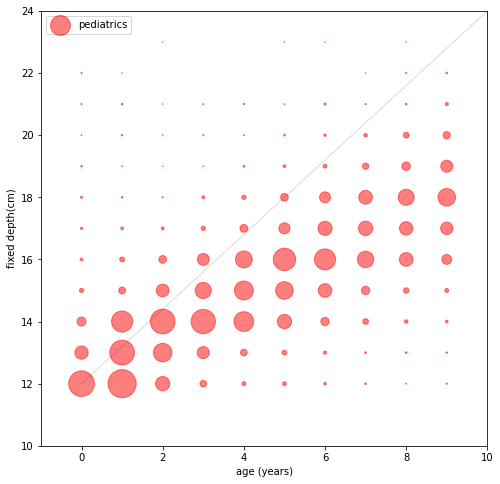

In [34]:
x_age0 = [math.floor(ag) for ag in x_age]
y_depth0 = [round(ele) for ele in y_depth]

xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(0, 10, 1):
    for y in np.arange(12, 24, 1):
        xvals.append(x)
        yvals.append(y)
        cvals.append(sum((x_age0 == x) & (y_depth0 == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2

plt.figure(figsize=(8, 8))
plt.xlim(-1, 10)
plt.ylim(10, 24)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals, label='pediatrics')
plt.xlabel('age (years)')
plt.ylabel('fixed depth(cm)')
lgnd = plt.legend()
#lgnd.legendHandles[0]._sizes = [30]
plt.plot([0,10], [12,17], 'k-', alpha=0.1)   # pals = 12 + age/2

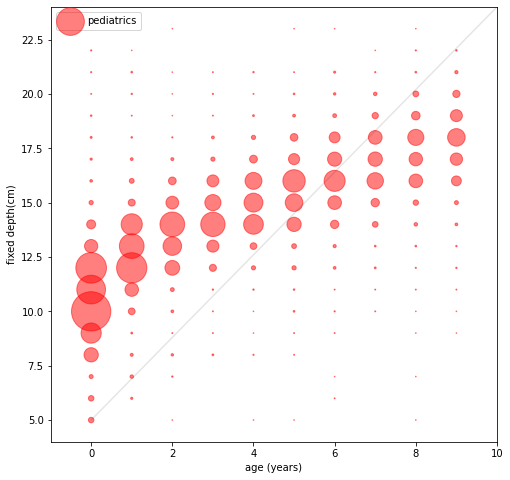

In [38]:
x_age0 = [math.floor(ag) for ag in x_age]
y_depth0 = [round(ele) for ele in y_depth]

xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(0, 10, 1):
    for y in np.arange(5, 24, 1):
        xvals.append(x)
        yvals.append(y)
        cvals.append(sum((x_age0 == x) & (y_depth0 == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2

plt.figure(figsize=(8, 8))
plt.xlim(-1, 10)
plt.ylim(4, 24)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals, label='pediatrics')
plt.xlabel('age (years)')
plt.ylabel('fixed depth(cm)')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([0,10], [12,17], 'k-', alpha=0.1)   # pals = 12 + age/2

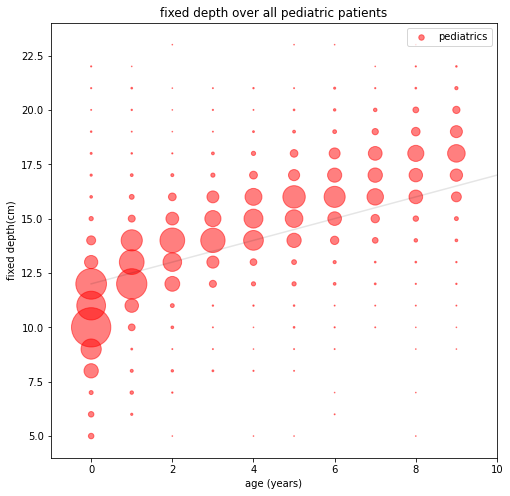

In [42]:
plt.figure(figsize=(8, 8))
plt.title('fixed depth over all pediatric patients')
plt.xlim(-1, 10)
plt.ylim(4, 24)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals, label='pediatrics')
plt.xlabel('age (years)')
plt.ylabel('fixed depth(cm)')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([0,10], [12,17], 'k-', alpha=0.1)   # pals = 12 + age/2

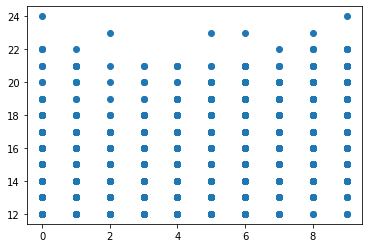

In [24]:
import math
x_age = x[:,0]

plt.scatter([math.floor(ag) for ag in x_age], [round(ele) for ele in y])

In [26]:
y_depth = y

(array([1.67e+03, 1.52e+02, 4.90e+01, 1.10e+01, 1.00e+01, 1.30e+01,
        2.00e+00, 3.00e+00, 3.00e+00, 1.00e+00]),
 array([12. , 13.2, 14.4, 15.6, 16.8, 18. , 19.2, 20.4, 21.6, 22.8, 24. ]),
 <BarContainer object of 10 artists>)

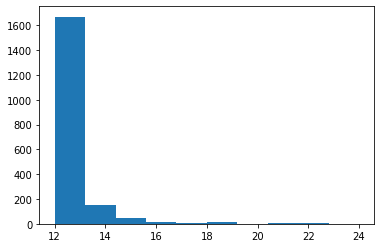

In [25]:
y_infant = y[(0<x_age) & (x_age<1)]
plt.hist(y_infant)